In [ ]:
import pandas as pd
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import numpy as np

try:
    import yaml
except ImportError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pyyaml"])
    import yaml

import re
import csv
from pathlib import Path

In [17]:
dfBoardingData = pd.read_csv("BoardingData.csv", sep=';')
dfBoardingData

PassengerFirstName PassengerSecondName PassengerLastName PassengerSex  \
0                 SAVELII         VIKTOROVICH           RUSANOV         Male   
1                     LEV           MARKOVICH             ISAEV         Male   
2                 NIKOLAI                  I.         NIKOLSKII         Male   
3                ANATOLII           PETROVICH            SHILOV         Male   
4               MIROSLAVA      VIACHESLAVOVNA          SEMENOVA       Female   
...                   ...                 ...               ...          ...   
155142              RAMIL                  S.          DOROFEEV         Male   
155143             RUSLAN     KONSTANTINOVICH        CHISTIAKOV         Male   
155144              SOFIA           VALEREVNA         KALMYKOVA       Female   
155145         VIACHESLAV                  F.           KONONOV         Male   
155146            ESENIIA           DANILOVNA           BLINOVA       Female   

       PassengerBirthDate PassengerDocument    BookingCode      TicketNumber  \
0              03/10/1983       2879 096860         FRNINO  6625956945991971   
1              12/13/1975       1788 173211  Not presented  1643715499224676   
2              12/26/1990       4396 926588         VWNYGF  6247422701565929   
3              05/24/1997       2595 919752         WQFFUE     Not presented   
4              01/31/1976       6775 516990  Not presented     Not presented   
...                   ...               ...            ...               ...   
155142         02/14/1994       3256 077151         SNRBXU  8653871661040452   
155143         02/14/1975       3497 458395  Not presented  0223584175158947   
155144         12/17/1972       6618 352713  Not presented     Not presented   
155145         05/20/2000       4567 242088  Not presented  0975693658645383   
155146         03/07/1984       2861 762272  Not presented     Not presented   

           Baggage  FlightDate FlightTime FlightNumber CodeShare  \
0          Transit  2017-03-22      06:05       SU1369       Own   
1       Registered  2017-03-18      22:10       SU1180       Own   
2          Transit  2017-03-18      22:10       SU1180       Own   
3       Registered  2017-03-18      22:10       SU1180       Own   
4       Registered  2017-03-12      11:45       SU6284       Own   
...            ...         ...        ...          ...       ...   
155142     Delayed  2017-05-18      06:30       SU1158       Own   
155143         NaN  2017-05-18      06:30       SU1158       Own   
155144  Registered  2017-10-02      07:30       SU5614       Own   
155145  Registered  2017-09-16      07:00       SU1640       Own   
155146         NaN  2017-05-09      07:00       SU1279       Own   

          Destination  
0              Moscow  
1           Volgograd  
2           Volgograd  
3           Volgograd  
4              Moscow  
...               ...  
155142         Rostov  
155143         Rostov  
155144  Petropavlovsk  
155145           Omsk  
155146         Moscow  

[155147 rows x 14 columns]

In [ ]:

input_path = Path("SkyTeam-Exchange.yaml")
output_path = Path("SkyTeam-Exchange.csv")

In [ ]:


date_re = re.compile(r"\d{4}-\d{2}-\d{2}")

def looks_like_date(s):
    return bool(date_re.fullmatch(str(s)))

def infer_date_from_filename(p: Path):
    m = date_re.search(p.name)
    return m.group(0) if m else None

def collect_rows(doc, fallback_date=None):
    rows = []
    if not isinstance(doc, dict):
        return rows

    date_keys = [k for k in doc.keys() if looks_like_date(k)]
    if date_keys:
        for d in date_keys:
            flights = doc.get(d)
            if not isinstance(flights, dict):
                continue
            for flight, details in flights.items():
                if not isinstance(details, dict):
                    continue
                frm = details.get("FROM")
                status = details.get("STATUS")
                to = details.get("TO")
                ff = details.get("FF")
                if isinstance(ff, dict):
                    for code, info in ff.items():
                        cls = info.get("CLASS") if isinstance(info, dict) else None
                        fare = info.get("FARE") if isinstance(info, dict) else None
                        rows.append({
                            "DATE": d,
                            "FLIGHT": str(flight),
                            "FROM": frm,
                            "STATUS": status,
                            "TO": to,
                            "CODE": str(code),
                            "CLASS": cls,
                            "FARE": fare
                        })
    else:
        d = fallback_date
        flights = doc.get("FLIGHTS", doc)
        for flight, details in (flights.items() if isinstance(flights, dict) else []):
            if not isinstance(details, dict):
                continue
            frm = details.get("FROM")
            status = details.get("STATUS")
            to = details.get("TO")
            ff = details.get("FF")
            if isinstance(ff, dict):
                for code, info in ff.items():
                    cls = info.get("CLASS") if isinstance(info, dict) else None
                    fare = info.get("FARE") if isinstance(info, dict) else None
                    rows.append({
                        "DATE": d,
                        "FLIGHT": str(flight),
                        "FROM": frm,
                        "STATUS": status,
                        "TO": to,
                        "CODE": str(code),
                        "CLASS": cls,
                        "FARE": fare
                    })
    return rows

In [ ]:

fb_date = infer_date_from_filename(input_path)

all_rows = []
with input_path.open("r", encoding="utf-8") as f:
    for doc in yaml.safe_load_all(f):
        if doc is None:
            continue
        all_rows.extend(collect_rows(doc, fallback_date=fb_date))

# удаляем пустые
all_rows = [r for r in all_rows if any(r.values())]

# дедупликация
seen, unique_rows = set(), []
for r in all_rows:
    key = (r.get("DATE"), r.get("FLIGHT"), r.get("FROM"), r.get("STATUS"), r.get("TO"),
           r.get("CODE"), r.get("CLASS"), r.get("FARE"))
    if key not in seen:
        seen.add(key)
        unique_rows.append(r)

In [ ]:

header = ["DATE", "FLIGHT", "FROM", "STATUS", "TO", "CODE", "CLASS", "FARE"]

with output_path.open("w", newline="", encoding="utf-8") as f:
    w = csv.DictWriter(f, fieldnames=header, extrasaction="ignore")
    w.writeheader()
    for r in unique_rows:
        w.writerow({k: ("" if r.get(k) is None else r.get(k)) for k in header})

print(f"Строк: {len(unique_rows)}; файл: {output_path.resolve()}")

Строк: 1687053; файл: /Users/mcsquare/Documents/Учёба/Data analysis/Airlines/SkyTeam-Exchange.csv


In [ ]:
import csv

def process_loyalty_programs(input_file, output_file):
    with open(input_file, 'r', newline='', encoding='utf-8') as infile, \
         open(output_file, 'w', newline='', encoding='utf-8') as outfile:
        
        reader = csv.reader(infile)
        writer = csv.writer(outfile)
        
        # Читаем и записываем заголовок
        headers = next(reader)
        writer.writerow(headers)
        
        for row in reader:
            # Разбираем программы лояльности
            loyalty_programs = row[3].split(';') if row[3] else []
            
            if not loyalty_programs:
                # Если программ нет, записываем исходную строку
                writer.writerow(row)
            else:
                for program in loyalty_programs:
                    parts = program.split('|')
                    if len(parts) >= 3:
                        # Форматируем программу как "КодАвиакомпании Номер"
                        new_program = f"{parts[0]} {parts[2]}"
                        
                        # Создаем копию строки с новой программой
                        new_row = row.copy()
                        new_row[3] = new_program
                        writer.writerow(new_row)


process_loyalty_programs('csv/FrequentFlyerForum-Profiles.csv', 'csv/FrequentFlyerForum-Profiles-pars2.csv')

In [ ]:
import pandas as pd

def merge_and_find_discrepancies(file1_path, file2_path, output_merged_path, output_discrepancies_path):
    # Загружаем оба файла
    df1 = pd.read_csv(file1_path)
    df2 = pd.read_csv(file2_path)
    
    print("Размеры файлов:")
    print(f"Файл 1: {df1.shape}")
    print(f"Файл 2: {df2.shape}")
    
    # Предварительная обработка данных для лучшего сопоставления
    # Приводим даты к одинаковому формату и создаем ключи для объединения
    
    # Создаем ключ для объединения в первом файле
    df1['merge_key'] = df1['Date'] + '_' + df1['Flight']
    
    # Создаем ключ для объединения во втором файле
    df2['merge_key'] = df2['DATE'] + '_' + df2['FLIGHT']
    
    # Объединяем файлы
    merged_df = pd.merge(df1, df2, on='merge_key', how='outer', indicator=True)
    
    print(f"\nРазмер объединенной таблицы: {merged_df.shape}")
    
    # Находим несоответствия
    # 1. Строки, которые есть только в одном из файлов
    only_in_file1 = merged_df[merged_df['_merge'] == 'left_only']
    only_in_file2 = merged_df[merged_df['_merge'] == 'right_only']
    
    # 2. Строки, которые есть в обоих файлах, но с несоответствиями в данных
    both_files = merged_df[merged_df['_merge'] == 'both']
    
    # Проверяем несоответствия в аэропортах
    airport_mismatch = both_files[
        (both_files['Departure_Airport'] != both_files['FROM']) | 
        (both_files['Arrival_Airport'] != both_files['TO'])
    ]
    
    # Проверяем несоответствия в датах (на случай если ключ сработал, но даты разные)
    date_mismatch = both_files[both_files['Date'] != both_files['DATE']]
    
    # Собираем все несоответствия в один DataFrame
    discrepancies = pd.concat([
        only_in_file1,
        only_in_file2,
        airport_mismatch,
        date_mismatch
    ]).drop_duplicates()
    
    print(f"\nНайдено несоответствий: {len(discrepancies)}")
    
    # Сохраняем объединенную таблицу
    # Убираем служебные столбцы
    final_merged = merged_df.drop(['merge_key', '_merge'], axis=1)
    final_merged.to_csv(output_merged_path, index=False)
    
    # Сохраняем несоответствия
    discrepancies.to_csv(output_discrepancies_path, index=False)
    
    # Детальная статистика
    print("\nДетальная статистика:")
    print(f"Только в файле 1: {len(only_in_file1)}")
    print(f"Только в файле 2: {len(only_in_file2)}")
    print(f"Несоответствие аэропортов: {len(airport_mismatch)}")
    print(f"Несоответствие дат: {len(date_mismatch)}")
    
    return final_merged, discrepancies

def advanced_merge_and_validation(file1_path, file2_path, output_merged_path, output_discrepancies_path):
    df1 = pd.read_csv(file1_path)
    df2 = pd.read_csv(file2_path)
    
    # Создаем несколько ключей для объединения
    df1['key_date_flight'] = df1['Date'] + '_' + df1['Flight']
    df1['key_airports'] = df1['Departure_Airport'] + '_' + df1['Arrival_Airport'] + '_' + df1['Date']
    
    df2['key_date_flight'] = df2['DATE'] + '_' + df2['FLIGHT']
    df2['key_airports'] = df2['FROM'] + '_' + df2['TO'] + '_' + df2['DATE']
    
    # Пробуем объединить по разным ключам
    merged_by_flight = pd.merge(df1, df2, left_on='key_date_flight', right_on='key_date_flight', 
                               how='outer', indicator=True, suffixes=('_file1', '_file2'))
    
    merged_by_airports = pd.merge(df1, df2, left_on='key_airports', right_on='key_airports',
                                 how='outer', indicator=True, suffixes=('_file1', '_file2'))
    
    # Выбираем лучший способ объединения (по количеству совпадений)
    matches_flight = len(merged_by_flight[merged_by_flight['_merge'] == 'both'])
    matches_airports = len(merged_by_airports[merged_by_airports['_merge'] == 'both'])
    
    print(f"Совпадений по дате+рейсу: {matches_flight}")
    print(f"Совпадений по аэропортам+дате: {matches_airports}")
    
    # Используем способ с большим количеством совпадений
    if matches_flight >= matches_airports:
        final_merged = merged_by_flight
        print("Используется объединение по дате и номеру рейса")
    else:
        final_merged = merged_by_airports
        print("Используется объединение по аэропортам и дате")
    
    # Находим все типы несоответствий
    discrepancies_list = []
    
    # 1. Отсутствующие в одном из файлов
    missing_in_file2 = final_merged[final_merged['_merge'] == 'left_only']
    missing_in_file1 = final_merged[final_merged['_merge'] == 'right_only']
    
    # 2. Проверяем логические несоответствия для совпадающих строк
    both_exists = final_merged[final_merged['_merge'] == 'both']
    
    # Проверяем различные возможные несоответствия
    if not both_exists.empty:
        # Несоответствие городов и аэропортов
        city_airport_mismatch = both_exists[
            (both_exists['Departure_City'] + '_' + both_exists['Departure_Airport'] != 
             both_exists['FROM'] + '_' + both_exists['FROM']) |
            (both_exists['Arrival_City'] + '_' + both_exists['Arrival_Airport'] != 
             both_exists['TO'] + '_' + both_exists['TO'])
        ]
        
        # Несоответствие статусов (если в файле 1 есть какая-то логика статусов)
        status_mismatch = both_exists[
            (both_exists['Codeshare'] == True) & (both_exists['STATUS'] != 'CODESHARE')
        ]
        
        discrepancies_list.extend([missing_in_file2, missing_in_file1, city_airport_mismatch, status_mismatch])
    
    # Объединяем все несоответствия
    all_discrepancies = pd.concat(discrepancies_list).drop_duplicates() if discrepancies_list else pd.DataFrame()
    
    # Сохраняем результаты
    final_merged.drop(['key_date_flight', 'key_airports', '_merge'], axis=1, errors='ignore').to_csv(output_merged_path, index=False)
    all_discrepancies.to_csv(output_discrepancies_path, index=False)
    
    print(f"\nИтоговые размеры:")
    print(f"Объединенная таблица: {final_merged.shape}")
    print(f"Несоответствия: {all_discrepancies.shape}")
    
    return final_merged, all_discrepancies

In [ ]:

if __name__ == "__main__":
    
    merged, discrepancies = merge_and_find_discrepancies(
        'csv/FrequentFlyerForum-Profiles-pars2.csv',  
        'csv/SkyTeam-Exchange.csv',         
        'merged_resultFS.csv',
        'discrepanciesFS.csv'
    )
    

Размеры файлов:
Файл 1: (1931942, 15)
Файл 2: (1687053, 8)

Размер объединенной таблицы: (6136597, 25)

Найдено несоответствий: 920725

Детальная статистика:
Только в файле 1: 113196
Только в файле 2: 372416
Несоответствие аэропортов: 435113
Несоответствие дат: 0


In [ ]:


def unify_and_merge_tables(file1_path, file2_path, output_merged_path, output_unmerged_path, plot_path):
    # Загружаем оба файла
    df1 = pd.read_csv(file1_path)
    df2 = pd.read_csv(file2_path)
    
    print("Исходные размеры:")
    print(f"Файл 1: {df1.shape}")
    print(f"Файл 2: {df2.shape}")
    
    # Приводим названия столбцов к единому виду
    df2_renamed = df2.rename(columns={
        'DATE': 'Date',
        'FLIGHT': 'Flight', 
        'CODE': 'Loyality_Programs',
        'FROM': 'Departure_Airport',
        'TO': 'Arrival_Airport'
    })
    
    # Оставляем только нужные столбцы для объединения + дополнительные для анализа
    keep_columns_df1 = ['Date', 'Flight', 'Loyality_Programs', 'Departure_Airport', 'Arrival_Airport', 
                       'NickName', 'Sex', 'Real_Name_Last_Name', 'Real_Name_First_Name', 'Codeshare']
    
    keep_columns_df2 = ['Date', 'Flight', 'Loyality_Programs', 'Departure_Airport', 'Arrival_Airport',
                       'STATUS', 'CLASS', 'FARE']
    
    # Отбираем только существующие столбцы
    df1_clean = df1[[col for col in keep_columns_df1 if col in df1.columns]].copy()
    df2_clean = df2_renamed[[col for col in keep_columns_df2 if col in df2_renamed.columns]].copy()
    
    # Приводим типы данных к строковым для ключевых столбцов
    key_columns = ['Date', 'Flight', 'Loyality_Programs', 'Departure_Airport', 'Arrival_Airport']
    
    for col in key_columns:
        if col in df1_clean.columns:
            df1_clean[col] = df1_clean[col].astype(str).str.strip()
        if col in df2_clean.columns:
            df2_clean[col] = df2_clean[col].astype(str).str.strip()
    
    # Создаем составной ключ для объединения
    df1_clean['composite_key'] = (
        df1_clean['Date'] + '|' + 
        df1_clean['Flight'] + '|' + 
        df1_clean['Loyality_Programs'] + '|' + 
        df1_clean['Departure_Airport'] + '|' + 
        df1_clean['Arrival_Airport']
    )
    
    df2_clean['composite_key'] = (
        df2_clean['Date'] + '|' + 
        df2_clean['Flight'] + '|' + 
        df2_clean['Loyality_Programs'] + '|' + 
        df2_clean['Departure_Airport'] + '|' + 
        df2_clean['Arrival_Airport']
    )
    
    # Выполняем объединение
    merged_df = pd.merge(df1_clean, df2_clean, on='composite_key', how='inner', suffixes=('_file1', '_file2'))
    
    # Находим необъединенные строки
    df1_keys = set(df1_clean['composite_key'])
    df2_keys = set(df2_clean['composite_key'])
    matched_keys = set(merged_df['composite_key'])
    
    unmatched_df1 = df1_clean[~df1_clean['composite_key'].isin(matched_keys)]
    unmatched_df2 = df2_clean[~df2_clean['composite_key'].isin(matched_keys)]
    
    # Анализируем причины несовпадений
    mismatch_analysis = analyze_mismatch_reasons(unmatched_df1, unmatched_df2, df1_keys, df2_keys, key_columns)
    
    # Создаем финальный файл необъединенных строк
    unmerged_final = create_unmerged_final(unmatched_df1, unmatched_df2, key_columns)
    
    # Сохраняем результаты
    # Удаляем служебные столбцы перед сохранением
    if 'composite_key' in merged_df.columns:
        merged_df_final = merged_df.drop('composite_key', axis=1)
    else:
        merged_df_final = merged_df
    
    merged_df_final.to_csv(output_merged_path, index=False)
    unmerged_final.to_csv(output_unmerged_path, index=False)
    
    # Строим диаграмму
    plot_mismatch_reasons(mismatch_analysis, plot_path)
    
    print(f"\nРезультаты:")
    print(f"Успешно объединено: {len(merged_df)} строк")
    print(f"Не объединено: {len(unmerged_final)} строк")
    print(f"Из файла 1 не совпало: {len(unmatched_df1)} строк")
    print(f"Из файла 2 не совпало: {len(unmatched_df2)} строк")
    
    return merged_df_final, unmerged_final, mismatch_analysis

def analyze_mismatch_reasons(unmatched_df1, unmatched_df2, df1_keys, df2_keys, key_columns):
    """Анализирует причины несовпадений"""
    mismatch_counts = defaultdict(int)
    
    # Для каждой несовпавшей строки из первого файла
    for key in unmatched_df1['composite_key']:
        key_parts = key.split('|')
        
        # Проверяем каждый компонент ключа
        for i, col_name in enumerate(key_columns):
            test_key_parts = list(key_parts)
            
            # Пробуем изменить один компонент и проверить, есть ли совпадение
            for possible_value in unmatched_df2[key_columns[i]].unique():
                test_key_parts[i] = str(possible_value)
                test_key = '|'.join(test_key_parts)
                
                if test_key in df2_keys:
                    mismatch_counts[col_name] += 1
                    break
    
    # Аналогично для второго файла
    for key in unmatched_df2['composite_key']:
        key_parts = key.split('|')
        
        for i, col_name in enumerate(key_columns):
            test_key_parts = list(key_parts)
            
            for possible_value in unmatched_df1[key_columns[i]].unique():
                test_key_parts[i] = str(possible_value)
                test_key = '|'.join(test_key_parts)
                
                if test_key in df1_keys:
                    mismatch_counts[col_name] += 1
                    break
    
    return dict(mismatch_counts)

def create_unmerged_final(unmatched_df1, unmatched_df2, key_columns):
    """Создает финальный файл необъединенных строк с указанием источника"""
    unmatched_df1['source'] = 'file1'
    unmatched_df2['source'] = 'file2'
    
    # Объединяем несовпавшие строки
    unmerged_combined = pd.concat([unmatched_df1, unmatched_df2], ignore_index=True)
    
    # Добавляем информацию о том, какие ключи не совпали
    def find_mismatch_reason(row, all_keys, key_columns):
        if row['source'] == 'file1':
            target_keys = set(unmatched_df2['composite_key'])
        else:
            target_keys = set(unmatched_df1['composite_key'])
        
        reasons = []
        key_parts = row['composite_key'].split('|')
        
        for i, col in enumerate(key_columns):
            # Проверяем, изменится ли ситуация если изменить этот компонент
            for test_key in target_keys:
                test_parts = test_key.split('|')
                # Если все компоненты кроме одного совпадают
                mismatch_count = sum(1 for j in range(len(key_parts)) 
                                   if j != i and key_parts[j] != test_parts[j])
                
                if mismatch_count == 0 and key_parts[i] != test_parts[i]:
                    reasons.append(col)
                    break
        
        return ', '.join(reasons) if reasons else 'multiple mismatches'
    
    all_keys_combined = set(unmatched_df1['composite_key']).union(set(unmatched_df2['composite_key']))
    unmerged_combined['mismatch_reason'] = unmerged_combined.apply(
        lambda row: find_mismatch_reason(row, all_keys_combined, key_columns), axis=1
    )
    
    return unmerged_combined

def plot_mismatch_reasons(mismatch_analysis, plot_path):
    """Строит диаграмму причин несовпадений"""
    if not mismatch_analysis:
        print("Нет данных для построения диаграммы")
        return
    
    plt.figure(figsize=(10, 6))
    
    # Сортируем по количеству несовпадений
    sorted_items = sorted(mismatch_analysis.items(), key=lambda x: x[1], reverse=True)
    reasons = [item[0] for item in sorted_items]
    counts = [item[1] for item in sorted_items]
    
    # Создаем столбчатую диаграмму
    bars = plt.bar(reasons, counts, color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#ff99cc'])
    
    # Добавляем подписи значений
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                f'{count}', ha='center', va='bottom')
    
    plt.title('Причины несовпадений при объединении таблиц', fontsize=14, fontweight='bold')
    plt.xlabel('Критерии объединения', fontsize=12)
    plt.ylabel('Количество несовпадений', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # Сохраняем диаграмму
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Диаграмма сохранена в: {plot_path}")


def detailed_mismatch_analysis(unmerged_df, key_columns):
    """Детальный анализ несовпадений"""
    print("\nДетальный анализ несовпадений:")
    
    # Анализ по источнику
    source_counts = unmerged_df['source'].value_counts()
    print(f"Несовпадения по источникам:")
    for source, count in source_counts.items():
        print(f"  {source}: {count} строк")
    
    # Анализ по причинам
    reason_counts = unmerged_df['mismatch_reason'].value_counts()
    print(f"\nРаспределение по причинам:")
    for reason, count in reason_counts.head(10).items():  # топ-10 причин
        print(f"  {reason}: {count} строк")
    
    # Примеры несовпавших строк
    print(f"\nПримеры несовпавших строк:")
    for source in ['file1', 'file2']:
        sample = unmerged_df[unmerged_df['source'] == source].head(2)
        if not sample.empty:
            print(f"\nИз {source}:")
            for idx, row in sample.iterrows():
                print(f"  Ключ: {row['composite_key']}")
                print(f"  Причина: {row['mismatch_reason']}")


if __name__ == "__main__":
    merged, unmerged, mismatch_stats = unify_and_merge_tables(
        'csv/FrequentFlyerForum-Profiles-pars2.csv',  
        'csv/SkyTeam-Exchange.csv',         
        'csv/merged_final.csv',
        'csv/unmerged_rows.csv',
        'mismatch_analysis.png'
    )
    
    detailed_mismatch_analysis(unmerged, ['Date', 'Flight', 'Loyality_Programs', 'Departure_Airport', 'Arrival_Airport'])

Исходные размеры:
Файл 1: (1931942, 15)
Файл 2: (1687053, 8)


KeyboardInterrupt: 

In [ ]:

import pandas as pd

# Загрузка данных
df = pd.read_csv('csv/SkyTeam-Exchange.csv')  # Замените на ваш путь

# Удаление столбца STATUS и дубликатов
df_cleaned = df.drop('STATUS', axis=1).drop_duplicates()

# Сохранение результата
df_cleaned.to_csv('csv/cleaned_flights.csv', index=False)

print("Обработка завершена!")
print(f"Исходных строк: {len(df)}")
print(f"После очистки: {len(df_cleaned)}")
print("Файл сохранен как 'cleaned_flights.csv'")

Обработка завершена!
Исходных строк: 1687053
После очистки: 1687053
Файл сохранен как 'cleaned_flights.csv'


In [ ]:

import pandas as pd


df = pd.read_csv('csv/FrequentFlyerForum-Profiles-pars2.csv')  # замените 'your_file.csv' на путь к вашему файлу


print("Исходные данные:")
print(f"Размерность: {df.shape}")
print("\nПервые 5 строк:")
df.head()

Исходные данные:
Размерность: (1931942, 15)

Первые 5 строк:


NickName       Travel_Documents     Sex Loyality_Programs  \
0  FrequentFlyer44020  [{"Passports": null}]     NaN       KE 82434512   
1  FrequentFlyer34309  [{"Passports": null}]  Female      SU 807528558   
2  FrequentFlyer43111  [{"Passports": null}]  Female      FB 602456121   
3  FrequentFlyer89261  [{"Passports": null}]  Female      FB 479150846   
4  FrequentFlyer89261  [{"Passports": null}]  Female      KE 205119297   

  Real_Name_Last_Name Real_Name_First_Name        Date  Codeshare  \
0                 NaN                  NaN  2017-01-01      False   
1                 NaN                  NaN  2017-01-01      False   
2           ASTAF'EVA                 INNA  2017-01-01      False   
3                 NaN                  NaN  2017-01-01      False   
4                 NaN                  NaN  2017-01-01      False   

       Arrival_City Arrival_Airport     Arrival_Country  Flight  \
0  Saint Petersburg             LED             Russian  SU6574   
1            Moscow             SVO  Russian Federation  SU1357   
2            Moscow             SVO  Russian Federation  SU1465   
3            Moscow             SVO  Russian Federation  SU1463   
4            Moscow             SVO  Russian Federation  SU1463   

  Departure_City Departure_Airport   Departure_Country  
0    Krasnoyarsk               KJA  Russian Federation  
1        Saratov               RTW  Russian Federation  
2        Saransk               SKX  Russian Federation  
3    Novosibirsk               OVB  Russian Federation  
4    Novosibirsk               OVB  Russian Federation

In [ ]:
df_cleaned = df.drop('Travel_Documents', axis=1)  # удаляем столбец

# Переименовываем столбцы
df_cleaned = df_cleaned.rename(columns={
    'Loyality_Programs': 'CODE',
    'Date': 'DATE',
    'Arrival_Airport': 'TO',
    'Flight': 'FLIGHT',
    'Departure_Airport': 'FROM'
})

# Переводим все названия столбцов в верхний регистр
df_cleaned.columns = df_cleaned.columns.str.upper()

print("После удаления столбца и переименования:")
print(f"Размерность: {df_cleaned.shape}")
df_cleaned.head()

После удаления столбца и переименования:
Размерность: (1931942, 14)


NICKNAME     SEX          CODE REAL_NAME_LAST_NAME  \
0  FrequentFlyer44020     NaN   KE 82434512                 NaN   
1  FrequentFlyer34309  Female  SU 807528558                 NaN   
2  FrequentFlyer43111  Female  FB 602456121           ASTAF'EVA   
3  FrequentFlyer89261  Female  FB 479150846                 NaN   
4  FrequentFlyer89261  Female  KE 205119297                 NaN   

  REAL_NAME_FIRST_NAME        DATE  CODESHARE      ARRIVAL_CITY   TO  \
0                  NaN  2017-01-01      False  Saint Petersburg  LED   
1                  NaN  2017-01-01      False            Moscow  SVO   
2                 INNA  2017-01-01      False            Moscow  SVO   
3                  NaN  2017-01-01      False            Moscow  SVO   
4                  NaN  2017-01-01      False            Moscow  SVO   

      ARRIVAL_COUNTRY  FLIGHT DEPARTURE_CITY FROM   DEPARTURE_COUNTRY  
0             Russian  SU6574    Krasnoyarsk  KJA  Russian Federation  
1  Russian Federation  SU1357        Saratov  RTW  Russian Federation  
2  Russian Federation  SU1465        Saransk  SKX  Russian Federation  
3  Russian Federation  SU1463    Novosibirsk  OVB  Russian Federation  
4  Russian Federation  SU1463    Novosibirsk  OVB  Russian Federation

In [ ]:

print(f"Количество строк до удаления дубликатов: {len(df_cleaned)}")

df_final = df_cleaned.drop_duplicates()

print(f"Количество строк после удаления дубликатов: {len(df_final)}")
print(f"Удалено дубликатов: {len(df_cleaned) - len(df_final)}")

Количество строк до удаления дубликатов: 1931942
Количество строк после удаления дубликатов: 1931942
Удалено дубликатов: 0


In [ ]:

df_final.to_csv('csv/FrequentFlyerForum-Profiles-pars2-cleaned.csv', index=False)
print("Файл сохранён как 'csv/FrequentFlyerForum-Profiles-pars2-cleaned.csv'")

Файл сохранён как 'csv/FrequentFlyerForum-Profiles-pars2-cleaned.csv'


flights
4        1
5        1
6       13
7       38
8       73
9      190
10     420
11     702
12    1218
13    1871
14    2678
15    3668
16    4637
17    5524
18    6018
19    6260
20    6066
21    5676
22    5135
23    4330
24    3452
25    2729
26    1933
27    1403
28     984
29     638
30     385
31     231
32     140
33      89
34      37
35      22
36      16
37      10
38       2
41       1
42       1
Name: count, dtype: int64


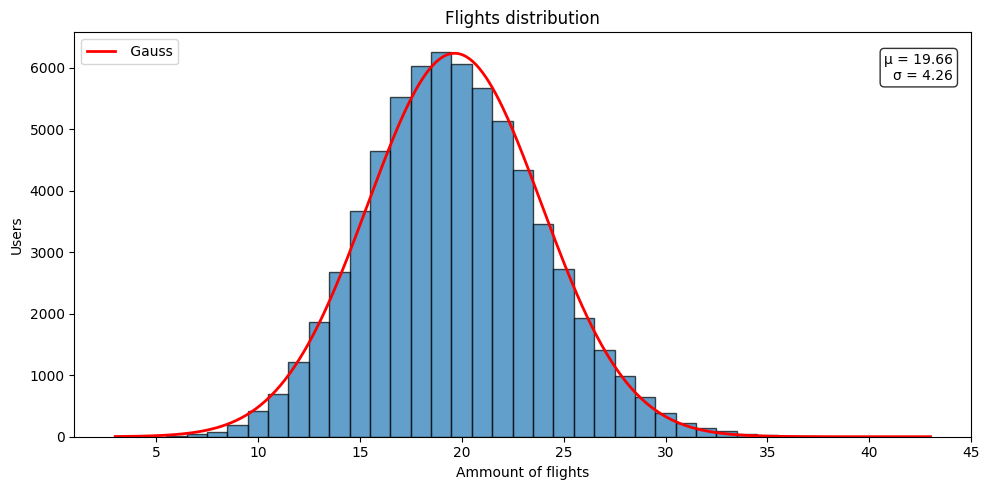

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

csv_path = 'csv/FrequentFlyerForum-Profiles.csv'

df = pd.read_csv(csv_path)
df = df.dropna(subset=['NickName'])

flights_per_user = df.groupby('NickName').size().rename('flights')
distribution = flights_per_user.value_counts().sort_index()

print(distribution)
distribution.to_csv('csv/plots/distribution_by_flights_per_user.csv', header=['users'])

data = flights_per_user.values
mu, sigma = norm.fit(data)

bins = np.arange(data.min(), data.max() + 2) - 0.5
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(data, bins=bins, color='C0', alpha=0.7, edgecolor='k')

x = np.linspace(data.min() - 1, data.max() + 1, 500)
bin_width = bins[1] - bins[0]
y = norm.pdf(x, mu, sigma) * len(data) * bin_width
ax.plot(x, y, 'r-', lw=2, label=' Gauss')

ax.set_xlabel('Ammount of flights')
ax.set_ylabel('Users')
ax.set_title('Flights distribution')
ax.legend()

text = f'μ = {mu:.2f}\nσ = {sigma:.2f}'
ax.text(0.98, 0.95, text, transform=ax.transAxes, ha='right', va='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

flights
4        1
5        1
6       13
7       38
8       73
9      190
10     420
11     702
12    1218
13    1871
14    2678
15    3668
16    4637
17    5524
18    6018
19    6260
20    6066
21    5676
22    5135
23    4330
24    3452
25    2729
26    1933
27    1403
28     984
29     638
30     385
31     231
32     140
33      89
34      37
35      22
36      16
37      10
38       2
41       1
42       1
Name: count, dtype: int64


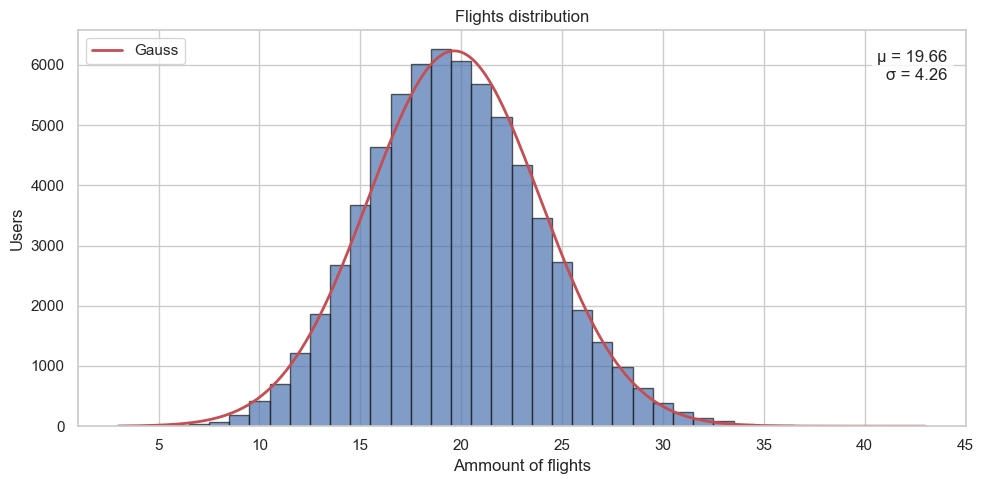

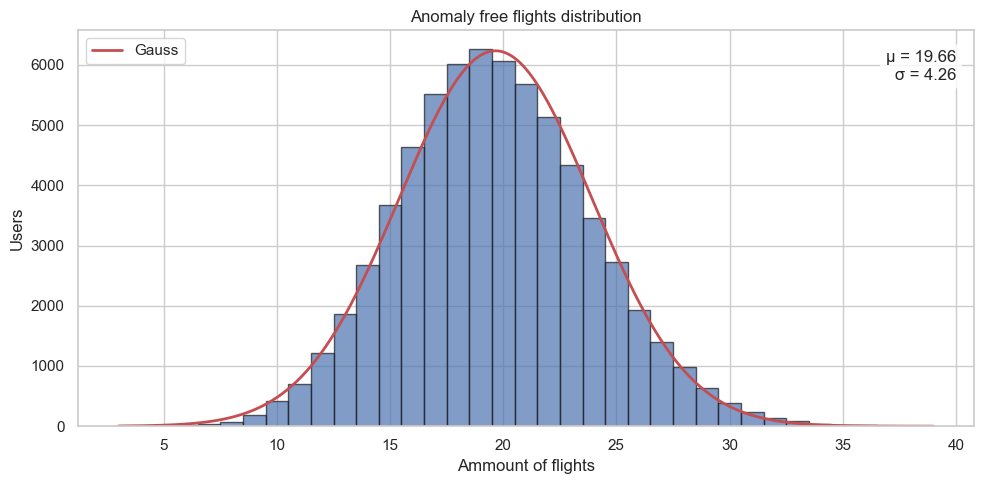

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, t

csv_path = 'csv/FrequentFlyerForum-Profiles.csv'

df = pd.read_csv(csv_path)
df = df.dropna(subset=['NickName'])

flights_per_user = df.groupby('NickName').size().rename('flights')
distribution = flights_per_user.value_counts().sort_index()

print(distribution)
distribution.to_csv('csv/plots/distribution_by_flights_per_user.csv', header=['users'])

data = flights_per_user.values
mu, sigma = norm.fit(data)

bins = np.arange(data.min(), data.max() + 2) - 0.5
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(data, bins=bins, color='C0', alpha=0.7, edgecolor='k')

x = np.linspace(data.min() - 1, data.max() + 1, 500)
bin_width = bins[1] - bins[0]
y = norm.pdf(x, mu, sigma) * len(data) * bin_width
ax.plot(x, y, 'r-', lw=2, label='Gauss')

ax.set_xlabel('Ammount of flights')
ax.set_ylabel('Users')
ax.set_title('Flights distribution')
ax.legend()

text = f'μ = {mu:.2f}\nσ = {sigma:.2f}'
ax.text(0.98, 0.95, text, transform=ax.transAxes, ha='right', va='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

def grubbs_one_outlier(series, alpha=.05):
    x = series.values.astype(float)
    n = len(x)
    if n < 3:
        return None
    mu = x.mean()
    s = x.std(ddof=1)
    if s == 0:
        return None
    idx = np.argmax(np.abs(x - mu))
    G = abs(x[idx] - mu) / s
    t_crit = t.ppf(1 - alpha/(2*n), n-2)
    Gcrit = ((n-1)/np.sqrt(n)) * np.sqrt(t_crit**2 / (n - 2 + t_crit**2))
    if G > Gcrit:
        return {
            'NickName': series.index[idx],
            'flights': x[idx],
            'G': G,
            'Gcrit': Gcrit,
            'mu': mu,
            'sigma': s,
            'n': n,
            'side': 'high' if x[idx] > mu else 'low'
        }
    return None

alpha = .05
anoms = []
s = flights_per_user.copy()
it = 1
while True:
    res = grubbs_one_outlier(s, alpha)
    if res is None:
        break
    res['iteration'] = it
    anoms.append(res)
    s = s.drop(res['NickName'])
    it += 1

anoms_df = pd.DataFrame(anoms)
if not anoms_df.empty:
    anoms_df.to_csv('csv/anomalous_users_fisher-json.csv', index=False)
    df_cleaned = df[~df['NickName'].isin(anoms_df['NickName'])]
else:
    df_cleaned = df.copy()

df_cleaned.to_csv('csv/anomalous_users_fisher-json_cleaned.csv', index=False)

flights_per_user_cleaned = df_cleaned.groupby('NickName').size().rename('flights')
distribution_cleaned = flights_per_user_cleaned.value_counts().sort_index()
distribution_cleaned.to_csv('csv/plots/distribution_by_flights_per_user_cleaned.csv', header=['users'])

data2 = flights_per_user_cleaned.values
mu2, sigma2 = norm.fit(data2)

bins2 = np.arange(data2.min(), data2.max() + 2) - 0.5
fig2, ax2 = plt.subplots(figsize=(10, 5))
ax2.hist(data2, bins=bins2, color='C0', alpha=0.7, edgecolor='k')

x2 = np.linspace(data2.min() - 1, data2.max() + 1, 500)
bin_width2 = bins2[1] - bins2[0]
if sigma2 > 0:
    y2 = norm.pdf(x2, mu2, sigma2) * len(data2) * bin_width2
    ax2.plot(x2, y2, 'r-', lw=2, label='Gauss')

ax2.set_xlabel('Ammount of flights')
ax2.set_ylabel('Users')
ax2.set_title('Anomaly free flights distribution')
ax2.legend()

text2 = f'μ = {mu2:.2f}\nσ = {sigma2:.2f}'
ax2.text(0.98, 0.95, text2, transform=ax2.transAxes, ha='right', va='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

csv_path = 'csv/FrequentFlyerForum-Profiles.csv'

df = pd.read_csv(csv_path)
df = df.dropna(subset=['NickName'])

# Кол-во полетов на пользователя
flights_per_user = df.groupby('NickName').size().rename('flights')
distribution = flights_per_user.value_counts().sort_index()
distribution.to_csv('distribution_by_flights_per_user-iqr-json.csv', header=['users'])

# Функции для IQR
def iqr_stats(x, k=1.5):
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return q1, q3, iqr, lower, upper

def detect_iqr_outliers(series, k=1.5):
    x = series.values.astype(float)
    q1, q3, iqr, lower, upper = iqr_stats(x, k)
    mask = (x < lower) | (x > upper)
    return mask, {'q1': q1, 'q3': q3, 'iqr': iqr, 'lower': lower, 'upper': upper}

# Визуализация: исходные данные
data = flights_per_user.values
mu, sigma = norm.fit(data)
bins = np.arange(data.min(), data.max() + 2) - 0.5
bin_width = bins[1] - bins[0]

q1, q3, iqr, lower, upper = iqr_stats(data, k=1.5)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.hist(data, bins=bins, color='C0', alpha=0.7, edgecolor='k')
x = np.linspace(data.min() - 1, data.max() + 1, 500)
if sigma > 0:
    y = norm.pdf(x, mu, sigma) * len(data) * bin_width
    ax.plot(x, y, 'r-', lw=2, label='Gauss')
ax.axvline(lower, color='orange', ls='--', lw=2, label='IQR')
ax.axvline(upper, color='orange', ls='--', lw=2)
ax.set_xlabel('Ammount of flights')
ax.set_ylabel('Users')
ax.set_title('Origin flights distribution (IQR)')
ax.legend()
ax.text(0.98, 0.95,
        f'μ={mu:.2f}\nσ={sigma:.2f}\nQ1={q1:.2f}\nQ3={q3:.2f}\nIQR={iqr:.2f}\nL={lower:.2f}\nU={upper:.2f}',
        transform=ax.transAxes, ha='right', va='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

axb = axes[1]
axb.boxplot(data, vert=False, showfliers=True)
axb.axvline(lower, color='orange', ls='--', lw=2)
axb.axvline(upper, color='orange', ls='--', lw=2)
axb.set_title('Boxplot (origin)')
axb.set_xlabel('Flights')

plt.tight_layout()
plt.show()

# Итеративное удаление аномалий по IQR
k = 1.5
s = flights_per_user.copy()
anoms = []
it = 1
while True:
    mask, stats = detect_iqr_outliers(s, k=k)
    if not mask.any():
        break
    idx_out = s.index[mask]
    vals_out = s.values[mask]
    for nn, v in zip(idx_out, vals_out):
        anoms.append({
            'iteration': it,
            'NickName': nn,
            'flights': int(v),
            'q1': stats['q1'],
            'q3': stats['q3'],
            'iqr': stats['iqr'],
            'lower': stats['lower'],
            'upper': stats['upper'],
            'side': 'low' if v < stats['lower'] else 'high'
        })
    s = s[~s.index.isin(idx_out)]
    it += 1

anoms_df = pd.DataFrame(anoms)
if not anoms_df.empty:
    anoms_df.to_csv('anomalous_users_iqr-json.csv', index=False)
    df_cleaned = df[~df['NickName'].isin(anoms_df['NickName'])]
else:
    df_cleaned = df.copy()

df_cleaned.to_csv('csv/flights_cleaned_iqr-json.csv', index=False)

# Распределение и визуализация после очистки
flights_per_user_cleaned = df_cleaned.groupby('NickName').size().rename('flights')
distribution_cleaned = flights_per_user_cleaned.value_counts().sort_index()
distribution_cleaned.to_csv('csv/distribution_by_flights_per_user_cleaned_iqr-json.csv', header=['users'])

data2 = flights_per_user_cleaned.values
mu2, sigma2 = norm.fit(data2)
bins2 = np.arange(data2.min(), data2.max() + 2) - 0.5
bin_width2 = bins2[1] - bins2[0]

q1c, q3c, iqrc, lowerc, upperc = iqr_stats(data2, k=k)

fig2, axes2 = plt.subplots(1, 2, figsize=(14, 5))
ax2 = axes2[0]
ax2.hist(data2, bins=bins2, color='C0', alpha=0.7, edgecolor='k')
x2 = np.linspace(data2.min() - 1, data2.max() + 1, 500)
if sigma2 > 0:
    y2 = norm.pdf(x2, mu2, sigma2) * len(data2) * bin_width2
    ax2.plot(x2, y2, 'r-', lw=2, label='Gauss')
ax2.axvline(lowerc, color='orange', ls='--', lw=2, label='IQR')
ax2.axvline(upperc, color='orange', ls='--', lw=2)
ax2.set_xlabel('Ammount of flights')
ax2.set_ylabel('Users')
ax2.set_title('Anomaly free flights distribution (IQR)')
ax2.legend()
ax2.text(0.98, 0.95,
         f'μ={mu2:.2f}\nσ={sigma2:.2f}\nQ1={q1c:.2f}\nQ3={q3c:.2f}\nIQR={iqrc:.2f}\nL={lowerc:.2f}\nU={upperc:.2f}',
         transform=ax2.transAxes, ha='right', va='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

axb2 = axes2[1]
axb2.boxplot(data2, vert=False, showfliers=True)
axb2.axvline(lowerc, color='orange', ls='--', lw=2)
axb2.axvline(upperc, color='orange', ls='--', lw=2)
axb2.set_title('Boxplot (anomaly free)')
axb2.set_xlabel('Flights')

plt.tight_layout()
plt.show()

/var/folders/8c/g4_nx53167zdv_yyyv7k6d600000gn/T/ipykernel_1658/57526544.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


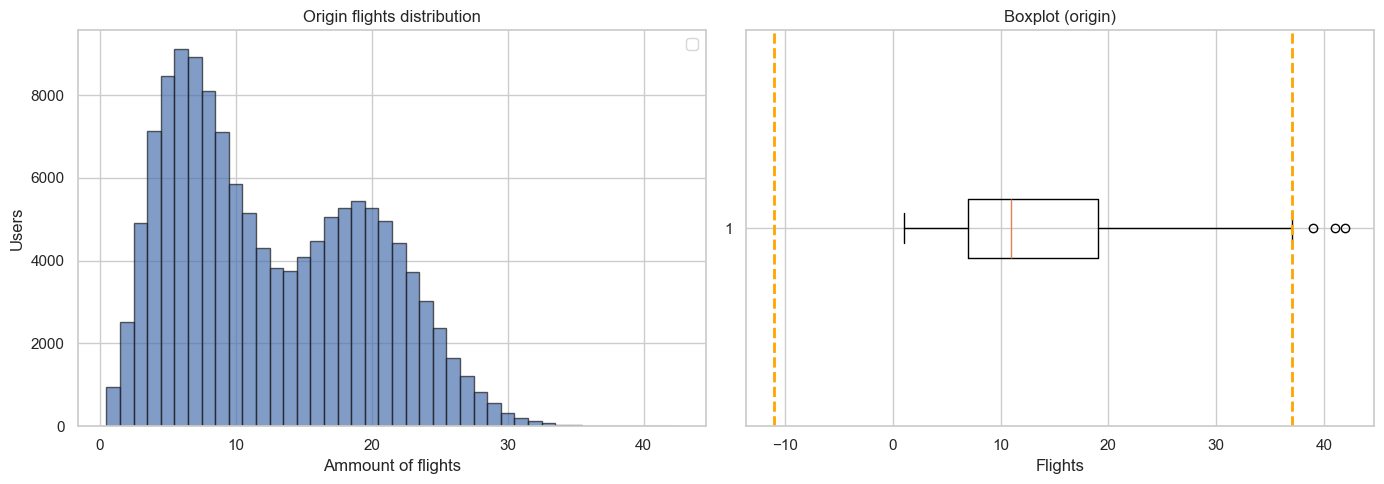

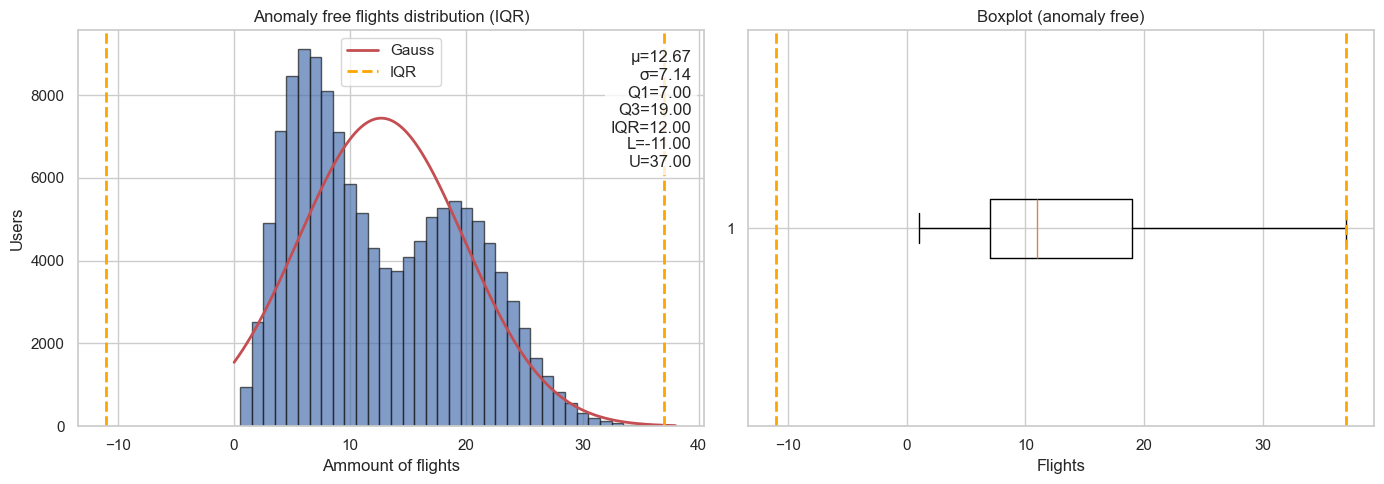

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

csv_path = 'csv/SkyTeam-Exchange.csv'

df = pd.read_csv(csv_path)
df = df.dropna(subset=['CODE'])

# Кол-во полетов на пользователя
flights_per_user = df.groupby('CODE').size().rename('flights')
distribution = flights_per_user.value_counts().sort_index()
distribution.to_csv('distribution_by_flights_per_user-iqr-yaml.csv', header=['users'])

# Функции для IQR
def iqr_stats(x, k=1.5):
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return q1, q3, iqr, lower, upper

def detect_iqr_outliers(series, k=1.5):
    x = series.values.astype(float)
    q1, q3, iqr, lower, upper = iqr_stats(x, k)
    mask = (x < lower) | (x > upper)
    return mask, {'q1': q1, 'q3': q3, 'iqr': iqr, 'lower': lower, 'upper': upper}

# Визуализация: исходные данные
data = flights_per_user.values
mu, sigma = norm.fit(data)
bins = np.arange(data.min(), data.max() + 2) - 0.5
bin_width = bins[1] - bins[0]

q1, q3, iqr, lower, upper = iqr_stats(data, k=1.5)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.hist(data, bins=bins, color='C0', alpha=0.7, edgecolor='k')
x = np.linspace(data.min() - 1, data.max() + 1, 500)
ax.set_xlabel('Ammount of flights')
ax.set_ylabel('Users')
ax.set_title('Origin flights distribution')
ax.legend()


axb = axes[1]
axb.boxplot(data, vert=False, showfliers=True)
axb.axvline(lower, color='orange', ls='--', lw=2)
axb.axvline(upper, color='orange', ls='--', lw=2)
axb.set_title('Boxplot (origin)')
axb.set_xlabel('Flights')

plt.tight_layout()
plt.show()

# Итеративное удаление аномалий по IQR
k = 1.5
s = flights_per_user.copy()
anoms = []
it = 1
while True:
    mask, stats = detect_iqr_outliers(s, k=k)
    if not mask.any():
        break
    idx_out = s.index[mask]
    vals_out = s.values[mask]
    for nn, v in zip(idx_out, vals_out):
        anoms.append({
            'iteration': it,
            'CODE': nn,
            'flights': int(v),
            'q1': stats['q1'],
            'q3': stats['q3'],
            'iqr': stats['iqr'],
            'lower': stats['lower'],
            'upper': stats['upper'],
            'side': 'low' if v < stats['lower'] else 'high'
        })
    s = s[~s.index.isin(idx_out)]
    it += 1

anoms_df = pd.DataFrame(anoms)
if not anoms_df.empty:
    anoms_df.to_csv('anomalous_users_iqr-yaml.csv', index=False)
    df_cleaned = df[~df['CODE'].isin(anoms_df['CODE'])]
else:
    df_cleaned = df.copy()

df_cleaned.to_csv('csv/flights_cleaned_iqr-yaml.csv', index=False)

# Распределение и визуализация после очистки
flights_per_user_cleaned = df_cleaned.groupby('CODE').size().rename('flights')
distribution_cleaned = flights_per_user_cleaned.value_counts().sort_index()
distribution_cleaned.to_csv('csv/distribution_by_flights_per_user_cleaned_iqr-yaml.csv', header=['users'])

data2 = flights_per_user_cleaned.values
mu2, sigma2 = norm.fit(data2)
bins2 = np.arange(data2.min(), data2.max() + 2) - 0.5
bin_width2 = bins2[1] - bins2[0]

q1c, q3c, iqrc, lowerc, upperc = iqr_stats(data2, k=k)

fig2, axes2 = plt.subplots(1, 2, figsize=(14, 5))
ax2 = axes2[0]
ax2.hist(data2, bins=bins2, color='C0', alpha=0.7, edgecolor='k')
x2 = np.linspace(data2.min() - 1, data2.max() + 1, 500)
if sigma2 > 0:
    y2 = norm.pdf(x2, mu2, sigma2) * len(data2) * bin_width2
    ax2.plot(x2, y2, 'r-', lw=2, label='Gauss')
ax2.axvline(lowerc, color='orange', ls='--', lw=2, label='IQR')
ax2.axvline(upperc, color='orange', ls='--', lw=2)
ax2.set_xlabel('Ammount of flights')
ax2.set_ylabel('Users')
ax2.set_title('Anomaly free flights distribution (IQR)')
ax2.legend()
ax2.text(0.98, 0.95,
         f'μ={mu2:.2f}\nσ={sigma2:.2f}\nQ1={q1c:.2f}\nQ3={q3c:.2f}\nIQR={iqrc:.2f}\nL={lowerc:.2f}\nU={upperc:.2f}',
         transform=ax2.transAxes, ha='right', va='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

axb2 = axes2[1]
axb2.boxplot(data2, vert=False, showfliers=True)
axb2.axvline(lowerc, color='orange', ls='--', lw=2)
axb2.axvline(upperc, color='orange', ls='--', lw=2)
axb2.set_title('Boxplot (anomaly free)')
axb2.set_xlabel('Flights')

plt.tight_layout()
plt.show()

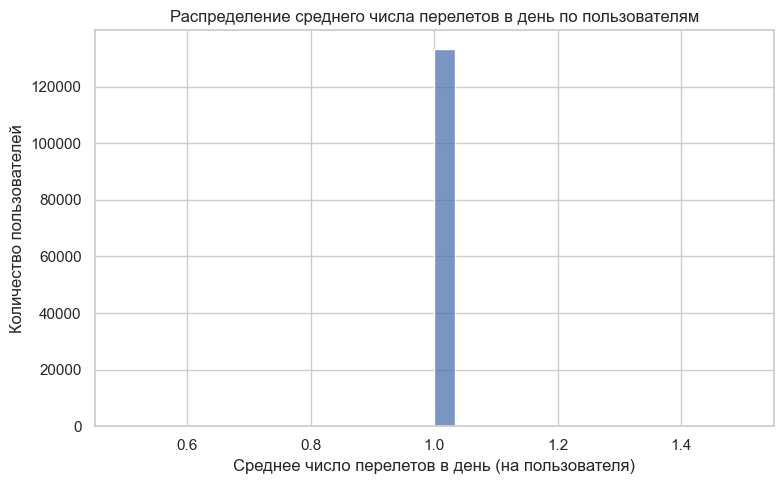

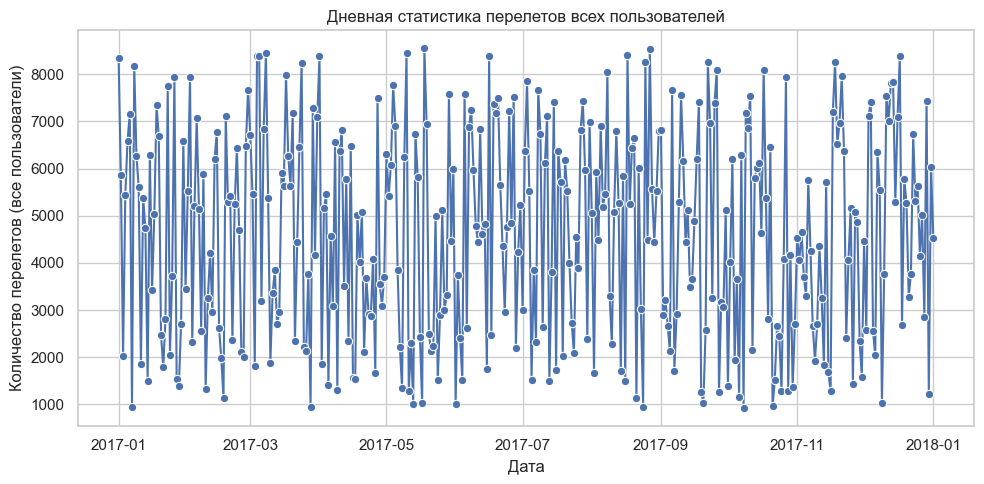

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

input_path = "csv/SkyTeam-Exchange.csv"

df = pd.read_csv(input_path)
df = df.dropna(subset=["CODE", "DATE"])
df["DATE"] = pd.to_datetime(df["DATE"])
df["CODE"] = df["CODE"].astype(str).str.strip()

per_user_day = (
    df.groupby(["CODE", "DATE"])
    .size()
    .rename("flights_per_day")
    .reset_index()
)

avg_per_user = (
    per_user_day.groupby("CODE")["flights_per_day"]
    .mean()
    .rename("avg_flights_per_day")
    .reset_index()
)

plt.figure(figsize=(8, 5))
sns.histplot(avg_per_user["avg_flights_per_day"], bins=30)
plt.xlabel("Среднее число перелетов в день (на пользователя)")
plt.ylabel("Количество пользователей")
plt.title("Распределение среднего числа перелетов в день по пользователям")
plt.tight_layout()
plt.show()

daily_total = df.groupby("DATE").size().rename("flights_total").reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=daily_total, x="DATE", y="flights_total", marker="o")
plt.xlabel("Дата")
plt.ylabel("Количество перелетов (все пользователи)")
plt.title("Дневная статистика перелетов всех пользователей")
plt.tight_layout()
plt.show()

In [14]:
import pandas as pd

csv_in = 'csv/FrequentFlyerForum-Profiles-pars2-cleaned.csv'
csv_out = 'csv/flights_filtered.csv'
nicknames_to_remove = ['FrequentFlyer29897', 'FrequentFlyer71993']

df = pd.read_csv(csv_in)
df_filtered = df[~df['NICKNAME'].astype(str).isin(nicknames_to_remove)]
df_filtered.to_csv(csv_out, index=False)

In [15]:
import pandas as pd

csv_in = 'csv/SkyTeam-Exchange-cleaned.csv'
csv_out = 'csv/flights_skyteam_filtered.csv'
nicknames_to_remove = ['KE 532721450', 'FB 139888197', 'DT 288881849', 'KE 757384867', 'DT 298868326', 'SU 446648304']

df = pd.read_csv(csv_in)
df_filtered = df[~df['CODE'].astype(str).isin(nicknames_to_remove)]
df_filtered.to_csv(csv_out, index=False)

In [ ]:
import pandas as pd

# Загрузка данных через cuDF для работы на GPU
try:
    df1 = cudf.read_csv('data/FrequentFlyerForum-Profiles-pars2-cleaned.csv')
    df2 = cudf.read_csv('data/SkyTeam-Exchange-cleaned.csv')
    print("Данные загружены через cuDF (GPU)")
except Exception as e:
    print(f"Ошибка загрузки через cuDF: {e}")
    df1 = pd.read_csv('csv/flights_skyteam_filtered.csv')
    df2 = pd.read_csv('csv/flights_filtered.csv')
    print("Данные загружены через pandas (CPU)")

# Проверка типов данных
print(f"Тип df1: {type(df1)}")
print(f"Тип df2: {type(df2)}")

# Объединение данных по общим столбцам
'''if isinstance(df1, cudf.DataFrame) and isinstance(df2, cudf.DataFrame):
    # Объединение на GPU
    merged_df = cudf.merge(df1, df2, on=['DATE', 'FLIGHT', 'FROM', 'TO', 'CODE'], how='inner')
    print("Объединение выполнено на GPU")
else:'''
# Объединение на CPU
merged_df = pd.merge(df1, df2, on=['DATE', 'FLIGHT', 'FROM', 'TO', 'CODE'], how='outer')
print("Объединение выполнено на CPU")

# Просмотр результата
print(f"Размер объединенного датафрейма: {merged_df.shape}")
print("\nПервые 5 строк:")
print(merged_df.head())


Ошибка загрузки через cuDF: name 'cudf' is not defined
Данные загружены через pandas (CPU)
Тип df1: <class 'pandas.core.frame.DataFrame'>
Тип df2: <class 'pandas.core.frame.DataFrame'>
Объединение выполнено на CPU
Размер объединенного датафрейма: (2550727, 16)

Первые 5 строк:
         DATE  FLIGHT FROM   TO          CODE CLASS    FARE  \
0  2017-01-01  AF1145  SVO  CDG  FB 520518073     Y  YRSTFN   
1  2017-01-01  AF1844  SVO  CDG  DT 425998795   NaN     NaN   
2  2017-01-01  AF1844  SVO  CDG   FB 18427809     Y  YGRPZR   
3  2017-01-01  AF1844  SVO  CDG  KE 206575495   NaN     NaN   
4  2017-01-01  AF1844  SVO  CDG  SU 363105640   NaN     NaN   

             NICKNAME     SEX REAL_NAME_LAST_NAME REAL_NAME_FIRST_NAME  \
0  FrequentFlyer60777  Female                 NaN                  NaN   
1  FrequentFlyer99821  Female                 NaN                  NaN   
2  FrequentFlyer99821  Female                 NaN                  NaN   
3  FrequentFlyer99821  Female                 N

In [ ]:

output_file = 'csv/GOLDEN_CSV_SHOWER/merged_resultST+FF-outer.csv'

if hasattr(merged_df, 'to_csv'):
    merged_df.to_csv(output_file, index=False)
else:
    merged_df.to_pandas().to_csv(output_file, index=False)

print(f"Результат сохранен в: {output_file}")

Результат сохранен в: csv/GOLDEN_CSV_SHOWER/merged_resultST+FF-outer.csv


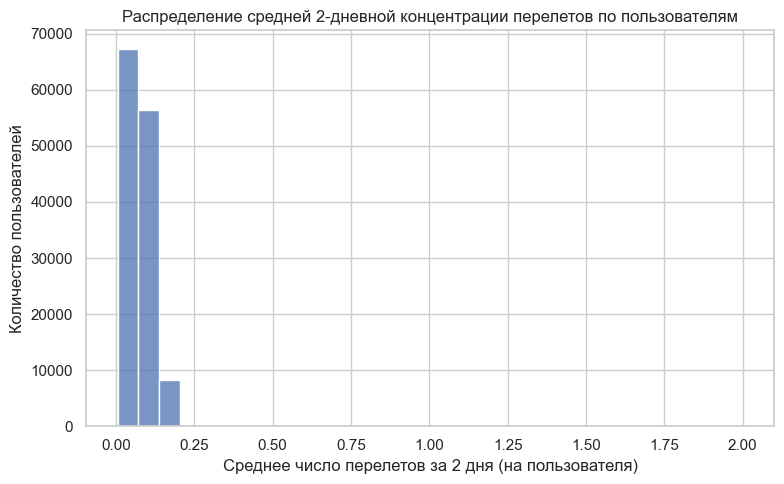

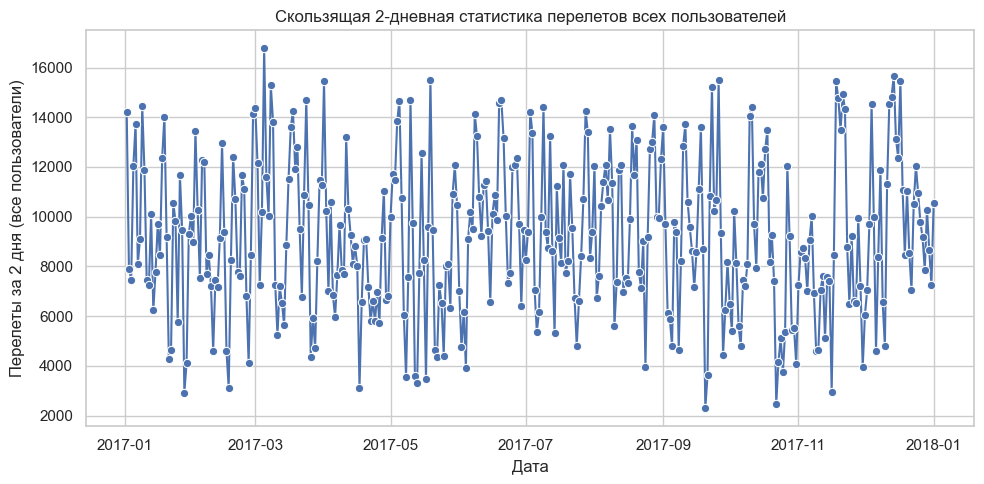

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

input_path = "csv/SkyTeam-Exchange-cleaned.csv"

df = pd.read_csv(input_path)
df = df.dropna(subset=["CODE", "DATE"])
df["DATE"] = pd.to_datetime(df["DATE"])
df["CODE"] = df["CODE"].astype(str).str.strip()

per_user_day = (
    df.groupby(["CODE", "DATE"])
    .size()
    .rename("flights_per_day")
    .reset_index()
)

def mean_2day_sum(s):
    idx = pd.date_range(s.index.min(), s.index.max(), freq="D")
    s_full = s.reindex(idx, fill_value=0)
    rsum2 = s_full.rolling(window=2, min_periods=2).sum()
    return rsum2.mean()

avg_2day = (
    per_user_day.set_index("DATE")
    .groupby("CODE")["flights_per_day"]
    .apply(mean_2day_sum)
    .rename("avg_flights_per_2days")
    .reset_index()
    .dropna(subset=["avg_flights_per_2days"])
)

plt.figure(figsize=(8, 5))
sns.histplot(avg_2day["avg_flights_per_2days"], bins=30)
plt.xlabel("Среднее число перелетов за 2 дня (на пользователя)")
plt.ylabel("Количество пользователей")
plt.title("Распределение средней 2-дневной концентрации перелетов по пользователям")
plt.tight_layout()
plt.show()

daily_total = (
    df.groupby("DATE").size().rename("flights_total").to_frame()
    .reindex(pd.date_range(df["DATE"].min(), df["DATE"].max(), freq="D"), fill_value=0)
)

daily_total["flights_total_2d"] = daily_total["flights_total"].rolling(window=2, min_periods=2).sum()
daily_total = daily_total.reset_index().rename(columns={"index": "DATE"})

plt.figure(figsize=(10, 5))
sns.lineplot(data=daily_total, x="DATE", y="flights_total_2d", marker="o")
plt.xlabel("Дата")
plt.ylabel("Перелеты за 2 дня (все пользователи)")
plt.title("Скользящая 2-дневная статистика перелетов всех пользователей")
plt.tight_layout()
plt.show()

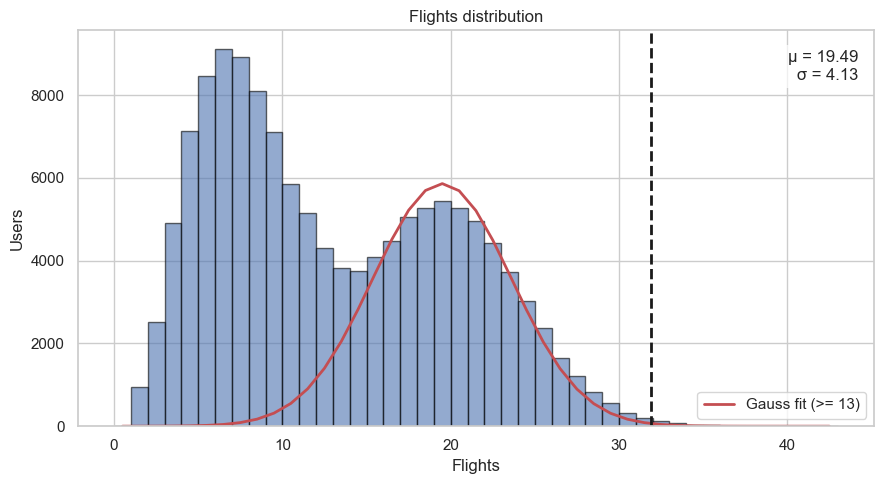

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

input_path = "csv/SkyTeam-Exchange-cleaned.csv"
outliers_path = "csv/SkyTeam-Exchange-sus_pidorases.csv"

df = pd.read_csv(input_path)
df = df.dropna(subset=["CODE"])
df["CODE"] = df["CODE"].astype(str).str.strip()

per_user_total = (
    df.groupby("CODE")
    .size()
    .rename("flights_total")
    .reset_index()
)

x = per_user_total["flights_total"].values
threshold = 13
tail = x[x >= threshold]
if len(tail) < 2:
    raise ValueError("Недостаточно данных для фита от 15 перелетов (нужно >= 2 пользователей).")

mu, sigma = norm.fit(tail)

bins = np.arange(0, x.max() + 2, 1)
bin_width = 1.0
plt.figure(figsize=(9, 5))
plt.hist(x, bins=bins, edgecolor="black", alpha=0.6)
centers = (bins[:-1] + bins[1:]) / 2
pdf = norm.pdf(centers, mu, sigma) * len(tail) * bin_width
plt.plot(centers, pdf, "r-", linewidth=2, label=f"Gauss fit (>= {threshold})")

plt.xlabel("Flights")
plt.ylabel("Users")
plt.title("Flights distribution")
plt.legend()
plt.text(0.98, 0.95, f"μ = {mu:.2f}\nσ = {sigma:.2f}", transform=plt.gca().transAxes,
         ha="right", va="top", bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"))
plt.tight_layout()
upper = mu + 3 * sigma
plt.axvline(upper, color="k", linestyle="--", linewidth=2, label=f"Порог 3σ: {upper:.2f}")
plt.show()
outliers = per_user_total[per_user_total["flights_total"] >= upper].copy()
outliers["zscore"] = (outliers["flights_total"] - mu) / sigma
outliers.sort_values("flights_total", ascending=False).to_csv(outliers_path, index=False)

In [46]:
import pandas as pd

# Читаем CSV файл
df = pd.read_csv('csv/BoardingData.csv', sep=';')

# Преобразуем все в строки и убираем лишние пробелы
df['PassengerDocument'] = df['PassengerDocument'].astype(str).str.strip()
df['PassengerFirstName'] = df['PassengerFirstName'].astype(str).str.strip()
df['PassengerLastName'] = df['PassengerLastName'].astype(str).str.strip()
df['PassengerSecondName'] = df['PassengerSecondName'].astype(str).str.strip()

# Убираем записи где документ "Not presented"
df = df[df['PassengerDocument'] != 'Not presented']

# Находим дубликаты по документу с разными именами/фамилиями
result_records = []

# Группируем по документу
for doc, group in df.groupby('PassengerDocument'):
    if len(group) > 1:
        # Получаем уникальные комбинации имени и фамилии
        unique_names = group[['PassengerFirstName', 'PassengerLastName']].drop_duplicates()
        
        # Если для одного документа есть разные имена/фамилии
        if len(unique_names) > 1:
            # ДОБАВЛЯЕМ ВСЕХ ЧУВАКОВ С ЭТИМ ПАСПОРТОМ
            for _, record in group.iterrows():
                result_records.append({
                    'PassengerDocument': record['PassengerDocument'],
                    'PassengerFirstName': record['PassengerFirstName'],
                    'PassengerSecondName': record['PassengerSecondName'],
                    'PassengerLastName': record['PassengerLastName'],
                    'PassengerSex': record['PassengerSex'],
                    'PassengerBirthDate': record['PassengerBirthDate']
                })

# Создаем DataFrame с результатами
if result_records:
    result_df = pd.DataFrame(result_records)
    
    # Сохраняем в CSV
    result_df.to_csv('csv/duplicate_documents_different_names.csv', index=False, sep=';')
    
    print(f"Найдено {len(result_df)} записей с документами, у которых разные имена/фамилии")
    print("Результат сохранен в 'duplicate_documents_different_names.csv'")
    
    # Показываем группировку по документам
    print("\nНайденные документы с разными ФИО:")
    for doc in result_df['PassengerDocument'].unique():
        doc_group = result_df[result_df['PassengerDocument'] == doc]
        print(f"\nДокумент: {doc}")
        for _, row in doc_group.iterrows():
            print(f"  - {row['PassengerFirstName']} {row['PassengerSecondName']} {row['PassengerLastName']}")
else:
    print("Документов с разными именами/фамилиями не найдено")

Найдено 4 записей с документами, у которых разные имена/фамилии
Результат сохранен в 'duplicate_documents_different_names.csv'

Найденные документы с разными ФИО:

Документ: 8248 013778
  - GORDEI M. GLEBOV
  - GORDEI M. GLEBOV
  - GORDEI MAKAREVICH GLEBOV
  - RAMIL ALBERTOVICH BUROV


In [ ]:
import os
import glob
from pathlib import Path
import csv
import datetime as dt
import fnmatch
import openpyxl

# Каталог с файлами и шаблон имён
INPUT_DIR = "YourBoardingPassDotAero/"  
PATTERN = "YourBoardingPassDotAero-*.xlsx"

OUTPUT_CSV = "YourBoardingPassDotAero-ALL.csv"

def _cell_value(ws, coord):
    c = ws[coord]
    v = c.value
    if v is None:
        for rng in ws.merged_cells.ranges:
            if coord in rng:
                v = ws.cell(row=rng.min_row, column=rng.min_col).value
                break
    if isinstance(v, (dt.date, dt.datetime)):
        return v.isoformat()
    return v

def _ordered_union(*dicts):
    seen = set()
    res = []
    for d in dicts:
        for v in d.values():
            if v not in seen:
                seen.add(v)
                res.append(v)
    return res

def _filter_sheets(all_names, include=None, exclude=None):
    def match_any(name, patterns):
        return any(fnmatch.fnmatch(name, p) for p in patterns)
    names = list(all_names)
    if include:
        names = [n for n in names if match_any(n, include)]
    if exclude:
        names = [n for n in names if not match_any(n, exclude)]
    return names

def extract_from_workbook_many(xlsx_path, mapping_default, mapping_overrides=None,
                               include=None, exclude=None, mode="rows_per_sheet"):
    mapping_overrides = mapping_overrides or {}
    wb = openpyxl.load_workbook(xlsx_path, data_only=True, read_only=False)
    sheets = _filter_sheets(wb.sheetnames, include, exclude)

    per_sheet_mapping = {}
    for s in sheets:
        m = dict(mapping_default)
        if s in mapping_overrides:
            m.update(mapping_overrides[s])
        if m:
            per_sheet_mapping[s] = m

    if not per_sheet_mapping:
        return [], []

    cols = _ordered_union(mapping_default, *[mapping_overrides.get(s, {}) for s in sheets])
    if mode == "rows_per_sheet":
        header = ["_sheet"] + cols
        rows = []
        for s, cell2col in per_sheet_mapping.items():
            row = {k: None for k in header}
            row["_sheet"] = s
            ws = wb[s]
            for coord, col in cell2col.items():
                try:
                    row[col] = _cell_value(ws, coord)
                except Exception:
                    row[col] = None
            rows.append(row)
        return header, rows

    if mode == "single_row_merged":
        header = cols
        row = {k: None for k in header}
        for s, cell2col in per_sheet_mapping.items():
            ws = wb[s]
            for coord, col in cell2col.items():
                if row[col] not in (None, ""):
                    continue
                try:
                    v = _cell_value(ws, coord)
                except Exception:
                    v = None
                if v not in (None, ""):
                    row[col] = v
        return header, [row]

    raise ValueError("Unknown MODE")

def write_csv(path, header, rows):
    p = Path(path)
    p.parent.mkdir(parents=True, exist_ok=True)
    with p.open("w", newline="", encoding="utf-8-sig") as f:
        w = csv.DictWriter(f, fieldnames=header, extrasaction="ignore")
        w.writeheader()
        for r in rows:
            w.writerow({k: r.get(k) for k in header})

# Режим записи: "rows_per_sheet" — по строке на лист; "single_row_merged" — одна строка
MODE = "rows_per_sheet"


SHEET_INCLUDE = []         
SHEET_EXCLUDE = []     

# Базовое сопоставление применится к каждому листу
MAPPING_DEFAULT = {
    "B3": "Name",
    "A5": "FlightNumber",
    "D7": "DepartureCode",
    "D5": "DepartureCity",
    "H7": "ArrivalCode",
    "H5": "ArrivalCity",
    "A3": "Sex",
    "F3": "Loyality",
    "A9": "Date",
    "C9": "Time",
    "E9": "CodeShare",
    "B7": "Gate",
    "E13": "TicketNumber",
    "H11": "Seat",
    "B13": "Fare",
    "H3": "Class"
}

# Переопределения/дополнения для конкретных листов
MAPPING_OVERRIDES = {}

xlsx_files = sorted(glob.glob(os.path.join(INPUT_DIR, PATTERN)))
if not xlsx_files:
    print(f"Файлы не найдены по шаблону: {os.path.join(INPUT_DIR, PATTERN)}")
    raise SystemExit(1)

all_rows = []
final_header = None
total_sheets = 0

for EXCEL_PATH in xlsx_files:
    header, data_rows = extract_from_workbook_many(
        EXCEL_PATH,
        MAPPING_DEFAULT,
        mapping_overrides=MAPPING_OVERRIDES,
        include=SHEET_INCLUDE,
        exclude=SHEET_EXCLUDE,
        mode=MODE,
    )
    if not data_rows:
        continue

    if final_header is None:
        final_header = header
    elif header != final_header:
        raise ValueError(f"Несовпадение заголовков в файле {EXCEL_PATH}")

    all_rows.extend(data_rows)
    total_sheets += len(data_rows)

if not final_header:
    print("Нет данных для записи.")
    raise SystemExit(0)

write_csv(OUTPUT_CSV, final_header, all_rows)
print(f"Готово: {OUTPUT_CSV}, файлов: {len(xlsx_files)}, строк: {len(all_rows)}")

Готово: YourBoardingPassDotAero-ALL.csv, файлов: 365, строк: 612826


In [ ]:
import pandas as pd


file1 = 'csv/YourBoardingPassDotAero-2017-01-01.csv'
file2 = 'csv/YourBoardingPassDotAero.csv'
output_file = 'csv/YourBoardingPassDotAero-ALL.csv'

# Чтение обоих CSV-файлов
df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

# Объединение по строкам (вертикально)
combined_df = pd.concat([df1, df2], ignore_index=True)

# Сохранение результата
combined_df.to_csv(output_file, index=False)

print(f'Файлы объединены в {output_file}')

Файлы объединены в csv/YourBoardingPassDotAero-ALL.csv


In [ ]:
#!/usr/bin/env python3
# clean_and_split_names.py
"""
Удаляет одиночные символы/инициалы из столбца 'Name' и разбивает результат
на два столбца: 'name' (первое слово) и 'lastname' (все последующие слова).
Регистр НЕ меняется (CAPS остаются CAPS).
"""

import re
import pandas as pd

def is_single_char(token: str) -> bool:
    """True если после удаления небукв остаётся ровно 1 буква."""
    if token is None:
        return False
    t = str(token).strip()
    if t == "":
        return False
    cleaned = re.sub(r"[^A-Za-zА-Яа-яЁё']", "", t)
    return len(cleaned) == 1

def strip_edge_punct(token: str) -> str:
    """Убирает краевую пунктуацию (запятые, точки, ;)"""
    if token is None:
        return ""
    return token.strip(" ,.;:")

def remove_single_symbols_from_name(name: str) -> str:
    """Удаляет одиночные символы/инициалы из строки name, не меняя регистр."""
    if not isinstance(name, str):
        return name if name is not None else ""
    s = name.strip()
    if not s:
        return ""
    parts = s.split()
    parts = [p for p in parts if not is_single_char(p)]
    parts = [strip_edge_punct(p) for p in parts if strip_edge_punct(p) != ""]
    return " ".join(parts)

def split_to_two(name_cleaned: str):
    """
    Разделяет очищенную строку на (name, lastname):
      - если пусто -> ("", "")
      - если одно слово -> (word, "")
      - если >=2 слов -> (первое, остальные через пробел)
    Регистр и порядок слов сохраняются.
    """
    if not isinstance(name_cleaned, str) or name_cleaned.strip() == "":
        return "", ""
    tokens = name_cleaned.split()
    if len(tokens) == 1:
        return tokens[0], ""
    else:
        return tokens[0], " ".join(tokens[1:])

def process_csv(input_csv: str, output_csv: str, name_col: str = "Name"):
    # читаем как строки, чтобы не терять формат
    df = pd.read_csv(input_csv, dtype=str, encoding="utf-8", keep_default_na=False)

    if name_col not in df.columns:
        raise KeyError(f"Столбца '{name_col}' нет в CSV. Доступные столбцы: {df.columns.tolist()}")

    # 1) очистка
    df["_name_cleaned_temp"] = df[name_col].apply(remove_single_symbols_from_name)

    # 2) разбиение
    df["name"], df["lastname"] = zip(*df["_name_cleaned_temp"].apply(split_to_two))

    # 3) можно также заменить оригинальный столбец Name очищенной версией, если нужно:
    df[name_col] = df["_name_cleaned_temp"]

    # удалим временный столбец
    df = df.drop(columns=["_name_cleaned_temp"])
    df = df.drop(columns=[name_col])
    df = df.drop(columns=['Seat', 'Gate', 'CodeShare', '_sheet'])

    # 4) переставим колонки: сначала name, lastname, затем остальные в исходном порядке (без дубликатов)
    other_cols = [c for c in df.columns if c not in ("name", "lastname")]
    new_order = ["name", "lastname"] + other_cols
    df = df.reindex(columns=new_order)

    # сохраняем
    df.to_csv(output_csv, index=False, encoding="utf-8")
    print(f"Сохранено: {output_csv}")

if __name__ == "__main__":
    input_file = "csv/YourBoardingPassDotAero-ALL.csv"
    output_file = "csv/YourBoardingPassDotAero-ALL-ULTRAFINE.csv"
    process_csv(input_file, output_file)

Сохранено: csv/YourBoardingPassDotAero-ALL-ULTRAFINE.csv


In [44]:
import csv

input_file = "csv/YourBoardingPassDotAero-ALL-ULTRAFINE.csv"
out_tickets = 'duplicates_ticketnumber.csv'
out_loyality = 'duplicates_loyality.csv'

with open(input_file, newline='', encoding='utf-8-sig') as f:
    reader = csv.DictReader(f)
    rows = list(reader)
    headers = reader.fieldnames or []

def collect_duplicates(rows, key):
    empty = 0
    groups = {}
    for row in rows:
        v = (row.get(key) or '').strip()
        if v:
            groups.setdefault(v, []).append(row)
        else:
            empty+=1
    result = []
    for v, items in groups.items():
        if len(items) > 1:
            result.extend(items)
    print("Empty values in", key, " = ", empty)
    return result

def write_csv(path, headers, rows):
    with open(path, 'w', newline='', encoding='utf-8-sig') as f:
        w = csv.DictWriter(f, fieldnames=headers)
        w.writeheader()
        w.writerows(rows)

write_csv(out_tickets, headers, collect_duplicates(rows, 'TicketNumber'))
write_csv(out_loyality, headers, collect_duplicates(rows, 'Loyality'))

Empty values in TicketNumber  =  0
Empty values in Loyality  =  484730


In [50]:
#!/usr/bin/env python3
import argparse
import re
from collections import Counter, defaultdict

import pandas as pd
from tqdm import tqdm


def normalize_token(s: str) -> str:
    if s is None:
        return ""
    s = str(s).strip()
    s = s.replace("’", "'").replace("‘", "'").replace("`", "'").replace("ʼ", "'").replace("ʹ", "'").replace("′", "'").replace("‛", "'")
    s = s.replace("—", "-").replace("–", "-")
    s = re.sub(r"\s+", " ", s)
    s = s.upper()
    s = s.replace("'", "").replace("-", "")
    return s


GIVEN_NAMES = {
    # Частые имена (рус/анг транслит, верхний регистр, без апострофов/дефисов после нормализации)
    "ALEKSEY", "ALEXEY", "ALEXEI", "ALEXANDER", "ALEKSANDR", "ALEKSANDER", "ALEXANDR",
    "ANDREY", "ANDREI", "DMITRY", "DMITRIY", "SERGEY", "SERGEI", "IVAN", "OLEG",
    "ROMAN", "PAVEL", "NIKITA", "NIKOLAY", "NIKOLAI", "ILLIA", "ILYA", "ILIA",
    "KONSTANTIN", "ARTEM", "ARTYOM", "ARTHUR", "MAKSIM", "MAXIM", "VLADIMIR",
    "VASILIY", "VASILY", "YURI", "YURII", "YURIY", "GEORGY", "GEORGIY", "EGOR",
    "FYODOR", "FJODOR", "FEDOR", "FIODOR", "Fedor".upper(),
    "ILDAR", "ILDAR".upper(), "ILDAR".upper(), "ILDUS",
    "ALBINA", "ALINA", "ALINA".upper(), "ALBINA".upper(),
    "LIANA", "LIANA".upper(),
    "SNEZHANA", "SNEJANA", "SNEZHANA".upper(),
    "OLESIA", "OLESYA", "OLESA", "OLESYA".upper(), "OLESIA".upper(),
    "VITALINA", "VITALINA".upper(),
    "Fedor".upper(), "Liana".upper(), "Albina".upper(), "Snezhana".upper(),
    # Другие
    "ANNA", "MARIA", "MARIYA", "MARYA", "POLINA", "NATALIA", "NATALIYA", "NATALYA", "NATALIA".upper(),
    "ELENA", "YELENA", "OLGA", "IRINA", "TATIANA", "TATYANA", "EKATERINA", "KATERINA",
    "KSENIA", "XENIA", "KIRA", "DIANA",
}

SURNAME_SUFFIXES = (
    "OV", "OVA", "EV", "EVA", "IN", "INA", "ICH", "ENKO", "IENKO", "YENKO",
    "SKY", "SKIY", "SKII", "SKI", "SKAYA", "ZKY", "ZKI", "TSKY", "TSKIY",
    "YAN", "IAN"
)


def is_likely_surname(tok: str) -> bool:
    return any(tok.endswith(suf) for suf in SURNAME_SUFFIXES)


def choose_canonical_for_group(df_group: pd.DataFrame) -> tuple[str, str]:
    pairs = []
    norm_to_raws = defaultdict(Counter)

    for _, row in df_group.iterrows():
        n_raw = row.get("name", "")
        l_raw = row.get("lastname", "")
        n_norm = normalize_token(n_raw)
        l_norm = normalize_token(l_raw)
        pairs.append((n_norm, l_norm, n_raw, l_raw))
        if n_norm:
            norm_to_raws[n_norm][n_raw] += 1
        if l_norm:
            norm_to_raws[l_norm][l_raw] += 1

    pair_counts = Counter((p[0], p[1]) for p in pairs)
    top_pair, top_count = ("", ""), 0
    if pair_counts:
        top_pair, top_count = pair_counts.most_common(1)[0]
    swapped_count = pair_counts.get((top_pair[1], top_pair[0]), 0)

    tokens = set()
    for p in pairs:
        if p[0]:
            tokens.add(p[0])
        if p[1]:
            tokens.add(p[1])

    given_norm, surname_norm = None, None
    if top_count > swapped_count and top_pair != ("", ""):
        given_norm, surname_norm = top_pair
    else:
        if len(tokens) == 2:
            a, b = list(tokens)
            a_is_given = a in GIVEN_NAMES
            b_is_given = b in GIVEN_NAMES
            if a_is_given ^ b_is_given:
                given_norm = a if a_is_given else b
                surname_norm = b if a_is_given else a
            else:
                col1_counts = Counter(p[0] for p in pairs)
                col2_counts = Counter(p[1] for p in pairs)
                if col2_counts[a] > col2_counts[b]:
                    surname_norm, given_norm = a, b
                elif col2_counts[b] > col2_counts[a]:
                    surname_norm, given_norm = b, a
                else:
                    a_surname = is_likely_surname(a)
                    b_surname = is_likely_surname(b)
                    if a_surname ^ b_surname:
                        surname_norm = a if a_surname else b
                        given_norm = b if a_surname else a
                    else:
                        given_norm, surname_norm = min(a, b), max(a, b)
        else:
            if top_pair != ("", ""):
                given_norm, surname_norm = top_pair
            else:
                # Пустые/битые данные
                given_norm = ""
                surname_norm = ""

    given_raw = norm_to_raws[given_norm].most_common(1)[0][0] if given_norm in norm_to_raws and norm_to_raws[given_norm] else ""
    surname_raw = norm_to_raws[surname_norm].most_common(1)[0][0] if surname_norm in norm_to_raws and norm_to_raws[surname_norm] else ""

    return given_raw, surname_raw


def process(input_csv: str, output_csv: str, encoding: str = "utf-8-sig") -> None:
    df = pd.read_csv(input_csv, dtype=str, encoding=encoding)
    if "name" not in df.columns or "lastname" not in df.columns or "Loyality" not in df.columns:
        raise ValueError("Ожидаются столбцы: name, lastname, Loyality")

    df["name"] = df["name"].astype(str)
    df["lastname"] = df["lastname"].astype(str)
    df["Loyality"] = df["Loyality"].astype(str)

    groups = df.groupby("Loyality", sort=False).groups
    pbar = tqdm(total=len(df), desc="Приведение ФИО", unit="зап")
    for loy, idx in groups.items():
        sub = df.loc[idx, ["name", "lastname"]]
        given_raw, surname_raw = choose_canonical_for_group(sub)
        if given_raw or surname_raw:
            df.loc[idx, "name"] = given_raw
            df.loc[idx, "lastname"] = surname_raw
        pbar.update(len(idx))
    pbar.close()

    df.to_csv(output_csv, index=False, encoding=encoding)


def main():
    process("duplicates_loyality.csv", "duplicates_loyality-UNIFY.csv", "utf-8-sig")


if __name__ == "__main__":
    main()

Приведение ФИО: 100%|██████████| 82114/82114 [01:26<00:00, 943.97зап/s] 


In [ ]:
import csv
from collections import defaultdict

input_filename = "csv/YourBoardingPassDotAero-ALL-ULTRAFINE.csv"
output_filename = "csv/YourBoardingPassDotAero-ALL-ULTRAFINE-NaN.csv"

# Словарь для группировки данных
grouped_data = defaultdict(list)

# Чтение и группировка данных
with open(input_filename, 'r', newline='', encoding='utf-8') as infile:
    reader = csv.DictReader(infile)
    
    for row in reader:
        # Проверяем пустое значение в столбце Loyality
        if not row.get('Loyality', '').strip():
            # Создаем ключ для группировки
            key = (row['name'], row['lastname'])
            grouped_data[key].append(row)

# Запись сгруппированных данных
with open(output_filename, 'w', newline='', encoding='utf-8') as outfile:
    # Определяем заголовки (включаем все исходные столбцы)
    if grouped_data:
        fieldnames = list(next(iter(grouped_data.values()))[0].keys())
        writer = csv.DictWriter(outfile, fieldnames=fieldnames)
        writer.writeheader()
        
        # Записываем все строки
        for group in grouped_data.values():
            for row in group:
                writer.writerow(row)

print(f"Готово! Найдено {len(grouped_data)} уникальных групп. Результат сохранен в {output_filename}")

# Дополнительная статистика
print("\nСтатистика по группам:")
for (name, lastname), rows in grouped_data.items():
    print(f"{name} {lastname}: {len(rows)} записей")

Готово! Найдено 133466 уникальных групп. Результат сохранен в csv/YourBoardingPassDotAero-ALL-ULTRAFINE-NaN.csv

Статистика по группам:
LIDIYA ZHDANOVA: 8 записей
SVIATOSLAV SOKOLOV: 3 записей
SVIATOSLAV SUKHANOV: 7 записей
DENIS ZELENIN: 11 записей
OSTROVSKAYA IRINA: 7 записей
ISAKOVA VERA: 7 записей
ZVYAGINTSEVA AL'BINA: 8 записей
ISAKOVA AL'BINA: 3 записей
ANTONINA KOROL'KOVA: 7 записей
ZOLOTOVA SVETLANA: 26 записей
ALEKSANDR VORONTSOV: 4 записей
TAMARA PLOTNIKOVA: 12 записей
INNA ZUBKOVA: 12 записей
SHMELEVA ELENA: 7 записей
MELANIIA IUDINA: 4 записей
TAMARA TITOVA: 2 записей
NATAL'YA KALACHEVA: 1 записей
GORBUNOVA IRINA: 15 записей
SHEVELEVA LYUBOV': 1 записей
PETROVSKAYA KARINA: 1 записей
ZVIAGINTSEV NIKOLAI: 1 записей
RUSTAM GUROV: 3 записей
PAVLOVSKII SAMIR: 3 записей
SVESHNIKOVA NATASHA: 17 записей
VORONOVA AMINA: 12 записей
GORBACHEV YURIY: 7 записей
ANZHELIKA PROKHOROVA: 21 записей
KARASEV ARSENIY: 6 записей
NINA TIKHOMIROVA: 2 записей
SELEZNEVA ANNA: 12 записей
SVYATOSLAV V

In [64]:
import csv
import argparse

APOSTROPHES = {"'", "’", "`"}

def en_to_ru(s):
    s = s.upper()
    res = []
    i = 0
    while i < len(s):
        chunk4 = s[i:i+4]
        chunk3 = s[i:i+3]
        chunk2 = s[i:i+2]

        if chunk4 == 'SHCH':
            res.append('Щ'); i += 4; continue
        if chunk3 == 'SCH':
            res.append('Щ'); i += 3; continue
        if chunk2 in ('YA', 'IA'):
            res.append('Я'); i += 2; continue
        if chunk2 in ('YU', 'IU'):
            res.append('Ю'); i += 2; continue
        if chunk2 in ('YO','IO'):
            res.append('Ё'); i += 2; continue
        if chunk2 == 'YE':
            res.append('Е'); i += 2; continue
        if chunk2 == 'EI':
            res.append('ЕЙ'); i += 2; continue
        if chunk2 == 'II':
            res.append('ИЙ'); i += 2; continue
        if chunk2 == 'AI':
            res.append('АЙ'); i += 2; continue
        if chunk2 == 'OI':
            res.append('ОЙ'); i += 2; continue
        if chunk2 == 'ZH':
            res.append('Ж'); i += 2; continue
        if chunk2 == 'KH':
            res.append('Х'); i += 2; continue
        if chunk2 == 'TS':
            res.append('Ц'); i += 2; continue
        if chunk2 == 'CH':
            res.append('Ч'); i += 2; continue
        if chunk2 == 'SH':
            res.append('Ш'); i += 2; continue

        ch = s[i]
        if ch in APOSTROPHES:
            res.append('Ь')
        elif ch == 'A':
            res.append('А')
        elif ch == 'B':
            res.append('Б')
        elif ch == 'C':
            res.append('К')
        elif ch == 'D':
            res.append('Д')
        elif ch == 'E':
            res.append('Е')
        elif ch == 'F':
            res.append('Ф')
        elif ch == 'G':
            res.append('Г')
        elif ch == 'H':
            res.append('Х')
        elif ch == 'I':
            res.append('И')
        elif ch == 'J':
            res.append('Й')
        elif ch == 'K':
            res.append('К')
        elif ch == 'L':
            res.append('Л')
        elif ch == 'M':
            res.append('М')
        elif ch == 'N':
            res.append('Н')
        elif ch == 'O':
            res.append('О')
        elif ch == 'P':
            res.append('П')
        elif ch == 'Q':
            res.append('К')
        elif ch == 'R':
            res.append('Р')
        elif ch == 'S':
            res.append('С')
        elif ch == 'T':
            res.append('Т')
        elif ch == 'U':
            res.append('У')
        elif ch == 'V':
            res.append('В')
        elif ch == 'W':
            res.append('В')
        elif ch == 'X':
            res.append('КС')
        elif ch == 'Y':
            res.append('Ы')
        elif ch == 'Z':
            res.append('З')
        else:
            res.append(ch)
        i += 1
    return ''.join(res)

def ru_to_en(s):
    res = []
    for ch in s:
        if ch == 'А':
            res.append('A')
        elif ch == 'Б':
            res.append('B')
        elif ch == 'В':
            res.append('V')
        elif ch == 'Г':
            res.append('G')
        elif ch == 'Д':
            res.append('D')
        elif ch == 'Е':
            res.append('E')
        elif ch == 'Ё':
            res.append('YO')
        elif ch == 'Ж':
            res.append('ZH')
        elif ch == 'З':
            res.append('Z')
        elif ch == 'И':
            res.append('I')
        elif ch == 'Й':
            res.append('Y')
        elif ch == 'К':
            res.append('K')
        elif ch == 'Л':
            res.append('L')
        elif ch == 'М':
            res.append('M')
        elif ch == 'Н':
            res.append('N')
        elif ch == 'О':
            res.append('O')
        elif ch == 'П':
            res.append('P')
        elif ch == 'Р':
            res.append('R')
        elif ch == 'С':
            res.append('S')
        elif ch == 'Т':
            res.append('T')
        elif ch == 'У':
            res.append('U')
        elif ch == 'Ф':
            res.append('F')
        elif ch == 'Х':
            res.append('KH')
        elif ch == 'Ц':
            res.append('TS')
        elif ch == 'Ч':
            res.append('CH')
        elif ch == 'Ш':
            res.append('SH')
        elif ch == 'Щ':
            res.append('SHCH')
        elif ch == 'Ъ':
            res.append('')
        elif ch == 'Ы':
            res.append('Y')
        elif ch == 'Ь':
            res.append('')
        elif ch == 'Э':
            res.append('E')
        elif ch == 'Ю':
            res.append('YU')
        elif ch == 'Я':
            res.append('YA')
        else:
            res.append(ch.upper())
    return ''.join(res).upper()

def normalize_field(value):
    if value is None:
        return value
    value = value.strip()
    if not value:
        return value
    ru = en_to_ru(value)
    en = ru_to_en(ru)
    return en.upper()

def _normalize_header(h):
    return (h or '').replace('\ufeff', '').strip().lower()

_NAME_KEYS = {'name', 'first', 'first name', 'firstname', 'given', 'given name', 'givenname'}
_LAST_KEYS = {'lastname', 'last', 'last name', 'surname', 'family', 'family name', 'familyname'}

def _detect_dialect(f):
    sample = f.read(8192)
    f.seek(0)
    try:
        return csv.Sniffer().sniff(sample, delimiters=[',',';','\t','|'])
    except csv.Error:
        class D(csv.excel): pass
        D.delimiter = ',' if ',' in sample else ';'
        return D

def process_csv(input_path, output_path):
    with open(input_path, 'r', encoding='utf-8-sig', newline='') as fin:
        dialect = _detect_dialect(fin)
        reader = csv.reader(fin, dialect)
        rows = list(reader)

    if not rows:
        with open(output_path, 'w', encoding='utf-8', newline='') as _:
            pass
        return

    header = rows[0]
    norm_header = [_normalize_header(h) for h in header]

    idx_name = None
    idx_lastname = None

    # exact first
    for i, k in enumerate(norm_header):
        if k == 'name':
            idx_name = i
        if k == 'lastname':
            idx_lastname = i

    # fallbacks
    if idx_name is None:
        for i, k in enumerate(norm_header):
            if k in _NAME_KEYS:
                idx_name = i
                break
    if idx_lastname is None:
        for i, k in enumerate(norm_header):
            if k in _LAST_KEYS:
                idx_lastname = i
                break

    if idx_name is None or idx_lastname is None:
        raise ValueError(f'CSV must contain "name" and "lastname" columns. Found: {norm_header}')
    out_rows = [header]
    for row in rows[1:]:
        if not row:
            out_rows.append(row)
            continue
        row = list(row)
        if idx_name < len(row) and row[idx_name] is not None:
            row[idx_name] = normalize_field(row[idx_name])
        if idx_lastname < len(row) and row[idx_lastname] is not None:
            row[idx_lastname] = normalize_field(row[idx_lastname])
        out_rows.append(row)

    with open(output_path, 'w', encoding='utf-8', newline='') as fout:
        writer = csv.writer(fout, dialect)
        writer.writerows(out_rows)

if __name__ == "__main__":
    process_csv("csv/YourBoardingPassDotAero-ALL-ULTRAFINE.csv", "csv/YourBoardingPassDotAero-ALL-ULTRAFINE-UNIFY.csv")
    

*НАШ ЛЮТЫЙ МЕРДЖ БЕЗ ПОЛОСОЧКИ*

In [2]:
df = pd.read_csv("csv/BoardingData-UNIFY.csv", sep= ';')
df.head()

df = df.drop(columns=['PassengerSecondName'])
df.head()

df1 = df

df2 = pd.read_csv("csv/YourBoardingPassDotAero-ALL-ULTRAFINE-UNIFY.csv")

df1.head()

name   lastname PassengerSex PassengerBirthDate PassengerDocument  \
0    SAVELIY    RUSANOV         Male         03/10/1983       2879 096860   
1        LEV      ISAEV         Male         12/13/1975       1788 173211   
2    NIKOLAY  NIKOLSKIY         Male         12/26/1990       4396 926588   
3   ANATOLIY     SHILOV         Male         05/24/1997       2595 919752   
4  MIROSLAVA   SEMENOVA       Female         01/31/1976       6775 516990   

     BookingCode      TicketNumber     Baggage  FlightDate FlightTime  \
0         FRNINO  6625956945991971     Transit  2017-03-22      06:05   
1  Not presented  1643715499224676  Registered  2017-03-18      22:10   
2         VWNYGF  6247422701565929     Transit  2017-03-18      22:10   
3         WQFFUE     Not presented  Registered  2017-03-18      22:10   
4  Not presented     Not presented  Registered  2017-03-12      11:45   

  FlightNumber CodeShare Destination  
0       SU1369       Own      Moscow  
1       SU1180       Own   Volgograd  
2       SU1180       Own   Volgograd  
3       SU1180       Own   Volgograd  
4       SU6284       Own      Moscow

In [3]:
df2.head()

name  lastname FlightNumber DepartureCode DepartureCity ArrivalCode  \
0       LIDIYA  ZHDANOVA       SU5436           VVO   VLADIVOSTOK         REA   
1   SVYATOSLAV   SOKOLOV       SU5436           VVO   VLADIVOSTOK         REA   
2   SVYATOSLAV  SUKHANOV       SU5436           VVO   VLADIVOSTOK         REA   
3        DENIS   ZELENIN       SU5436           VVO   VLADIVOSTOK         REA   
4  OSTROVSKAYA     IRINA       SU5436           VVO   VLADIVOSTOK         REA   

  ArrivalCity  Sex Loyality        Date   Time      TicketNumber    Fare Class  
0       SEOUL  MRS      NaN  2017-01-01  11:25  7100246988860481  DYELAO     Y  
1       SEOUL   MR      NaN  2017-01-01  11:25  7608904175905333  JWARRD     Y  
2       SEOUL   MR      NaN  2017-01-01  11:25   527257587351371  SETJJH     Y  
3       SEOUL   MR      NaN  2017-01-01  11:25  3696048365585673  MZZNJI     Y  
4       SEOUL  MRS      NaN  2017-01-01  11:25  7470610229847684  NJNNPC     Y

In [ ]:
df1['TicketNumber'] = df1['TicketNumber'].replace('Not presented', 0)
df2['Sex'] = df2['Sex'].replace('MR', 'Male')
df2['Sex'] = df2['Sex'].replace('MRS', 'Female')
df1['TicketNumber']=df1['TicketNumber'].astype('int')
df2['TicketNumber']=df2['TicketNumber'].astype('int')

df1.rename(columns={
    "PassengerSex": "Sex", 
    "Destination": "ArrivalCity",
}, inplace=True)

df1['ArrivalCity'] = df1['ArrivalCity'].apply(lambda x: x.upper() if pd.notnull(x) else x)

df2.rename(columns={
    "Date": "FlightDate", 
    "Time": "FlightTime",
    "Fare": "BookingCode",
}, inplace=True)

df2Temp = df2[['Sex', 'TicketNumber', 'BookingCode', 'FlightDate', 'FlightTime', 'DepartureCode', 'DepartureCity', 'ArrivalCode', 'ArrivalCity', 'FlightNumber', 'Loyality', 'Class']]
#df1Temp = df1.where(df1['BookingCode'] != 'Not presented')

df1.to_csv('BoardingData-UNIFY-1.csv', index=False)
df2Temp.to_csv('YourBoardingPassDotAero-ALL-ULTRAFINE-UNIFY-1.csv', index=False)

'''leftJoinDf1ToDf2 =pd.merge(df1, df2Temp, on=["TicketNumber"], how='inner')
leftJoinDf1ToDf2['BookingCode_x'] = np.where(leftJoinDf1ToDf2['BookingCode_x'] == 'Not presented', leftJoinDf1ToDf2['BookingCode_y'], leftJoinDf1ToDf2['BookingCode_x'])

leftJoinDf1ToDf2 = leftJoinDf1ToDf2.drop(columns=['BookingCode_y', 'Sex_y', 'FlightDate_y', 'FlightTime_y', 'ArrivalCity_y', 'FlightNumber_y'])
leftJoinDf1ToDf2.rename(columns={'BookingCode_x' : 'BookingCode',
                                 'FlightDate_x' : 'FlightDate',
                                 'FlightTime_x' : 'FlightTime',
                                 'FlightNumber_x' : 'FlightNumber',
                                 'ArrivalCity_x' : 'ArrivalCity',
                                 'Sex_x' : 'Sex'
                                 }, inplace=True)

leftJoinDf1ToDf2.to_csv('checkgovnoInner.csv', index=False)

leftJoinDf1ToDf2.head()'''

OuterDf1ToDf2 = pd.merge(df1, df2Temp, how='outer').fillna(0)

OuterDf1ToDf2.to_csv("checkgovnoOuter-new.csv", index=False)

OuterDf1ToDf2.head()

name lastname     Sex PassengerBirthDate PassengerDocument BookingCode  \
0    0        0  Female                  0                 0      AAAIPR   
1    0        0  Female                  0                 0      AAAKQC   
2    0        0  Female                  0                 0      AAAKYP   
3    0        0  Female                  0                 0      AAAKZK   
4    0        0  Female                  0                 0      AAALPH   

       TicketNumber Baggage  FlightDate FlightTime FlightNumber CodeShare  \
0  8240206618941416       0  2017-05-18      21:20       MU9394         0   
1   428746670500694       0  2017-03-31      12:10       KE1210         0   
2  9992972882990373       0  2017-12-31      21:00       MU8983         0   
3   640109099557152       0  2017-01-31      14:40       AZ7552         0   
4  1582060047069308       0  2017-12-18      22:10       CZ6896         0   

  ArrivalCity DepartureCode DepartureCity ArrivalCode      Loyality Class  
0    SHANGHAI           DSN         ORDOS         PVG             0     Y  
1       SEOUL           REA         SEOUL         REA             0     Y  
2    SHANGHAI           SAR     HONG KONG         PVG  KE 290387857     A  
3      PRAGUE           VCE        VENICE         PRG             0     Y  
4       KASHI           TLQ        TURPAN         KHG  KE 672683130     Y

In [15]:
count = OuterDf1ToDf2['name'].eq(0).sum()
count

np.int64(603502)

In [155]:
df2Temp = df2Right[['TicketNumber', 'BookingCode', 'DepartureCode', 'DepartureCity', 'ArrivalCode', 'Loyality', 'Class']]
leftJoinDf1ToDf2 =pd.merge(df1, df2Temp, on=["BookingCode"], how='left')
leftJoinDf1ToDf2=leftJoinDf1ToDf2.fillna(0)
#leftJoinDf1ToDf2['TicketNumber_x'] = np.where(leftJoinDf1ToDf2['TicketNumber_x'] == 0, leftJoinDf1ToDf2['TicketNumber_y'], leftJoinDf1ToDf2['TicketNumber_x'])
#leftJoinDf1ToDf2=leftJoinDf1ToDf2.fillna(0)

#leftJoinDf1ToDf2 = leftJoinDf1ToDf2.drop(columns=['TicketNumber_y'])
#leftJoinDf1ToDf2.rename(columns={'TicketNumber_x' : 'TicketNumber'}, inplace=True)

#leftJoinDf1ToDf2['TicketNumber']=leftJoinDf1ToDf2['TicketNumber'].astype('int')

#leftJoinDf1ToDf2.to_csv('checkgovnoLeftBookingCode.csv', index=False)
leftJoinDf1ToDf2.head()


name   lastname     Sex PassengerBirthDate PassengerDocument  \
0    SAVELIY    RUSANOV    Male         03/10/1983       2879 096860   
1        LEV      ISAEV    Male         12/13/1975       1788 173211   
2    NIKOLAY  NIKOLSKIY    Male         12/26/1990       4396 926588   
3   ANATOLIY     SHILOV    Male         05/24/1997       2595 919752   
4  MIROSLAVA   SEMENOVA  Female         01/31/1976       6775 516990   

     BookingCode    TicketNumber_x     Baggage  FlightDate FlightTime  \
0         FRNINO  6625956945991971     Transit  2017-03-22      06:05   
1  Not presented  1643715499224676  Registered  2017-03-18      22:10   
2         VWNYGF  6247422701565929     Transit  2017-03-18      22:10   
3         WQFFUE                 0  Registered  2017-03-18      22:10   
4  Not presented                 0  Registered  2017-03-12      11:45   

  FlightNumber CodeShare ArrivalCity  TicketNumber_y DepartureCode  \
0       SU1369       Own      Moscow    0.000000e+00             0   
1       SU1180       Own   Volgograd    0.000000e+00             0   
2       SU1180       Own   Volgograd    6.247423e+15           SVO   
3       SU1180       Own   Volgograd    2.849334e+15           SVO   
4       SU6284       Own      Moscow    0.000000e+00             0   

  DepartureCity ArrivalCode      Loyality Class  
0             0           0             0     0  
1             0           0             0     0  
2        MOSCOW         VOG  SU 183142068     Y  
3        MOSCOW         VOG             0     Y  
4             0           0             0     0

In [153]:
df2Right = pd.merge(df1, df2Right, how='right')

df2Right.head()

name  lastname     Sex PassengerBirthDate PassengerDocument  \
0       LIDIYA  ZHDANOVA  Female                NaN               NaN   
1   SVYATOSLAV   SOKOLOV    Male                NaN               NaN   
2   SVYATOSLAV  SUKHANOV    Male                NaN               NaN   
3        DENIS   ZELENIN    Male                NaN               NaN   
4  OSTROVSKAYA     IRINA  Female                NaN               NaN   

  BookingCode      TicketNumber Baggage  FlightDate FlightTime FlightNumber  \
0      DYELAO  7100246988860481     NaN  2017-01-01      11:25       SU5436   
1      JWARRD  7608904175905333     NaN  2017-01-01      11:25       SU5436   
2      SETJJH   527257587351371     NaN  2017-01-01      11:25       SU5436   
3      MZZNJI  3696048365585673     NaN  2017-01-01      11:25       SU5436   
4      NJNNPC  7470610229847684     NaN  2017-01-01      11:25       SU5436   

  CodeShare ArrivalCity DepartureCode DepartureCity ArrivalCode Loyality Class  
0       NaN       SEOUL           VVO   VLADIVOSTOK         REA      NaN     Y  
1       NaN       SEOUL           VVO   VLADIVOSTOK         REA      NaN     Y  
2       NaN       SEOUL           VVO   VLADIVOSTOK         REA      NaN     Y  
3       NaN       SEOUL           VVO   VLADIVOSTOK         REA      NaN     Y  
4       NaN       SEOUL           VVO   VLADIVOSTOK         REA      NaN     Y

In [19]:
import csv
import argparse

FIELDS = [
    ("PaxName", 60),
    ("PaxBirthDate", 12),
    ("DepartDate", 12),
    ("DepartTime", 12),
    ("ArrivalDate", 12),
    ("ArrivalTime", 12),
    ("Flight", 6),
    ("CodeSh", 6),
    ("From", 6),
    ("Dest", 6),
    ("Code", 6),
    ("e-Ticket", 18),
    ("TravelDoc", 12),
    ("Seat", 6),
    ("Meal", 6),
    ("TrvCls", 6),
    ("Fare", 6),
    ("Baggage", 12),
    ("PaxAdditionalInfo", 27),
    ("Loyality", 33),
    ("AgentInfo", 60),
]

TOTAL_WIDTH = sum(w for _, w in FIELDS)
CUTS = []
start = 0
for _, w in FIELDS:
    CUTS.append((start, start + w))
    start += w

def parse_line(line: str):
    s = line.rstrip("\r\n")
    if len(s) < TOTAL_WIDTH:
        s = s.ljust(TOTAL_WIDTH)
    elif len(s) > TOTAL_WIDTH:
        s = s[:TOTAL_WIDTH]
    return [s[a:b].strip() for a, b in CUTS]

def main():

    with open("Sirena-export-fixed.tab", "r", encoding="utf-8", errors="replace") as f_in, \
         open("csv/Sirena-export-fixed.csv", "w", newline="", encoding="utf-8") as f_out:
        writer = csv.writer(f_out)
        writer.writerow([name for name, _ in FIELDS])
        header = f_in.readline()
        for line in f_in:
            if not line.strip():
                continue
            writer.writerow(parse_line(line))

if __name__ == "__main__":
    main()

In [57]:
dfTab = pd.read_csv("csv/Sirena-export-fixed.csv").fillna(0)
dfTab=dfTab.drop(columns=['Seat', 'PaxAdditionalInfo'])
#count = dfTab['Seat'].eq(0).sum()
#count
dfTab.head(10)

PaxName PaxBirthDate  DepartDate DepartTime  \
0         ОЗЕРОВ ИЛЬДАР ДАНИИЛОВИЧ   1999-05-15  2017-05-30      00:05   
1       КОЛОСОВ САМИР ТАМЕРЛАНОВИЧ            0  2017-12-27      02:15   
2  ИГНАТОВА СНЕЖАНА КОНСТАНТИНОВНА            0  2017-09-19      06:40   
3         ЖАРОВ ПЛАТОН АЛЬБЕРТОВИЧ   1999-05-02  2017-03-18      22:10   
4      НИКОЛЬСКИЙ НИКОЛАЙ ИГОРЕВИЧ   1990-12-26  2017-03-18      22:10   
5         ГЛУШКОВ КОНСТАНТИН ИЛЬИЧ            0  2017-03-12      11:45   
6        КАПУСТИН АРТЁМ ЭДУАРДОВИЧ   1982-10-24  2017-03-12      11:45   
7          ЕРШОВА ЛЮБОВЬ ЗАХАРОВНА            0  2017-03-12      11:45   
8          ТИТОВА ЗАРИНА ЭМИЛЬЕВНА            0  2017-07-29      14:15   
9         БАРСУКОВ САМИР ГОРДЕЕВИЧ            0  2017-07-29      14:15   

  ArrivalDate ArrivalTime  Flight CodeSh From Dest    Code          e-Ticket  \
0  2017-05-30       08:05  SU1306     NO  SVO  OVB  ZBQSPY  7360415302044672   
1  2017-12-27       04:40  SU1323     NO  MMK  SVO  MHPBBX  7398421117936516   
2  2017-09-19       07:45  SU1481     NO  KJA  SVO  REDLVB  5174973140468001   
3  2017-03-19       01:05  SU1180     NO  SVO  VOG  NSJNGQ  5274206497242737   
4  2017-03-19       01:05  SU1180     NO  SVO  VOG  VWNYGF  6247422701565929   
5  2017-03-12       12:25  SU6284     NO  UUS  SVO  QSDXJY  5874178506968181   
6  2017-03-12       12:25  SU6284     NO  UUS  SVO  JJADFB  7467749130398378   
7  2017-03-12       12:25  SU6284     NO  UUS  SVO  UMTOZM  2183161939566868   
8  2017-07-29       15:45  SU1281     NO  KZN  SVO  KQIPMS  5954073786122008   
9  2017-07-29       15:45  SU1281     NO  KZN  SVO  WGKZTB  2264717979478322   

     TravelDoc  Meal TrvCls    Fare Baggage      Loyality    AgentInfo  
0  9375 053270     0      J  JGRPGN     0PC   SU 38116280       Go2See  
1  2244 645520  KSML      Y  YRSTUQ       0  FB 284903754            0  
2  8115 961316     0      Y  YSTNJL       0             0    KupiBilet  
3   98 6865148     0      J  JFLXLS     0PC  FB 884556993  Travelgenio  
4  4396 926588     0      Y  YFLXPG       0  SU 183142068  OZON.travel  
5  4788 422492     0      Y  YGRPPN     0PC  FB 553284496    KupiBilet  
6  0058 142289  VLML      Y  YFLXNM     2PC             0    KupiBilet  
7  0776 380126     0      Y  YGRPYX     0PC             0     Aeroflot  
8   53 7554162     0      Y  YSTNXJ     1PC  FB 933538031  OZON.travel  
9  0078 271703     0      Y  YGRPPP     1PC             0     Aeroflot

In [ ]:
import pandas as pd

try:
    from transliterate import translit
except Exception:
    translit = None
try:
    from unidecode import unidecode
except Exception:
    unidecode = None

def ru_to_en(s):
    res = []
    for ch in s:
        if ch == 'А':
            res.append('A')
        elif ch == 'Б':
            res.append('B')
        elif ch == 'В':
            res.append('V')
        elif ch == 'Г':
            res.append('G')
        elif ch == 'Д':
            res.append('D')
        elif ch == 'Е':
            res.append('E')
        elif ch == 'Ё':
            res.append('E')
        elif ch == 'Ж':
            res.append('ZH')
        elif ch == 'З':
            res.append('Z')
        elif ch == 'И':
            res.append('I')
        elif ch == 'Й':
            res.append('Y')
        elif ch == 'К':
            res.append('K')
        elif ch == 'Л':
            res.append('L')
        elif ch == 'М':
            res.append('M')
        elif ch == 'Н':
            res.append('N')
        elif ch == 'О':
            res.append('O')
        elif ch == 'П':
            res.append('P')
        elif ch == 'Р':
            res.append('R')
        elif ch == 'С':
            res.append('S')
        elif ch == 'Т':
            res.append('T')
        elif ch == 'У':
            res.append('U')
        elif ch == 'Ф':
            res.append('F')
        elif ch == 'Х':
            res.append('KH')
        elif ch == 'Ц':
            res.append('TS')
        elif ch == 'Ч':
            res.append('CH')
        elif ch == 'Ш':
            res.append('SH')
        elif ch == 'Щ':
            res.append('SHCH')
        elif ch == 'Ъ':
            res.append('')
        elif ch == 'Ы':
            res.append('Y')
        elif ch == 'Ь':
            res.append('')
        elif ch == 'Э':
            res.append('E')
        elif ch == 'Ю':
            res.append('YU')
        elif ch == 'Я':
            res.append('YA')
        else:
            res.append(ch.upper())
    return ''.join(res).upper()


def transform_paxname(name: str) -> str:
    if not isinstance(name, str):
        return name
    name = " ".join(name.split())
    parts = name.split()
    if len(parts) >= 2:
        last, first = parts[0], parts[1]
        base = f"{first} {last}"
    elif parts:
        base = parts[0]
    else:
        base = ""
    en = ru_to_en(base)
    return " ".join(w.capitalize() for w in en.split())


dfTab["PaxName"] = dfTab["PaxName"].apply(transform_paxname).apply(lambda x: x.upper() if pd.notnull(x) else x)

ex = dfTab["PaxName"].astype(str).str.strip().str.extract(r'^(\S+)(?:\s+(\S+))?')
dfTab["lastname"] = ex[0]
dfTab["name"] = ex[1].fillna("")

dfTab=dfTab.drop(columns='PaxName')

priority = ["name", "lastname"]
dfTab = dfTab[priority + [c for c in dfTab.columns if c not in priority]]
dfTab.to_csv('csv/Sirena-export-fixed-UNIFY.csv', index=False)

In [59]:
dfTab.head(10)

name    lastname PaxBirthDate  DepartDate DepartTime ArrivalDate  \
0     OZEROV       ILDAR   1999-05-15  2017-05-30      00:05  2017-05-30   
1    KOLOSOV       SAMIR            0  2017-12-27      02:15  2017-12-27   
2   IGNATOVA    SNEZHANA            0  2017-09-19      06:40  2017-09-19   
3     ZHAROV      PLATON   1999-05-02  2017-03-18      22:10  2017-03-19   
4  NIKOLSKIY     NIKOLAY   1990-12-26  2017-03-18      22:10  2017-03-19   
5   GLUSHKOV  KONSTANTIN            0  2017-03-12      11:45  2017-03-12   
6   KAPUSTIN       ARTEM   1982-10-24  2017-03-12      11:45  2017-03-12   
7    ERSHOVA      LYUBOV            0  2017-03-12      11:45  2017-03-12   
8     TITOVA      ZARINA            0  2017-07-29      14:15  2017-07-29   
9   BARSUKOV       SAMIR            0  2017-07-29      14:15  2017-07-29   

  ArrivalTime  Flight CodeSh From Dest    Code          e-Ticket    TravelDoc  \
0       08:05  SU1306     NO  SVO  OVB  ZBQSPY  7360415302044672  9375 053270   
1       04:40  SU1323     NO  MMK  SVO  MHPBBX  7398421117936516  2244 645520   
2       07:45  SU1481     NO  KJA  SVO  REDLVB  5174973140468001  8115 961316   
3       01:05  SU1180     NO  SVO  VOG  NSJNGQ  5274206497242737   98 6865148   
4       01:05  SU1180     NO  SVO  VOG  VWNYGF  6247422701565929  4396 926588   
5       12:25  SU6284     NO  UUS  SVO  QSDXJY  5874178506968181  4788 422492   
6       12:25  SU6284     NO  UUS  SVO  JJADFB  7467749130398378  0058 142289   
7       12:25  SU6284     NO  UUS  SVO  UMTOZM  2183161939566868  0776 380126   
8       15:45  SU1281     NO  KZN  SVO  KQIPMS  5954073786122008   53 7554162   
9       15:45  SU1281     NO  KZN  SVO  WGKZTB  2264717979478322  0078 271703   

   Meal TrvCls    Fare Baggage      Loyality    AgentInfo  
0     0      J  JGRPGN     0PC   SU 38116280       Go2See  
1  KSML      Y  YRSTUQ       0  FB 284903754            0  
2     0      Y  YSTNJL       0             0    KupiBilet  
3     0      J  JFLXLS     0PC  FB 884556993  Travelgenio  
4     0      Y  YFLXPG       0  SU 183142068  OZON.travel  
5     0      Y  YGRPPN     0PC  FB 553284496    KupiBilet  
6  VLML      Y  YFLXNM     2PC             0    KupiBilet  
7     0      Y  YGRPYX     0PC             0     Aeroflot  
8     0      Y  YSTNXJ     1PC  FB 933538031  OZON.travel  
9     0      Y  YGRPPP     1PC             0     Aeroflot

In [ ]:
import pandas as pd

# Читаем CSV файл
df = pd.read_csv('BoardingData-UNIFY-cleared.csv')

# Преобразуем все в строки и убираем лишние пробелы
df['PassengerDocument'] = df['PassengerDocument'].astype(str).str.strip()
df['name'] = df['name'].astype(str).str.strip()
df['lastname'] = df['lastname'].astype(str).str.strip()

# Убираем записи где документ "Not presented"
df = df[df['TicketNumber'] != "0"]

# Находим дубликаты по документу с разными именами/фамилиями
result_records = []

# Группируем по документу
for doc, group in df.groupby('TicketNumber'):
    if len(group) > 1:
        # Получаем уникальные комбинации имени и фамилии
        unique_names = group[['name', 'lastname']].drop_duplicates()
        
        # Если для одного документа есть разные имена/фамилии
        if len(unique_names) > 1:
            # ДОБАВЛЯЕМ ВСЕХ ЧУВАКОВ С ЭТИМ ПАСПОРТОМ
            for _, record in group.iterrows():
                result_records.append({
                    'TicketNumber': record['TicketNumber'],
                    'name': record['name'],
                    'lastname': record['lastname'],
                    'PassengerBirthDate': record['PassengerBirthDate']
                })

# Создаем DataFrame с результатами
if result_records:
    result_df = pd.DataFrame(result_records)
    
    # Сохраняем в CSV
    result_df.to_csv('csv/duplicate_TicketNumber_different_names.csv', index=False, sep=';')
    
    print(f"Найдено {len(result_df)} записей с TicketNumber, у которых разные имена/фамилии")
    print("Результат сохранен в 'duplicate_documents_different_names.csv'")
    
    # Показываем группировку по документам
    print("\nНайденные документы с разными ФИО:")
    for doc in result_df['TicketNumber'].unique():
        doc_group = result_df[result_df['TicketNumber'] == doc]
        print(f"TicketNumber: {doc}")
        for _, row in doc_group.iterrows():
            print(f"  - {row['name']}{row['lastname']}")
else:
    print("Документов с разными именами/фамилиями не найдено")

Найдено 26 записей с BookingCode, у которых разные имена/фамилии
Результат сохранен в 'duplicate_documents_different_names.csv'

Найденные документы с разными ФИО:
BookingCode: AJUDMG
  - RINATMOROZOV
  - KAROLINAELIZAROVA
BookingCode: AQSSTI
  - ESENIYALOSEVA
  - KSENIYAFADEEVA
BookingCode: CCUJBY
  - ANASTASIYAMASLOVA
  - SAVELIYEMELYANOV
BookingCode: KUYVPP
  - STEFANIYAMOROZOVA
  - ELINATROYTSKAYA
BookingCode: NFBULK
  - LEONIDASTAKHOV
  - ARTURPROKHOROV
BookingCode: NTAFOC
  - ROBERTKOLTSOV
  - VLADFILIMONOV
BookingCode: PRMHRK
  - VERAZVYAGINTSEVA
  - ZLATASTAROSTINA
BookingCode: SAHHHR
  - SAMIRPOSTNIKOV
  - RINATTERENTEV
BookingCode: VPRMIK
  - LEONIDTEREKHOV
  - MARGARITABORODINA
BookingCode: VPXQHO
  - KONSTANTINMARKELOV
  - MARGARITABOLDYREVA
BookingCode: WSSVOO
  - KONSTANTINBELOUSOV
  - ALBINAMELNIKOVA
BookingCode: XVTNHK
  - LYUDMILAANOKHINA
  - VYACHESLAVGLADKOV
BookingCode: YFAZIP
  - FEDORZVYAGINTSEV
  - AMELIYATEREKHOVA


In [61]:
import pandas as pd

# Читаем CSV файл
df = pd.read_csv('csv/Sirena-export-fixed-UNIFY.csv')

# Преобразуем все в строки и убираем лишние пробелы
df['TravelDoc'] = df['TravelDoc'].astype(str).str.strip()
df['name'] = df['name'].astype(str).str.strip()
df['lastname'] = df['lastname'].astype(str).str.strip()

# Убираем записи где документ "Not presented"
df = df[df['TravelDoc'] != 'Not presented']

# Находим дубликаты по документу с разными именами/фамилиями
result_records = []

# Группируем по документу
for doc, group in df.groupby('TravelDoc'):
    if len(group) > 1:
        # Получаем уникальные комбинации имени и фамилии
        unique_names = group[['name', 'lastname']].drop_duplicates()
        
        # Если для одного документа есть разные имена/фамилии
        if len(unique_names) > 1:
            # ДОБАВЛЯЕМ ВСЕХ ЧУВАКОВ С ЭТИМ ПАСПОРТОМ
            for _, record in group.iterrows():
                result_records.append({
                    'TravelDoc': record['TravelDoc'],
                    'name': record['name'],
                    'lastname': record['lastname'],
                    'e-Ticket': record['e-Ticket'],
                    'PaxBirthDate': record['PaxBirthDate']
                })

# Создаем DataFrame с результатами
if result_records:
    result_df = pd.DataFrame(result_records)
    
    # Сохраняем в CSV
    result_df.to_csv('csv/PIDORASY/duplicate_documents_different_names-TAB.csv', index=False, sep=';')
    
    print(f"Найдено {len(result_df)} записей с документами, у которых разные имена/фамилии")
    print("Результат сохранен в 'duplicate_documents_different_names-TAB.csv'")
    
    # Показываем группировку по документам
    print("\nНайденные документы с разными ФИО:")
    for doc in result_df['TravelDoc'].unique():
        doc_group = result_df[result_df['TravelDoc'] == doc]
        print(f"\nTravelDoc: {doc}")
        for _, row in doc_group.iterrows():
            print(f"  - {row['name']} {row['lastname']}")
else:
    print("Документов с разными именами/фамилиями не найдено")

Найдено 2 записей с документами, у которых разные имена/фамилии
Результат сохранен в 'duplicate_documents_different_names-TAB.csv'

Найденные документы с разными ФИО:

TravelDoc: 8248 013778
  - GLEBOV GORDEY
  - BUROV RAMIL


In [62]:
df = pd.read_csv('csv/Sirena-export-fixed-UNIFY.csv')

df = df.loc[df['TravelDoc'] != '8248 013778']

df.to_csv('csv/Sirena-export-fixed-UNIFY-cleaned.csv')

df.head()

name  lastname PaxBirthDate  DepartDate DepartTime ArrivalDate  \
0     OZEROV     ILDAR   1999-05-15  2017-05-30      00:05  2017-05-30   
1    KOLOSOV     SAMIR            0  2017-12-27      02:15  2017-12-27   
2   IGNATOVA  SNEZHANA            0  2017-09-19      06:40  2017-09-19   
3     ZHAROV    PLATON   1999-05-02  2017-03-18      22:10  2017-03-19   
4  NIKOLSKIY   NIKOLAY   1990-12-26  2017-03-18      22:10  2017-03-19   

  ArrivalTime  Flight CodeSh From Dest    Code          e-Ticket    TravelDoc  \
0       08:05  SU1306     NO  SVO  OVB  ZBQSPY  7360415302044672  9375 053270   
1       04:40  SU1323     NO  MMK  SVO  MHPBBX  7398421117936516  2244 645520   
2       07:45  SU1481     NO  KJA  SVO  REDLVB  5174973140468001  8115 961316   
3       01:05  SU1180     NO  SVO  VOG  NSJNGQ  5274206497242737   98 6865148   
4       01:05  SU1180     NO  SVO  VOG  VWNYGF  6247422701565929  4396 926588   

   Meal TrvCls    Fare Baggage      Loyality    AgentInfo  
0     0      J  JGRPGN     0PC   SU 38116280       Go2See  
1  KSML      Y  YRSTUQ       0  FB 284903754            0  
2     0      Y  YSTNJL       0             0    KupiBilet  
3     0      J  JFLXLS     0PC  FB 884556993  Travelgenio  
4     0      Y  YFLXPG       0  SU 183142068  OZON.travel

In [66]:
import pandas as pd

# Читаем CSV файл
df = pd.read_csv('csv/Sirena-export-fixed-UNIFY-cleaned.csv')

# Преобразуем все в строки и убираем лишние пробелы
df['TravelDoc'] = df['TravelDoc'].astype(str).str.strip()
df['name'] = df['name'].astype(str).str.strip()
df['lastname'] = df['lastname'].astype(str).str.strip()

# Убираем записи где документ "Not presented"
df = df[df['Loyality'] != '0']

# Находим дубликаты по документу с разными именами/фамилиями
result_records = []

# Группируем по документу
for doc, group in df.groupby('Loyality'):
    if len(group) > 1:
        # Получаем уникальные комбинации имени и фамилии
        unique_names = group[['name', 'lastname']].drop_duplicates()
        
        # Если для одного документа есть разные имена/фамилии
        if len(unique_names) > 1:
            # ДОБАВЛЯЕМ ВСЕХ ЧУВАКОВ С ЭТИМ ПАСПОРТОМ
            for _, record in group.iterrows():
                result_records.append({
                    'Loyality': record['Loyality'],
                    'TravelDoc': record['TravelDoc'],
                    'name': record['name'],
                    'lastname': record['lastname'],
                    'PaxBirthDate': record['PaxBirthDate']
                })

# Создаем DataFrame с результатами
if result_records:
    result_df = pd.DataFrame(result_records)
    
    # Сохраняем в CSV
    result_df.to_csv('csv/PIDORASY/duplicate_Loyality_different_names-TAB.csv', index=False, sep=';')
    
    print(f"Найдено {len(result_df)} записей с документами, у которых разные имена/фамилии")
    print("Результат сохранен в 'duplicate_Loyality_different_names-TAB.csv'")
    
    # Показываем группировку по документам
    print("\nНайденные Loyality с разными ФИО:")
    for doc in result_df['Loyality'].unique():
        doc_group = result_df[result_df['Loyality'] == doc]
        print(f"Loyality: {doc}")
        for _, row in doc_group.iterrows():
            print(f"  - {row['name']} {row['lastname']}")
else:
    print("Loyality с разными именами/фамилиями не найдено")

Loyality с разными именами/фамилиями не найдено


In [69]:
df = pd.read_csv('csv/Sirena-export-fixed-UNIFY-cleaned.csv')
df['CodeShare'] = np.where(df['CodeShare'] == 'NO', 'Own', 'Operated')
df = df.drop(columns=['Unnamed: 0'])
df.to_csv('csv/Sirena-export-fixed-UNIFY-cleaned.csv', index=False)
df.head(52)

name    lastname PassengerBirthDate  FlightDate FlightTime  \
0           OZEROV       ILDAR         1999-05-15  2017-05-30      00:05   
1          KOLOSOV       SAMIR                  0  2017-12-27      02:15   
2         IGNATOVA    SNEZHANA                  0  2017-09-19      06:40   
3           ZHAROV      PLATON         1999-05-02  2017-03-18      22:10   
4        NIKOLSKIY     NIKOLAY         1990-12-26  2017-03-18      22:10   
5         GLUSHKOV  KONSTANTIN                  0  2017-03-12      11:45   
6         KAPUSTIN       ARTEM         1982-10-24  2017-03-12      11:45   
7          ERSHOVA      LYUBOV                  0  2017-03-12      11:45   
8           TITOVA      ZARINA                  0  2017-07-29      14:15   
9         BARSUKOV       SAMIR                  0  2017-07-29      14:15   
10         ROZHKOV       RAMIL                  0  2017-04-07      00:15   
11   KONSTANTINOVA      ALBINA         1997-07-04  2017-04-07      00:15   
12        SUKHANOV       DENIS                  0  2017-02-14      20:20   
13        IGNATEVA    ANGELINA         1985-09-22  2017-04-17      06:20   
14       GORBUNOVA    KRISTINA         1970-01-29  2017-11-13      03:55   
15         SUSLOVA      LARISA         1995-02-24  2017-02-07      09:50   
16         LAZAREV      SERGEY                  0  2017-09-30      14:30   
17     POLIKARPOVA    LYUDMILA         1981-01-10  2017-02-06      12:30   
18       IZMAYLOVA    EVGENIYA                  0  2017-02-06      12:30   
19         SUDAKOV    VSEVOLOD         1973-09-02  2017-01-13      16:35   
20         MIKHEEV       ARTUR         1975-11-06  2017-04-28      11:15   
21        MALAKHOV  VYACHESLAV         1985-07-02  2017-10-20      17:05   
22       FOMICHEVA        ALLA         1975-06-21  2017-11-17      05:35   
23        SAMSONOV  VYACHESLAV         1972-02-14  2017-06-10      13:15   
24        LUKYANOV        IGOR         1981-09-17  2017-07-11      07:05   
25          RODINA       AMINA         1972-01-13  2017-03-20      17:10   
26         KNYAZEV        PETR                  0  2017-02-08      01:40   
27         VOLKOVA      REGINA                  0  2017-02-08      01:40   
28        DEMYANOV    YAROSLAV         1977-11-20  2017-04-16      05:55   
29          LAPINA    MELANIYA                  0  2017-06-14      17:15   
30      EVDOKIMOVA    VERONIKA         1990-12-11  2017-06-21      09:00   
31        SAKHAROV      RUSTAM         1979-10-12  2017-09-04      06:05   
32           FOKIN     VITALIY                  0  2017-11-18      10:40   
33        MALININA      MARINA                  0  2017-08-08      07:30   
34       PETUKHOVA      MARINA         1992-07-24  2017-08-08      07:30   
35      KUPRIYANOV        AMIR                  0  2017-08-08      07:30   
36         KIREEVA     YULIANA                  0  2017-08-12      16:55   
37       BARSUKOVA       ELENA                  0  2017-06-22      07:30   
38           ROGOV      RADMIR                  0  2017-03-12      07:05   
39         VORONIN  VYACHESLAV                  0  2017-03-12      07:05   
40           SIZOV      RUSTAM                  0  2017-03-07      05:00   
41      FILIMONOVA      TAMARA                  0  2017-03-07      05:00   
42        ZELENINA   EKATERINA         1987-06-30  2017-03-07      05:00   
43         ALESHIN    ANATOLIY         1982-11-14  2017-06-10      15:10   
44        ERMAKOVA       ALENA                  0  2017-08-11      03:00   
45        MAKSIMOV       ROMAN                  0  2017-06-07      07:05   
46        ZAVYALOV      RUSLAN         1976-03-27  2017-09-30      08:55   
47         KHROMOV   ALEKSANDR         1981-11-16  2017-02-14      15:20   
48  MESHCHERYAKOVA   MIROSLAVA         1980-09-03  2017-02-14      15:20   
49         EGOROVA      TAMARA                  0  2017-02-14      15:20   
50   MESHCHERYAKOV    GRIGORIY                  0  2017-02-14      15:20   
51       SHESTAKOV     VITALIY                  0  2017-02-24 

In [73]:
df = pd.read_csv('csv/Sirena-export-fixed-UNIFY-cleaned.csv')
df.rename(columns={'name' : 'lastname', 'lastname' : 'name'}, inplace=True)
df.to_csv('csv/Sirena-export-fixed-UNIFY-cleaned.csv', index=False)
df.head(52)

lastname        name PassengerBirthDate  FlightDate FlightTime  \
0           OZEROV       ILDAR         1999-05-15  2017-05-30      00:05   
1          KOLOSOV       SAMIR                  0  2017-12-27      02:15   
2         IGNATOVA    SNEZHANA                  0  2017-09-19      06:40   
3           ZHAROV      PLATON         1999-05-02  2017-03-18      22:10   
4        NIKOLSKIY     NIKOLAY         1990-12-26  2017-03-18      22:10   
5         GLUSHKOV  KONSTANTIN                  0  2017-03-12      11:45   
6         KAPUSTIN       ARTEM         1982-10-24  2017-03-12      11:45   
7          ERSHOVA      LYUBOV                  0  2017-03-12      11:45   
8           TITOVA      ZARINA                  0  2017-07-29      14:15   
9         BARSUKOV       SAMIR                  0  2017-07-29      14:15   
10         ROZHKOV       RAMIL                  0  2017-04-07      00:15   
11   KONSTANTINOVA      ALBINA         1997-07-04  2017-04-07      00:15   
12        SUKHANOV       DENIS                  0  2017-02-14      20:20   
13        IGNATEVA    ANGELINA         1985-09-22  2017-04-17      06:20   
14       GORBUNOVA    KRISTINA         1970-01-29  2017-11-13      03:55   
15         SUSLOVA      LARISA         1995-02-24  2017-02-07      09:50   
16         LAZAREV      SERGEY                  0  2017-09-30      14:30   
17     POLIKARPOVA    LYUDMILA         1981-01-10  2017-02-06      12:30   
18       IZMAYLOVA    EVGENIYA                  0  2017-02-06      12:30   
19         SUDAKOV    VSEVOLOD         1973-09-02  2017-01-13      16:35   
20         MIKHEEV       ARTUR         1975-11-06  2017-04-28      11:15   
21        MALAKHOV  VYACHESLAV         1985-07-02  2017-10-20      17:05   
22       FOMICHEVA        ALLA         1975-06-21  2017-11-17      05:35   
23        SAMSONOV  VYACHESLAV         1972-02-14  2017-06-10      13:15   
24        LUKYANOV        IGOR         1981-09-17  2017-07-11      07:05   
25          RODINA       AMINA         1972-01-13  2017-03-20      17:10   
26         KNYAZEV        PETR                  0  2017-02-08      01:40   
27         VOLKOVA      REGINA                  0  2017-02-08      01:40   
28        DEMYANOV    YAROSLAV         1977-11-20  2017-04-16      05:55   
29          LAPINA    MELANIYA                  0  2017-06-14      17:15   
30      EVDOKIMOVA    VERONIKA         1990-12-11  2017-06-21      09:00   
31        SAKHAROV      RUSTAM         1979-10-12  2017-09-04      06:05   
32           FOKIN     VITALIY                  0  2017-11-18      10:40   
33        MALININA      MARINA                  0  2017-08-08      07:30   
34       PETUKHOVA      MARINA         1992-07-24  2017-08-08      07:30   
35      KUPRIYANOV        AMIR                  0  2017-08-08      07:30   
36         KIREEVA     YULIANA                  0  2017-08-12      16:55   
37       BARSUKOVA       ELENA                  0  2017-06-22      07:30   
38           ROGOV      RADMIR                  0  2017-03-12      07:05   
39         VORONIN  VYACHESLAV                  0  2017-03-12      07:05   
40           SIZOV      RUSTAM                  0  2017-03-07      05:00   
41      FILIMONOVA      TAMARA                  0  2017-03-07      05:00   
42        ZELENINA   EKATERINA         1987-06-30  2017-03-07      05:00   
43         ALESHIN    ANATOLIY         1982-11-14  2017-06-10      15:10   
44        ERMAKOVA       ALENA                  0  2017-08-11      03:00   
45        MAKSIMOV       ROMAN                  0  2017-06-07      07:05   
46        ZAVYALOV      RUSLAN         1976-03-27  2017-09-30      08:55   
47         KHROMOV   ALEKSANDR         1981-11-16  2017-02-14      15:20   
48  MESHCHERYAKOVA   MIROSLAVA         1980-09-03  2017-02-14      15:20   
49         EGOROVA      TAMARA                  0  2017-02-14      15:20   
50   MESHCHERYAKOV    GRIGORIY                  0  2017-02-14      15:20   
51       SHESTAKOV     VITALIY                  0  2017-02

In [74]:
df = pd.read_csv('csv/Sirena-export-fixed-UNIFY-cleaned.csv')
df1 = pd.read_csv('BoardingData-UNIFY-cleaned.csv')

dfDfToDf2Outer = pd.merge(df1, df, how = 'outer').fillna(0)

dfDfToDf2Outer.to_csv('ZZZZZalupaOuter.csv', index=False)

dfDfToDf2Outer.head()

name  lastname   Sex PassengerBirthDate PassengerDocument    BookingCode  \
0  ADEL  AFANASEV  Male         01/16/1976       4731 565740  Not presented   
1  ADEL     AGEEV     0                  0       3393 738342         YGRPWE   
2  ADEL     AGEEV  Male         05/23/1972       1703 815697  Not presented   
3  ADEL     AGEEV     0         1972-05-23        54 9636062         YGRPQE   
4  ADEL     AGEEV     0         1992-02-25       0641 269893         YFLXKD   

       TicketNumber BaggageStarus  FlightDate FlightTime  ... ArrivalDate  \
0  3688968942777591       Transit  2017-01-21      20:55  ...           0   
1  4759682595703997             0  2017-01-30      19:35  ...  2017-01-30   
2                 0             0  2017-02-23      15:20  ...           0   
3   614891603924438             0  2017-02-23      15:20  ...  2017-02-23   
4  2034499463727023             0  2017-03-04      10:40  ...  2017-03-04   

  ArrivalTime From Dest    Code  Meal TrvCls Baggage      Loyality  \
0           0    0    0       0     0      0       0             0   
1       22:10  AER  SVO  YXYWMX     0      Y     0PC             0   
2           0    0    0       0     0      0       0             0   
3       15:55  OMS  SVO  WTZWCP     0      Y       0             0   
4       11:00  TOF  SVO  IAGDJY  STML      Y       0  DT 320337504   

     AgentInfo  
0            0  
1      eDreams  
2            0  
3      eDreams  
4  OZON.travel  

[5 rows x 23 columns]

In [ ]:
import pandas as pd
from datetime import datetime

def parse_date(date_str):
    """Функция для парсинга дат в разных форматах"""
    if not date_str or date_str in ['0', 'Not presented', '']:
        return None
    
    try:
        # Пробуем разные форматы дат
        for fmt in ['%m/%d/%Y', '%Y-%m-%d', '%d/%m/%Y']:
            try:
                return datetime.strptime(date_str, fmt).strftime('%Y-%m-%d')
            except ValueError:
                continue
        return None
    except:
        return None

def clean_document_number(doc_str):
    """Очистка номера документа"""
    if not doc_str or doc_str in ['0', 'Not presented', '']:
        return None
    return doc_str.strip()

def main():
    # Чтение CSV файлов
    df1 = pd.read_csv('BoardingData-UNIFY-cleaned.csv') 
    df2 = pd.read_csv('csv/Sirena-export-fixed-UNIFY-cleaned.csv')  
    
    # Стандартизация форматов дат
    df1['PassengerBirthDate'] = df1['PassengerBirthDate'].apply(parse_date)
    df2['PassengerBirthDate'] = df2['PassengerBirthDate'].apply(parse_date)
    
    df1['FlightDate'] = df1['FlightDate'].apply(parse_date)
    df2['FlightDate'] = df2['FlightDate'].apply(parse_date)
    
    # Очистка номеров документов
    df1['PassengerDocument'] = df1['PassengerDocument'].apply(clean_document_number)
    df2['PassengerDocument'] = df2['PassengerDocument'].apply(clean_document_number)
    
    # Создание ключей для объединения
    df1['merge_key'] = df1['lastname'] + '_' + df1['name'] + '_' + df1['FlightDate'].fillna('') + '_' + df1['FlightNumber'].fillna('')
    df2['merge_key'] = df2['lastname'] + '_' + df2['name'] + '_' + df2['FlightDate'].fillna('') + '_' + df2['FlightNumber'].fillna('')
    
    # Объединение данных
    merged_df = pd.merge(df1, df2, on='merge_key', how='left', suffixes=('', '_from2'))
    
    # Восстановление недостающих данных из второго файла
    def fill_missing_data(row):
        # Дата рождения
        if not row['PassengerBirthDate'] or row['PassengerBirthDate'] == 'Not presented':
            row['PassengerBirthDate'] = row.get('PassengerBirthDate_from2', row['PassengerBirthDate'])
        
        # Номер документа
        if not row['PassengerDocument'] or row['PassengerDocument'] == 'Not presented':
            row['PassengerDocument'] = row.get('PassengerDocument_from2', row['PassengerDocument'])
        
        # Номер билета
        if not row['TicketNumber'] or row['TicketNumber'] in ['0', 'Not presented']:
            row['TicketNumber'] = row.get('TicketNumber_from2', row['TicketNumber'])
        
        # Booking code
        if not row['BookingCode'] or row['BookingCode'] == 'Not presented':
            row['BookingCode'] = row.get('BookingCode_from2', row['BookingCode'])
        
        # Baggage status
        if not row['BaggageStarus'] or row['BaggageStarus'] in ['0', 'Not presented']:
            baggage_from2 = row.get('Baggage_from2', '')
            if baggage_from2 and baggage_from2 != '0':
                row['BaggageStarus'] = f"Baggage: {baggage_from2}"
        
        # Город назначения (если отсутствует в первом файле)
        if not row['ArrivalCity'] or row['ArrivalCity'] == 'Not presented':
            row['ArrivalCity'] = row.get('Dest', row['ArrivalCity'])
        
        return row
    
    # Применяем функцию восстановления данных
    restored_df = merged_df.apply(fill_missing_data, axis=1)
    
    # Выбираем нужные колонки (структура первого файла с дополненными данными)
    final_columns = [
        'name', 'lastname', 'Sex', 'PassengerBirthDate', 'PassengerDocument',
        'BookingCode', 'TicketNumber', 'BaggageStarus', 'FlightDate', 
        'FlightTime', 'FlightNumber', 'CodeShare', 'ArrivalCity'
    ]
    
    # Создаем финальный DataFrame
    final_df = restored_df[final_columns].copy()
    final_df.fillna(0)
    
    # Сохраняем результат
    final_df.to_csv('restored_passenger_data.csv', index=False)
    
    print("Файл успешно создан: restored_passenger_data.csv")
    print(f"Обработано записей: {len(final_df)}")
    
    # Выводим статистику по восстановленным данным
    print("\nСтатистика восстановления:")
    print(f"Даты рождения восстановлено: {final_df['PassengerBirthDate'].notna().sum() - df1['PassengerBirthDate'].notna().sum()}")
    print(f"Номеров документов восстановлено: {final_df['PassengerDocument'].notna().sum() - df1['PassengerDocument'].notna().sum()}")
    print(f"Номеров билетов восстановлено: {(final_df['TicketNumber'] != '').sum() - (df1['TicketNumber'] != '0').sum()}")
    final_df.head()

if __name__ == "__main__":
    main()



Файл успешно создан: restored_passenger_data.csv
Обработано записей: 155146

Статистика восстановления:
Даты рождения восстановлено: 3
Номеров документов восстановлено: 3
Номеров билетов восстановлено: 3


In [8]:
import pandas as pd

csv_in = 'csv/JSON+YAML/preparse/FrequentFlyerForum-Profiles-pars2-cleaned.csv'
csv_out = 'csv/JSON+YAML/preparse/FrequentFlyerForum-Profiles-pars2-cleaned-filtered.csv'
nicknames_to_remove = ['FrequentFlyer29897', 'FrequentFlyer71993']

df = pd.read_csv(csv_in)
df_filtered = df[~df['Nickname'].astype(str).isin(nicknames_to_remove)]
df_filtered.to_csv(csv_out, index=False)

In [9]:
import pandas as pd

csv_in = 'csv/JSON+YAML/preparse/SkyTeam-Exchange-cleaned.csv'
csv_out = 'csv/JSON+YAML/preparse/SkyTeam-Exchange-cleaned-filtered.csv'
nicknames_to_remove = ['KE 532721450', 'FB 139888197', 'DT 288881849', 'KE 757384867', 'DT 298868326', 'SU 446648304']

df = pd.read_csv(csv_in)
df_filtered = df[~df['Loyality'].astype(str).isin(nicknames_to_remove)]
df_filtered.to_csv(csv_out, index=False)

In [ ]:
import pandas as pd

# Загрузка данных через cuDF для работы на GPU
try:
    df1 = cudf.read_csv('data/FrequentFlyerForum-Profiles-pars2-cleaned.csv')
    df2 = cudf.read_csv('')
    print("Данные загружены через cuDF (GPU)")
except Exception as e:
    print(f"Ошибка загрузки через cuDF: {e}")
    df1 = pd.read_csv('csv/JSON+YAML/preparse/SkyTeam-Exchange-cleaned-filtered.csv')
    df2 = pd.read_csv('csv/JSON+YAML/preparse/FrequentFlyerForum-Profiles-pars2-cleaned-filtered.csv')
    print("Данные загружены через pandas (CPU)")

# Проверка типов данных
print(f"Тип df1: {type(df1)}")
print(f"Тип df2: {type(df2)}")

# Объединение данных по общим столбцам
'''if isinstance(df1, cudf.DataFrame) and isinstance(df2, cudf.DataFrame):
    # Объединение на GPU
    merged_df = cudf.merge(df1, df2, on=['DATE', 'FLIGHT', 'FROM', 'TO', 'CODE'], how='inner')
    print("Объединение выполнено на GPU")
else:'''
# Объединение на CPU
merged_df = pd.merge(df1, df2, how='outer').fillna(0)
print("Объединение выполнено на CPU")

# Просмотр результата
print(f"Размер объединенного датафрейма: {merged_df.shape}")
print("\nПервые 5 строк:")
print(merged_df.head())


Ошибка загрузки через cuDF: name 'cudf' is not defined
Данные загружены через pandas (CPU)
Тип df1: <class 'pandas.core.frame.DataFrame'>
Тип df2: <class 'pandas.core.frame.DataFrame'>
Объединение выполнено на CPU
Размер объединенного датафрейма: (2550727, 16)

Первые 5 строк:
   FlightDate FlightNumber From Dest      Loyality TrvCls    Code  \
0  2017-01-01       AF1145  SVO  CDG  FB 520518073      Y  YRSTFN   
1  2017-01-01       AF1844  SVO  CDG  DT 425998795      0       0   
2  2017-01-01       AF1844  SVO  CDG   FB 18427809      Y  YGRPZR   
3  2017-01-01       AF1844  SVO  CDG  KE 206575495      0       0   
4  2017-01-01       AF1844  SVO  CDG  SU 363105640      0       0   

             Nickname     Sex lastname name CodeShare ArrivalCity  \
0  FrequentFlyer60777  Female        0    0     False       Paris   
1  FrequentFlyer99821  Female        0    0     False       Paris   
2  FrequentFlyer99821  Female        0    0     False       Paris   
3  FrequentFlyer99821  Female  

In [ ]:

output_file = 'csv/GOLDEN_CSV_SHOWER/merged_resultST+FF-outer.csv'

if hasattr(merged_df, 'to_csv'):
    merged_df.to_csv(output_file, index=False)
else:
    merged_df.to_pandas().to_csv(output_file, index=False)

print(f"Результат сохранен в: {output_file}")

Результат сохранен в: csv/GOLDEN_CSV_SHOWER/merged_resultST+FF-outer.csv


In [10]:
import os
import pandas as pd
from tqdm import tqdm

INPUT_FREQUENT = "csv/JSON+YAML/preparse/FrequentFlyerForum-Profiles-pars2-cleaned-filtered.csv"
INPUT_SKYTEAM = "csv/JSON+YAML/preparse/SkyTeam-Exchange-cleaned-filtered.csv"
OUTPUT_DIR = "csv/JSON+YAML/result"
FINAL_OUTPUT = os.path.join(OUTPUT_DIR, "FinalMerged.csv")
FIND_LOST_OUTPUT = os.path.join(OUTPUT_DIR, "FindLostData.csv")
SUKA_OUTPUT = os.path.join(OUTPUT_DIR, "Suka.csv")
FAIL_DATA_OUTPUT = os.path.join(OUTPUT_DIR, "FailData.csv")
FAIL_MATCH_OUTPUT = os.path.join(OUTPUT_DIR, "FailMatch.csv")

FINAL_COLUMNS = [
    "Nickname","Sex","Loyality","lastname","name","FlightDate","CodeShare",
    "ArrivalCity","Dest","ArrivalCountry","FlightNumber","DepartureCity","From",
    "DepartureCountry","TrvCls","Code"
]

def is_missing(v):
    if pd.isna(v):
        return True
    s = str(v).strip()
    return s == "" or s == "0"

def normalize_russia(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = df[c].fillna("").str.strip().replace({"Russian": "Russian Federation"})
    return df

def trim_df(df):
    return df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

def main():
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    df_fq = pd.read_csv(INPUT_FREQUENT, dtype=str)
    df_st = pd.read_csv(INPUT_SKYTEAM, dtype=str)

    df_fq = trim_df(df_fq)
    df_st = trim_df(df_st)

    df_fq = normalize_russia(df_fq, ["ArrivalCountry","DepartureCountry"])

    for col in ["Nickname","Sex","Loyality","lastname","name","FlightDate","CodeShare",
                "ArrivalCity","Dest","ArrivalCountry","FlightNumber","DepartureCity","From",
                "DepartureCountry"]:
        if col not in df_fq.columns:
            df_fq[col] = ""

    for col in ["FlightDate","FlightNumber","From","Dest","Loyality","TrvCls","Code"]:
        if col not in df_st.columns:
            df_st[col] = ""

    def valid_key_mask(df, pfx=""):
        return (~df[f"{pfx}FlightDate"].isna()) & (~df[f"{pfx}FlightNumber"].isna()) & (~df[f"{pfx}Loyality"].isna()) & \
               (df[f"{pfx}FlightDate"].astype(str).str.strip() != "") & (df[f"{pfx}FlightNumber"].astype(str).str.strip() != "") & (df[f"{pfx}Loyality"].astype(str).str.strip() != "") & \
               (df[f"{pfx}FlightDate"].astype(str).str.strip() != "0") & (df[f"{pfx}FlightNumber"].astype(str).str.strip() != "0") & (df[f"{pfx}Loyality"].astype(str).str.strip() != "0")

    fq_valid = valid_key_mask(df_fq)
    st_valid = valid_key_mask(df_st)

    merged = pd.merge(
        df_fq.loc[fq_valid].copy(),
        df_st.loc[st_valid].copy(),
        on=["FlightDate","FlightNumber","Loyality"],
        suffixes=("_fq","_st"),
        how="inner"
    )

    final_rows = []
    find_lost_rows = []
    suka_rows = []
    fail_data_rows = []

    tqdm.pandas()
    for _, row in tqdm(merged.iterrows(), total=len(merged), desc="Processing matched rows", unit="row"):
        from_fq = row.get("From_fq", "")
        dest_fq = row.get("Dest_fq", "")
        from_st = row.get("From_st", "")
        dest_st = row.get("Dest_st", "")

        both_present_equal = (not is_missing(from_fq)) and (not is_missing(dest_fq)) and \
                             (not is_missing(from_st)) and (not is_missing(dest_st)) and \
                             (str(from_fq).strip() == str(from_st).strip()) and \
                             (str(dest_fq).strip() == str(dest_st).strip())

        any_missing_between = (is_missing(from_fq) != is_missing(from_st)) or (is_missing(dest_fq) != is_missing(dest_st)) or \
                              (is_missing(from_fq) and not is_missing(from_st)) or (is_missing(dest_fq) and not is_missing(dest_st))
        if any_missing_between:
            final_from = from_fq if not is_missing(from_fq) else (from_st if not is_missing(from_st) else "0")
            final_dest = dest_fq if not is_missing(dest_fq) else (dest_st if not is_missing(dest_st) else "0")
            find_lost_rows.append({
                "FlightDate": row["FlightDate"],
                "FlightNumber": row["FlightNumber"],
                "Loyality": row["Loyality"],
                "From_frequent": from_fq, "Dest_frequent": dest_fq,
                "From_skyteam": from_st, "Dest_skyteam": dest_st
            })
        elif both_present_equal:
            final_from = from_fq
            final_dest = dest_fq
        else:
            swap_ok = (not is_missing(from_fq)) and (not is_missing(dest_fq)) and \
                      (not is_missing(from_st)) and (not is_missing(dest_st)) and \
                      (str(from_fq).strip() == str(dest_st).strip()) and \
                      (str(dest_fq).strip() == str(from_st).strip())
            if swap_ok:
                final_from = from_fq
                final_dest = dest_fq
                suka_rows.append({
                    "FlightDate": row["FlightDate"],
                    "FlightNumber": row["FlightNumber"],
                    "Loyality": row["Loyality"],
                    "From_frequent": from_fq, "Dest_frequent": dest_fq,
                    "From_skyteam": from_st, "Dest_skyteam": dest_st
                })
            else:
                fail_data_rows.append({
                    "FlightDate": row["FlightDate"],
                    "FlightNumber": row["FlightNumber"],
                    "Loyality": row["Loyality"],
                    "From_frequent": from_fq, "Dest_frequent": dest_fq,
                    "From_skyteam": from_st, "Dest_skyteam": dest_st
                })
                final_from = "0"
                final_dest = "0"

        final_row = {
            "Nickname": row.get("Nickname", ""),
            "Sex": row.get("Sex", ""),
            "Loyality": row.get("Loyality", ""),
            "lastname": row.get("lastname", ""),
            "name": row.get("name", ""),
            "FlightDate": row.get("FlightDate", ""),
            "CodeShare": row.get("CodeShare", ""),
            "ArrivalCity": row.get("ArrivalCity", ""),
            "Dest": final_dest,
            "ArrivalCountry": row.get("ArrivalCountry", ""),
            "FlightNumber": row.get("FlightNumber", ""),
            "DepartureCity": row.get("DepartureCity", ""),
            "From": final_from,
            "DepartureCountry": row.get("DepartureCountry", ""),
            "TrvCls": row.get("TrvCls", ""),
            "Code": row.get("Code", "")
        }
        final_rows.append(final_row)

    merged_keys = set(pd.MultiIndex.from_frame(merged[["FlightDate","FlightNumber","Loyality"]]).to_list())

    df_fq["__key__"] = list(zip(df_fq["FlightDate"].fillna(""), df_fq["FlightNumber"].fillna(""), df_fq["Loyality"].fillna("")))
    df_st["__key__"] = list(zip(df_st["FlightDate"].fillna(""), df_st["FlightNumber"].fillna(""), df_st["Loyality"].fillna("")))

    unmatched_fq = df_fq[~df_fq["__key__"].isin(merged_keys)].copy()
    unmatched_st = df_st[~df_st["__key__"].isin(merged_keys)].copy()

    fail_match_rows = []
    for _, r in tqdm(unmatched_fq.iterrows(), total=len(unmatched_fq), desc="Adding unmatched Frequent rows", unit="row"):
        final_row = {
            "Nickname": r.get("Nickname", ""),
            "Sex": r.get("Sex", ""),
            "Loyality": r.get("Loyality", ""),
            "lastname": r.get("lastname", ""),
            "name": r.get("name", ""),
            "FlightDate": r.get("FlightDate", ""),
            "CodeShare": r.get("CodeShare", ""),
            "ArrivalCity": r.get("ArrivalCity", ""),
            "Dest": r.get("Dest", ""),
            "ArrivalCountry": r.get("ArrivalCountry", ""),
            "FlightNumber": r.get("FlightNumber", ""),
            "DepartureCity": r.get("DepartureCity", ""),
            "From": r.get("From", ""),
            "DepartureCountry": r.get("DepartureCountry", ""),
            "TrvCls": "",
            "Code": ""
        }
        final_rows.append(final_row)
        fail_match_rows.append(final_row.copy())

    for _, r in tqdm(unmatched_st.iterrows(), total=len(unmatched_st), desc="Adding unmatched SkyTeam rows", unit="row"):
        final_row = {
            "Nickname": "",
            "Sex": "",
            "Loyality": r.get("Loyality", ""),
            "lastname": "",
            "name": "",
            "FlightDate": r.get("FlightDate", ""),
            "CodeShare": "",
            "ArrivalCity": "",
            "Dest": r.get("Dest", ""),
            "ArrivalCountry": "",
            "FlightNumber": r.get("FlightNumber", ""),
            "DepartureCity": "",
            "From": r.get("From", ""),
            "DepartureCountry": "",
            "TrvCls": r.get("TrvCls", ""),
            "Code": r.get("Code", "")
        }
        final_rows.append(final_row)
        fail_match_rows.append(final_row.copy())

    df_final = pd.DataFrame(final_rows, columns=FINAL_COLUMNS)
    df_findlost = pd.DataFrame(find_lost_rows, columns=["FlightDate","FlightNumber","Loyality","From_frequent","Dest_frequent","From_skyteam","Dest_skyteam"])
    df_suka = pd.DataFrame(suka_rows, columns=["FlightDate","FlightNumber","Loyality","From_frequent","Dest_frequent","From_skyteam","Dest_skyteam"])
    df_faildata = pd.DataFrame(fail_data_rows, columns=["FlightDate","FlightNumber","Loyality","From_frequent","Dest_frequent","From_skyteam","Dest_skyteam"])
    df_failmatch = pd.DataFrame(fail_match_rows, columns=FINAL_COLUMNS)

    for d in [df_final, df_findlost, df_suka, df_faildata, df_failmatch]:
        for c in d.columns:
            d[c] = d[c].astype(str)
        d.replace(to_replace=r"^\s*$", value="0", regex=True, inplace=True)

    df_final.to_csv(FINAL_OUTPUT, index=False)
    df_findlost.to_csv(FIND_LOST_OUTPUT, index=False)
    df_suka.to_csv(SUKA_OUTPUT, index=False)
    df_faildata.to_csv(FAIL_DATA_OUTPUT, index=False)
    df_failmatch.to_csv(FAIL_MATCH_OUTPUT, index=False)

    print(f"Final rows: {len(df_final)}")
    print(f"FindLostData rows: {len(df_findlost)}")
    print(f"Suka (swapped matched) rows: {len(df_suka)}")
    print(f"FailData (conflicts) rows: {len(df_faildata)}")
    print(f"FailMatch (no key match) rows: {len(df_failmatch)}")

if __name__ == "__main__":
    main()

/var/folders/8c/g4_nx53167zdv_yyyv7k6d600000gn/T/ipykernel_19861/1842453385.py:33: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
Adding unmatched SkyTeam rows: 100%|██████████| 562877/562877 [00:30<00:00, 18523.59row/s]


Final rows: 2494680
FindLostData rows: 0
Suka (swapped matched) rows: 16002
FailData (conflicts) rows: 40045
FailMatch (no key match) rows: 1370543


In [ ]:
import pandas as pd
import numpy as np

MERGE_FILE = 'csv/GOLDEN_CSV_SHOWER/MergedDataTAB+CSV.csv'
BOARDING_FILE = 'csv/XLSX/YourBoardingPassDotAero-ALL-ULTRAFINE-UNIFY.csv'

OUT_FINAL = 'csv/TAB+CSV+XLSX/MergedDataTAB+CSV+XLSX.csv'
OUT_FAIL_DATA = 'csv/TAB+CSV+XLSX/FailData.csv'
OUT_FIND_LOST = 'csv/TAB+CSV+XLSX/FindLostTicketNumber.csv'
OUT_FAIL_MATCH = 'csv/TAB+CSV+XLSX/FailMatch.csv'

def read_csv_str(path):
    df = pd.read_csv(path, dtype=str)
    if hasattr(df, 'map'):
        df = df.map(lambda x: x.strip() if isinstance(x, str) else x)
    else:
        df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    return df

def zeroish(x):
    if x is None:
        return True
    if isinstance(x, float) and np.isnan(x):
        return True
    if isinstance(x, str):
        s = x.strip()
        return s == '' or s == '0'
    return False

def coalesce_pref(a, b):
    return b if zeroish(a) and not zeroish(b) else (a if not zeroish(a) else b)

def map_sex(value):
    if not isinstance(value, str):
        return value
    v = value.strip().upper()
    if v == 'MR':
        return 'Male'
    if v == 'MRS':
        return 'Female'
    if v in ['MALE', 'FEMALE']:
        return v.capitalize()
    return value

md = read_csv_str(MERGE_FILE)
yb = read_csv_str(BOARDING_FILE)

if 'Sex' in yb.columns:
    yb['Sex'] = yb['Sex'].apply(map_sex)

for df in (md, yb):
    for col in ['TicketNumber', 'PassengerDocument', 'Loyality', 'BookingCode']:
        if col in df.columns:
            df[col] = df[col].replace({'': np.nan, '0': np.nan})

has_doc_in_yb = 'PassengerDocument' in yb.columns
merge_keys = ['TicketNumber'] + (['PassengerDocument'] if has_doc_in_yb else [])

overlap_cols = [c for c in yb.columns if c in md.columns]
yb_renamed = yb.copy()
rename_map = {c: f"{c}__yb" for c in overlap_cols if c not in merge_keys}
yb_renamed = yb_renamed.rename(columns=rename_map)

m = md.merge(
    yb_renamed,
    how='left',
    left_on=merge_keys,
    right_on=merge_keys,
    indicator=True,
    validate='m:1'
)

matched_by_keys_mask = m['_merge'].eq('both')

faile_rows = []
compare_cols = [c for c in overlap_cols if c not in merge_keys]
for c in compare_cols:
    c_md = c
    c_yb = f"{c}__yb"
    if c_md in m.columns and c_yb in m.columns:
        mask = matched_by_keys_mask & m[c_yb].notna()
        diff_mask = mask & ~(
            (m[c_md].fillna('').astype(str).str.strip()) ==
            (m[c_yb].fillna('').astype(str).str.strip())
        )
        if diff_mask.any():
            diff_part = m.loc[diff_mask, merge_keys + [c_md, c_yb]].copy()
            diff_part['Field'] = c
            faile_rows.append(diff_part)

if faile_rows:
    pd.concat(faile_rows, ignore_index=True).to_csv(OUT_FAIL_DATA, index=False, encoding='utf-8')
else:
    pd.DataFrame(columns=merge_keys + ['Field']).to_csv(OUT_FAIL_DATA, index=False, encoding='utf-8')

fields6 = ['FlightNumber', 'From', 'Dest', 'ArrivalCity', 'FlightDate', 'FlightTime']
for col in fields6:
    if col not in md.columns:
        md[col] = np.nan
    if col not in yb.columns:
        yb[col] = np.nan

lost_mask = md['TicketNumber'].isna()

findlost_records = []
failmatch_records = []

match_fields = fields6.copy()
if has_doc_in_yb:
    match_fields = ['PassengerDocument'] + match_fields

yb_lookup = yb.copy()
for c in match_fields:
    if c not in yb_lookup.columns:
        yb_lookup[c] = ''
yb_lookup[match_fields] = yb_lookup[match_fields].fillna('')

def row_match_candidates(row):
    cond = np.ones(len(yb_lookup), dtype=bool)
    for c in match_fields:
        v = '' if (c not in row or pd.isna(row[c])) else str(row[c])
        mask = (yb_lookup[c].fillna('') == v).to_numpy()
        cond &= mask
    return yb_lookup.loc[cond]

for i in m.index[lost_mask]:
    row_raw_md = md.loc[i]
    crit = {}
    if has_doc_in_yb:
        crit['PassengerDocument'] = row_raw_md.get('PassengerDocument', np.nan)
    for c in fields6:
        crit[c] = row_raw_md.get(c, np.nan)
    crit_series = pd.Series(crit)
    candidates = row_match_candidates(crit_series)
    if len(candidates) == 1:
        yb_row = candidates.iloc[0]
        findlost_records.append({
            'PassengerDocument': row_raw_md.get('PassengerDocument', ''),
            'OldTicketNumber': row_raw_md.get('TicketNumber', ''),
            'NewTicketNumber': yb_row.get('TicketNumber', ''),
            'FlightNumber': row_raw_md.get('FlightNumber', ''),
            'From': row_raw_md.get('From', ''),
            'Dest': row_raw_md.get('Dest', ''),
            'ArrivalCity': row_raw_md.get('ArrivalCity', ''),
            'FlightDate': row_raw_md.get('FlightDate', ''),
            'FlightTime': row_raw_md.get('FlightTime', '')
        })
        m.at[i, 'TicketNumber'] = yb_row.get('TicketNumber', np.nan)
        for c in yb.columns:
            val = yb_row.get(c, np.nan)
            if c in overlap_cols and c not in merge_keys:
                m.at[i, f'{c}__yb'] = val
            elif c not in m.columns:
                m[c] = np.nan
                m.at[i, c] = val
            else:
                if f'{c}__yb' in m.columns:
                    m.at[i, f'{c}__yb'] = val
                else:
                    m.at[i, c] = val
    else:
        reason = 'no_candidates' if len(candidates) == 0 else 'multiple_candidates'
        failmatch_records.append({
            **{k: row_raw_md.get(k, '') for k in md.columns},
            'FailReason': reason
        })

no_match_by_ticket_idx = m.index[(m['_merge'] == 'left_only') & md['TicketNumber'].notna()]
for i in no_match_by_ticket_idx:
    row_raw_md = md.loc[i]
    failmatch_records.append({
        **{k: row_raw_md.get(k, '') for k in md.columns},
        'FailReason': 'no_match_by_ticket'
    })

if findlost_records:
    pd.DataFrame(findlost_records).to_csv(OUT_FIND_LOST, index=False, encoding='utf-8')
else:
    pd.DataFrame(columns=['PassengerDocument','OldTicketNumber','NewTicketNumber','FlightNumber','From','Dest','ArrivalCity','FlightDate','FlightTime']) \
      .to_csv(OUT_FIND_LOST, index=False, encoding='utf-8')

if failmatch_records:
    pd.DataFrame(failmatch_records).to_csv(OUT_FAIL_MATCH, index=False, encoding='utf-8')
else:
    pd.DataFrame(columns=list(md.columns) + ['FailReason']).to_csv(OUT_FAIL_MATCH, index=False, encoding='utf-8')

union_cols = list(md.columns) + [c for c in yb.columns if c not in md.columns]

final_rows = []
for idx, row in m.iterrows():
    out = {}
    for c in md.columns:
        out[c] = row.get(c, np.nan)
    for c in overlap_cols:
        if c in merge_keys:
            continue
        md_val = row.get(c, np.nan)
        yb_val = row.get(f'{c}__yb', np.nan)
        if c in ['Loyality', 'BookingCode']:
            out[c] = coalesce_pref(md_val, yb_val)
        else:
            out[c] = md_val if not zeroish(md_val) else yb_val
    for c in yb.columns:
        if c in md.columns:
            continue
        out[c] = row.get(c, np.nan)
    final_rows.append(out)

final_df = pd.DataFrame(final_rows, columns=union_cols).fillna('0')
final_df.to_csv(OUT_FINAL, index=False, encoding='utf-8')

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm

MERGE_FILE = 'csv/GOLDEN_CSV_SHOWER/MergedDataTAB+CSV.csv'
BOARDING_FILE = 'csv/XLSX/YourBoardingPassDotAero-ALL-ULTRAFINE-UNIFY.csv'

OUT_FINAL = 'csv/TAB+CSV+XLSX/MergedDataTAB+CSV+XLSX.csv'
OUT_FAIL_DATA = 'csv/TAB+CSV+XLSX/FailData.csv'  
OUT_FIND_LOST = 'csv/TAB+CSV+XLSX/FindLostTicketNumber.csv'
OUT_FAIL_MATCH = 'csv/TAB+CSV+XLSX/FailMatch.csv'

def read_csv_str(path):
    df = pd.read_csv(path, dtype=str)
    df = df.apply(lambda s: s.str.strip())
    return df

def zeroish(x):
    if x is None:
        return True
    if isinstance(x, float) and np.isnan(x):
        return True
    if isinstance(x, str):
        s = x.strip()
        return s == '' or s == '0'
    return False

def coalesce_pref(a, b):
    return b if zeroish(a) and not zeroish(b) else (a if not zeroish(a) else b)

def map_sex(value):
    if not isinstance(value, str):
        return value
    v = value.strip().upper()
    if v == 'MR':
        return 'Male'
    if v == 'MRS':
        return 'Female'
    if v in ['MALE', 'FEMALE']:
        return v.capitalize()
    return value

print('Reading input files...')
md = read_csv_str(MERGE_FILE)
yb = read_csv_str(BOARDING_FILE)
print(f'MergeDate rows: {len(md)}, YourBoarding rows: {len(yb)}')

print('Normalizing fields...')
if 'Sex' in yb.columns:
    yb['Sex'] = yb['Sex'].apply(map_sex)

for df in (md, yb):
    for col in ['TicketNumber', 'PassengerDocument', 'Loyality', 'BookingCode']:
        if col in df.columns:
            df[col] = df[col].replace({'': np.nan, '0': np.nan})

has_doc_in_yb = 'PassengerDocument' in yb.columns
merge_keys = ['TicketNumber'] + (['PassengerDocument'] if has_doc_in_yb else [])

overlap_cols = [c for c in yb.columns if c in md.columns]
yb_renamed = yb.copy()
rename_map = {c: f"{c}__yb" for c in overlap_cols if c not in merge_keys}
yb_renamed = yb_renamed.rename(columns=rename_map)

print('Merging by keys...')
m = md.merge(
    yb_renamed,
    how='left',
    left_on=merge_keys,
    right_on=merge_keys,
    indicator=True,
    validate='m:1'
)

matched_by_keys_mask = m['_merge'].eq('both')

print('Checking field mismatches...')
faile_rows = []
compare_cols = [c for c in overlap_cols if c not in merge_keys]
for c in tqdm(compare_cols, desc='Compare overlapping fields'):
    c_md = c
    c_yb = f"{c}__yb"
    if c_md in m.columns and c_yb in m.columns:
        mask = matched_by_keys_mask & m[c_yb].notna()
        diff_mask = mask & ~(
            (m[c_md].fillna('').astype(str).str.strip()) ==
            (m[c_yb].fillna('').astype(str).str.strip())
        )
        if diff_mask.any():
            diff_part = m.loc[diff_mask, merge_keys + [c_md, c_yb]].copy()
            diff_part['Field'] = c
            faile_rows.append(diff_part)

if faile_rows:
    pd.concat(faile_rows, ignore_index=True).to_csv(OUT_FAIL_DATA, index=False, encoding='utf-8')
else:
    pd.DataFrame(columns=merge_keys + ['Field']).to_csv(OUT_FAIL_DATA, index=False, encoding='utf-8')

fields6 = ['FlightNumber', 'From', 'Dest', 'ArrivalCity', 'FlightDate', 'FlightTime']
for col in fields6:
    if col not in md.columns:
        md[col] = np.nan
    if col not in yb.columns:
        yb[col] = np.nan

lost_mask = md['TicketNumber'].isna()

findlost_records = []
failmatch_records = []

match_fields = fields6.copy()
if has_doc_in_yb:
    match_fields = ['PassengerDocument'] + match_fields

yb_lookup = yb.copy()
for c in match_fields:
    if c not in yb_lookup.columns:
        yb_lookup[c] = ''
yb_lookup[match_fields] = yb_lookup[match_fields].fillna('')

def row_match_candidates(row):
    cond = np.ones(len(yb_lookup), dtype=bool)
    for c in match_fields:
        v = '' if (c not in row or pd.isna(row[c])) else str(row[c])
        mask = (yb_lookup[c].fillna('') == v).to_numpy()
        cond &= mask
    return yb_lookup.loc[cond]

print('Recovering lost TicketNumber...')
for i in tqdm(m.index[lost_mask], total=lost_mask.sum(), desc='Recover lost tickets'):
    row_raw_md = md.loc[i]
    crit = {}
    if has_doc_in_yb:
        crit['PassengerDocument'] = row_raw_md.get('PassengerDocument', np.nan)
    for c in fields6:
        crit[c] = row_raw_md.get(c, np.nan)
    crit_series = pd.Series(crit)
    candidates = row_match_candidates(crit_series)
    if len(candidates) == 1:
        yb_row = candidates.iloc[0]
        findlost_records.append({
            'PassengerDocument': row_raw_md.get('PassengerDocument', ''),
            'OldTicketNumber': row_raw_md.get('TicketNumber', ''),
            'NewTicketNumber': yb_row.get('TicketNumber', ''),
            'FlightNumber': row_raw_md.get('FlightNumber', ''),
            'From': row_raw_md.get('From', ''),
            'Dest': row_raw_md.get('Dest', ''),
            'ArrivalCity': row_raw_md.get('ArrivalCity', ''),
            'FlightDate': row_raw_md.get('FlightDate', ''),
            'FlightTime': row_raw_md.get('FlightTime', '')
        })
        m.at[i, 'TicketNumber'] = yb_row.get('TicketNumber', np.nan)
        for c in yb.columns:
            val = yb_row.get(c, np.nan)
            if c in overlap_cols and c not in merge_keys:
                m.at[i, f'{c}__yb'] = val
            elif c not in m.columns:
                m[c] = np.nan
                m.at[i, c] = val
            else:
                if f'{c}__yb' in m.columns:
                    m.at[i, f'{c}__yb'] = val
                else:
                    m.at[i, c] = val
    else:
        reason = 'no_candidates' if len(candidates) == 0 else 'multiple_candidates'
        failmatch_records.append({
            **{k: row_raw_md.get(k, '') for k in md.columns},
            'FailReason': reason
        })

no_match_by_ticket_idx = m.index[(m['_merge'] == 'left_only') & md['TicketNumber'].notna()]
print('Logging unmatched by ticket...')
for i in tqdm(no_match_by_ticket_idx, total=len(no_match_by_ticket_idx), desc='Unmatched by ticket'):
    row_raw_md = md.loc[i]
    failmatch_records.append({
        **{k: row_raw_md.get(k, '') for k in md.columns},
        'FailReason': 'no_match_by_ticket'
    })

print('Writing auxiliary outputs...')
if findlost_records:
    pd.DataFrame(findlost_records).to_csv(OUT_FIND_LOST, index=False, encoding='utf-8')
else:
    pd.DataFrame(columns=['PassengerDocument','OldTicketNumber','NewTicketNumber','FlightNumber','From','Dest','ArrivalCity','FlightDate','FlightTime']) \
      .to_csv(OUT_FIND_LOST, index=False, encoding='utf-8')

if failmatch_records:
    pd.DataFrame(failmatch_records).to_csv(OUT_FAIL_MATCH, index=False, encoding='utf-8')
else:
    pd.DataFrame(columns=list(md.columns) + ['FailReason']).to_csv(OUT_FAIL_MATCH, index=False, encoding='utf-8')

union_cols = list(md.columns) + [c for c in yb.columns if c not in md.columns]

print('Building final dataset...')
final_rows = []
for idx, row in tqdm(m.iterrows(), total=len(m), desc='Assemble final rows'):
    out = {}
    for c in md.columns:
        out[c] = row.get(c, np.nan)
    for c in overlap_cols:
        if c in merge_keys:
            continue
        md_val = row.get(c, np.nan)
        yb_val = row.get(f'{c}__yb', np.nan)
        if c in ['Loyality', 'BookingCode']:
            out[c] = coalesce_pref(md_val, yb_val)
        else:
            out[c] = md_val if not zeroish(md_val) else yb_val
    for c in yb.columns:
        if c in md.columns:
            continue
        out[c] = row.get(c, np.nan)
    final_rows.append(out)

final_df = pd.DataFrame(final_rows, columns=union_cols).fillna('0')

print('Writing final output...')
final_df.to_csv(OUT_FINAL, index=False, encoding='utf-8')
print('Done.')

Reading input files...
MergeDate rows: 240807, YourBoarding rows: 615771
Normalizing fields...
Merging by keys...
Checking field mismatches...


Compare overlapping fields: 100%|██████████| 12/12 [00:01<00:00,  7.35it/s]


Recovering lost TicketNumber...


Recover lost tickets:  16%|█▌        | 6806/42634 [39:37<3:28:35,  2.86it/s]


KeyboardInterrupt: 

In [2]:
df = pd.read_csv('csv/TAB+CSV+XLSX/GPU/MergedOutput.csv')

df = df.drop(columns=['md_idx', '_yb_match_flag', 'yb_row_id'])

df.to_csv('csv/TAB+CSV+XLSX/GPU/MergedOutputTAB+CSV+XLSX.csv', index=False)
df.head(10)

/var/folders/8c/g4_nx53167zdv_yyyv7k6d600000gn/T/ipykernel_16149/3071552719.py:1: DtypeWarning: Columns (1,3,4,5,6,8,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('csv/TAB+CSV+XLSX/GPU/MergedOutput.csv')


AgentInfo  ArrivalCity ArrivalDate ArrivalTime Baggage BaggageStarus  \
0  OZON.travel    VOLGOGRAD  2017-03-19       01:05       0       Transit   
1    KupiBilet       MOSCOW  2017-03-12       12:25     2PC       Transit   
2     Aeroflot       MOSCOW  2017-07-29       15:45     1PC    Registered   
3     Aeroflot  KRASNOYARSK  2017-04-07       08:55       0    Registered   
4     Kiwi.com     KEMEROVO  2017-02-15       04:45     0PC             0   
5    KupiBilet       MOSCOW  2017-11-13       04:35       0    Registered   
6       Go2See       MOSCOW  2017-09-30       15:25       0       Transit   
7  OZON.travel       MOSCOW  2017-07-11       08:30       0    Registered   
8  City.Travel       MOSCOW  2017-08-08       07:40     1PC    Registered   
9  City.Travel       MOSCOW  2017-03-07       07:05       0    Registered   

  BookingCode    Code CodeShare Dest  ...      Loyality  Meal  \
0      VWNYGF  YFLXPG       Own  VOG  ...  SU 183142068     0   
1      JJADFB  YFLXNM       Own  SVO  ...             0  VLML   
2      WGKZTB  YGRPPP       Own  SVO  ...  SU 171208887     0   
3      RFQLQF  YRSTGU       Own  KJA  ...  FB 283555470  FPML   
4      LFDJDS  YSTNKL       Own  KEJ  ...             0     0   
5      DMNOJI  YRSTGM       Own  SVO  ...             0     0   
6      PAHJDR  YRSTQI       Own  SVO  ...  SU 468471218     0   
7      WMUKHD  YSTNCU       Own  SVO  ...             0  ORML   
8      BSMEWQ  YSTNSO       Own  SVO  ...             0     0   
9      GVYDZN  YRSTPG       Own  SVO  ...             0  LCML   

  PassengerBirthDate PassengerDocument     Sex      TicketNumber TrvCls  \
0         1990-12-26       4396 926588    Male  6247422701565929      Y   
1         1982-10-24       0058 142289    Male  7467749130398378      Y   
2         1995-02-21       0078 271703    Male  2264717979478322      Y   
3         1997-07-04       0916 040520  Female  1678047813210634      Y   
4         1971-11-01       5057 285380    Male  8861344450467602      Y   
5         1970-01-29       4552 046627  Female  2209898944972989      Y   
6         2000-04-05       6948 339409    Male  2050517311635106      Y   
7         1981-09-17       5298 581934    Male  2759523764149601      Y   
8         1997-09-30       8431 225413  Female  2437713297947435      Y   
9         2000-07-02       6054 351959  Female  2732320050001724      Y   

        lastname      name  DepartureCity  
0      NIKOLSKIY   NIKOLAY      KRASNODAR  
1       KAPUSTIN     ARTEM         MOSCOW  
2       BARSUKOV     SAMIR         MOSCOW  
3  KONSTANTINOVA    ALBINA    KALININGRAD  
4       SUKHANOV     DENIS              0  
5      GORBUNOVA  KRISTINA              0  
6        LAZAREV    SERGEY              0  
7       LUKYANOV      IGOR              0  
8       MALININA    MARINA              0  
9     FILIMONOVA    TAMARA              0  

[10 rows x 24 columns]

In [ ]:
import xml.etree.ElementTree as ET
import pandas as pd
from pathlib import Path
from typing import Optional

def get_child_text(parent: ET.Element, tag: str) -> Optional[str]:
    """Возвращает text дочернего тега или None (и .strip())."""
    child = parent.find(tag)
    if child is None:
        return None
    if child.text is None:
        return None
    return child.text.strip()

def safe_attrib(el: Optional[ET.Element], name: str) -> Optional[str]:
    """Безопасно получить атрибут элемента."""
    if el is None:
        return None
    return el.attrib.get(name)

def xml_to_flat_csv(xml_path: str, csv_path: str,
                    top_record_tag: str = None) -> pd.DataFrame:
    """
    Разбирает XML и создаёт плоскую таблицу строк для каждой активности.
    Поддерживаемая структура (типичная для загруженного файла):
      root/
        user (можно заменить top_record_tag)
          name (атрибуты first,last)
          cards (атрибут type)
            card (атрибут number)
              bonusprogramm
              activities
                activity (атрибут type)
                  Code, Date, Departure, Arrival, Fare
    Параметры:
      xml_path - путь к XML-файлу
      csv_path - куда сохранить CSV
      top_record_tag - (опционально) если известен тег верхнего уровня (например 'user').
    Возвращает DataFrame.
    """
    # Парсим XML
    tree = ET.parse(xml_path)
    root = tree.getroot()


    if top_record_tag is None:
        records = list(root)
    else:
        records = root.findall(top_record_tag)

    rows = []

    for rec in records:
        # Пример для структуры user
        uid = rec.attrib.get('uid')  
        # name: атрибуты first/last
        name_el = rec.find('name')
        first_name = name_el.attrib.get('first') if name_el is not None else None
        last_name = name_el.attrib.get('last') if name_el is not None else None

        # cards: тип
        cards_el = rec.find('cards')
        cards_type = cards_el.attrib.get('type') if cards_el is not None else None

        # Найдём все card в любом месте под rec
        card_elements = rec.findall('.//card')
        # Если карточек нет — добавим одну строку без карточки/активностей
        if not card_elements:
            rows.append({
                'uid': uid,
                'first_name': first_name,
                'last_name': last_name,
                'cards_type': cards_type,
                'card_number': None,
                'bonusprogramm': None,
                'activity_type': None,
                'Code': None,
                'Date': None,
                'Departure': None,
                'Arrival': None,
                'Fare': None
            })
            continue

        # Иначе — обходим каждую карточку
        for card in card_elements:
            card_number = card.attrib.get('number')
            bonusprogramm = get_child_text(card, 'bonusprogramm')

            activities = card.find('activities')
            # Если activities нет — создаём строку без activity
            if activities is None:
                rows.append({
                    'uid': uid,
                    'first_name': first_name,
                    'last_name': last_name,
                    'cards_type': cards_type,
                    'card_number': card_number,
                    'bonusprogramm': bonusprogramm,
                    'activity_type': None,
                    'Code': None,
                    'Date': None,
                    'Departure': None,
                    'Arrival': None,
                    'Fare': None
                })
                continue

            # Обход activity
            for activity in activities.findall('activity'):
                activity_type = activity.attrib.get('type')
                code = get_child_text(activity, 'Code')
                date = get_child_text(activity, 'Date')
                dep = get_child_text(activity, 'Departure')
                arr = get_child_text(activity, 'Arrival')
                fare = get_child_text(activity, 'Fare')

                rows.append({
                    'uid': uid,
                    'first_name': first_name,
                    'last_name': last_name,
                    'cards_type': cards_type,
                    'card_number': card_number,
                    'bonusprogramm': bonusprogramm,
                    'activity_type': activity_type,
                    'Code': code,
                    'Date': date,
                    'Departure': dep,
                    'Arrival': arr,
                    'Fare': fare
                })

    df = pd.DataFrame(rows)

    # Сохраняем CSV (utf-8-sig удобно для Excel)
    out_path = Path(csv_path)
    df.to_csv(out_path, index=False, encoding='utf-8-sig')
    return df

if __name__ == "__main__":
    xml_file = "PointzAggregator-AirlinesData.xml"
    csv_file = "csv/XML/PointzAggregator-AirlinesData.csv"

    df = xml_to_flat_csv(xml_file, csv_file)
    from IPython.display import display
    display(df.head(50))
    print(f"Сохранено {len(df)} строк(а) в: {csv_file}")

uid first_name  last_name cards_type   card_number  \
0   613142142    IAROMIR     ZVEREV   Airlines  FB 171388778   
1   613142142    IAROMIR     ZVEREV   Airlines  FB 171388778   
2   103197717   VITALINA   KOROVINA   Airlines  KE 696768759   
3   103197717   VITALINA   KOROVINA   Airlines  KE 696768759   
4   103197717   VITALINA   KOROVINA   Airlines  KE 696768759   
5   103197717   VITALINA   KOROVINA   Airlines  KE 696768759   
6   138879468      DANIL    VAVILOV   Airlines  DT 980250352   
7   138879468      DANIL    VAVILOV   Airlines  DT 980250352   
8   138879468      DANIL    VAVILOV   Airlines  DT 980250352   
9   138879468      DANIL    VAVILOV   Airlines  DT 980250352   
10  138879468      DANIL    VAVILOV   Airlines  SU 510085965   
11  138879468      DANIL    VAVILOV   Airlines  SU 510085965   
12  138879468      DANIL    VAVILOV   Airlines  SU 510085965   
13  138879468      DANIL    VAVILOV   Airlines  SU 510085965   
14  138879468      DANIL    VAVILOV   Airlines  SU 510085965   
15  138879468      DANIL    VAVILOV   Airlines  SU 510085965   
16  138879468      DANIL    VAVILOV   Airlines  SU 510085965   
17  138879468      DANIL    VAVILOV   Airlines  SU 510085965   
18  138879468      DANIL    VAVILOV   Airlines  SU 510085965   
19  138879468      DANIL    VAVILOV   Airlines  FB 650748133   
20  138879468      DANIL    VAVILOV   Airlines  KE 885948676   
21  138879468      DANIL    VAVILOV   Airlines  KE 885948676   
22  138879468      DANIL    VAVILOV   Airlines  KE 885948676   
23  138879468      DANIL    VAVILOV   Airlines  KE 885948676   
24  138879468      DANIL    VAVILOV   Airlines  KE 885948676   
25  138879468      DANIL    VAVILOV   Airlines  KE 885948676   
26  201647942     ZAKHAR  KUROCHKIN   Airlines          None   
27  197093494       AMIR    LOPATIN   Airlines  KE 868519522   
28  197093494       AMIR    LOPATIN   Airlines  KE 868519522   
29  513348472   IAROSLAV     AKIMOV   Airlines  KE 172720439   
30  513348472   IAROSLAV     AKIMOV   Airlines  KE 172720439   
31  513348472   IAROSLAV     AKIMOV   Airlines  KE 172720439   
32  513348472   IAROSLAV     AKIMOV   Airlines  KE 172720439   
33  513348472   IAROSLAV     AKIMOV   Airlines  KE 172720439   
34  513348472   IAROSLAV     AKIMOV   Airlines  KE 172720439   
35  513348472   IAROSLAV     AKIMOV   Airlines  KE 172720439   
36  799189157     GALINA   DAVYDOVA   Airlines  KE 742256551   
37  799189157     GALINA   DAVYDOVA   Airlines  KE 742256551   
38  799189157     GALINA   DAVYDOVA   Airlines  KE 742256551   
39  799189157     GALINA   DAVYDOVA   Airlines  KE 742256551   
40  722136026      VLADA  MAL'TSEVA   Airlines  KE 449972531   
41  722136026      VLADA  MAL'TSEVA   Airlines  KE 449972531   
42  722136026      VLADA  MAL'TSEVA   Airlines  KE 449972531   
43  722136026      VLADA  MAL'TSEVA   Airlines  KE 449972531   
44  722136026      VLADA  MAL'TSEVA   Airlines  KE 449972531   
45  722136026      VLADA  MAL'TSEVA   Airlines  FB 226558324   
46  722136026      VLADA  MAL'TSEVA   Airlines  FB 226558324   
47  722136026      VLADA  MAL'TSEVA   Airlines  FB 226558324   
48  583749862   VASILINA   SUVOROVA   Airlines  FB 354295580   
49  583749862   VASILINA   SUVOROVA   Airlines  FB 354295580   

         bonusprogramm activity_type    Code        Date Departure Arrival  \
0          Flying Blue        Flight   KE827  2017-08-06       rea     SZX   
1          Flying Blue        Flight  MU9706  2017-10-26       PEK     BSD   
2   Korean Air SKYPASS        Flight  DL5058  2017-09-11       CHA     ATL   
3   Korean Air SKYPASS        Flight     KE1  2017-04-01       rea     HNL   
4   Korean Air SKYPASS        Flight   DL837  2017-09-13       ATL     HNL   
5   Korean Air SKYPASS        Flight  SU1523  2017-02-12       NUX     SVO   
6       Delta SkyMiles        Flight  AF4445  2017-11-11       AJA     ORY   
7       Delta SkyMiles        Flight  AZ7545  2017-03-07       FCO     PRG   
8       Delta SkyMiles        Flight  AF733

Сохранено 445528 строк(а) в: csv/XML/PointzAggregator-AirlinesData.csv


In [5]:
import csv
import argparse

APOSTROPHES = {"'", "’", "`"}

def en_to_ru(s):
    s = s.upper()
    res = []
    i = 0
    while i < len(s):
        chunk4 = s[i:i+4]
        chunk3 = s[i:i+3]
        chunk2 = s[i:i+2]

        if chunk4 == 'SHCH':
            res.append('Щ'); i += 4; continue
        if chunk3 == 'SCH':
            res.append('Щ'); i += 3; continue
        if chunk2 in ('YA', 'IA'):
            res.append('Я'); i += 2; continue
        if chunk2 in ('YU', 'IU'):
            res.append('Ю'); i += 2; continue
        if chunk2 in ('YO','IO'):
            res.append('Ё'); i += 2; continue
        if chunk2 == 'YE':
            res.append('Е'); i += 2; continue
        if chunk2 == 'EI':
            res.append('ЕЙ'); i += 2; continue
        if chunk2 == 'II':
            res.append('ИЙ'); i += 2; continue
        if chunk2 == 'AI':
            res.append('АЙ'); i += 2; continue
        if chunk2 == 'OI':
            res.append('ОЙ'); i += 2; continue
        if chunk2 == 'ZH':
            res.append('Ж'); i += 2; continue
        if chunk2 == 'KH':
            res.append('Х'); i += 2; continue
        if chunk2 == 'TS':
            res.append('Ц'); i += 2; continue
        if chunk2 == 'TC':
            res.append('Ц'); i += 2; continue
        if chunk2 == 'CH':
            res.append('Ч'); i += 2; continue
        if chunk2 == 'SH':
            res.append('Ш'); i += 2; continue

        ch = s[i]
        if ch in APOSTROPHES:
            res.append('Ь')
        elif ch == 'A':
            res.append('А')
        elif ch == 'B':
            res.append('Б')
        elif ch == 'C':
            res.append('К')
        elif ch == 'D':
            res.append('Д')
        elif ch == 'E':
            res.append('Е')
        elif ch == 'F':
            res.append('Ф')
        elif ch == 'G':
            res.append('Г')
        elif ch == 'H':
            res.append('Х')
        elif ch == 'I':
            res.append('И')
        elif ch == 'J':
            res.append('Й')
        elif ch == 'K':
            res.append('К')
        elif ch == 'L':
            res.append('Л')
        elif ch == 'M':
            res.append('М')
        elif ch == 'N':
            res.append('Н')
        elif ch == 'O':
            res.append('О')
        elif ch == 'P':
            res.append('П')
        elif ch == 'Q':
            res.append('К')
        elif ch == 'R':
            res.append('Р')
        elif ch == 'S':
            res.append('С')
        elif ch == 'T':
            res.append('Т')
        elif ch == 'U':
            res.append('У')
        elif ch == 'V':
            res.append('В')
        elif ch == 'W':
            res.append('В')
        elif ch == 'X':
            res.append('КС')
        elif ch == 'Y':
            res.append('Ы')
        elif ch == 'Z':
            res.append('З')
        else:
            res.append(ch)
        i += 1
    return ''.join(res)

def ru_to_en(s):
    res = []
    for ch in s:
        if ch == 'А':
            res.append('A')
        elif ch == 'Б':
            res.append('B')
        elif ch == 'В':
            res.append('V')
        elif ch == 'Г':
            res.append('G')
        elif ch == 'Д':
            res.append('D')
        elif ch == 'Е':
            res.append('E')
        elif ch == 'Ё':
            res.append('YO')
        elif ch == 'Ж':
            res.append('ZH')
        elif ch == 'З':
            res.append('Z')
        elif ch == 'И':
            res.append('I')
        elif ch == 'Й':
            res.append('Y')
        elif ch == 'К':
            res.append('K')
        elif ch == 'Л':
            res.append('L')
        elif ch == 'М':
            res.append('M')
        elif ch == 'Н':
            res.append('N')
        elif ch == 'О':
            res.append('O')
        elif ch == 'П':
            res.append('P')
        elif ch == 'Р':
            res.append('R')
        elif ch == 'С':
            res.append('S')
        elif ch == 'Т':
            res.append('T')
        elif ch == 'У':
            res.append('U')
        elif ch == 'Ф':
            res.append('F')
        elif ch == 'Х':
            res.append('KH')
        elif ch == 'Ц':
            res.append('TS')
        elif ch == 'Ч':
            res.append('CH')
        elif ch == 'Ш':
            res.append('SH')
        elif ch == 'Щ':
            res.append('SHCH')
        elif ch == 'Ъ':
            res.append('')
        elif ch == 'Ы':
            res.append('Y')
        elif ch == 'Ь':
            res.append('')
        elif ch == 'Э':
            res.append('E')
        elif ch == 'Ю':
            res.append('YU')
        elif ch == 'Я':
            res.append('YA')
        else:
            res.append(ch.upper())
    return ''.join(res).upper()

def normalize_field(value):
    if value is None:
        return value
    value = value.strip()
    if not value:
        return value
    ru = en_to_ru(value)
    en = ru_to_en(ru)
    return en.upper()

_NAME_KEYS = {'name', 'first', 'first name', 'firstname', 'given', 'given name', 'givenname'}
_LAST_KEYS = {'lastname', 'last', 'last name', 'surname', 'family', 'family name', 'familyname'}

def _detect_dialect(f):
    sample = f.read(8192)
    f.seek(0)
    try:
        return csv.Sniffer().sniff(sample, delimiters=[',',';','\t','|'])
    except csv.Error:
        class D(csv.excel): pass
        D.delimiter = ',' if ',' in sample else ';'
        return D

def process_csv(input_path, output_path):
    with open(input_path, 'r', encoding='utf-8-sig', newline='') as fin:
        dialect = _detect_dialect(fin)
        reader = csv.reader(fin, dialect)
        rows = list(reader)

    if not rows:
        with open(output_path, 'w', encoding='utf-8', newline='') as _:
            pass
        return

    header = rows[0]

    idx_name = None
    idx_lastname = None

    # exact first
    for i, k in enumerate(header):
        if k == 'name':
            idx_name = i
        if k == 'lastname':
            idx_lastname = i

    # fallbacks
    if idx_name is None:
        for i, k in enumerate(header):
            if k in _NAME_KEYS:
                idx_name = i
                break
    if idx_lastname is None:
        for i, k in enumerate(header):
            if k in _LAST_KEYS:
                idx_lastname = i
                break

    out_rows = [header]
    for row in rows[1:]:
        if not row:
            out_rows.append(row)
            continue
        row = list(row)
        if idx_name < len(row) and row[idx_name] is not None:
            row[idx_name] = normalize_field(row[idx_name])
        if idx_lastname < len(row) and row[idx_lastname] is not None:
            row[idx_lastname] = normalize_field(row[idx_lastname])
        out_rows.append(row)

    with open(output_path, 'w', encoding='utf-8', newline='') as fout:
        writer = csv.writer(fout, dialect)
        writer.writerows(out_rows)

if __name__ == "__main__":
    process_csv("csv/XML/PointzAggregator-AirlinesData.csv", "csv/XML/PointzAggregator-AirlinesData-UNIFY.csv")
    

In [6]:
df = pd.read_csv("csv/XML/PointzAggregator-AirlinesData-UNIFY.csv")

df = df.drop(columns=['uid', 'cards_type', 'bonusprogramm', 'activity_type'])

df.to_csv("csv/XML/PointzAggregator-AirlinesData-ULTRAFINE-UNIFY.csv", index=False)

In [7]:
df = df.fillna(0)
df = df[df['Loyality'] != 0]
df.to_csv("csv/XML/PointzAggregator-AirlinesData-ULTRAFINE-UNIFY.csv", index=False)
df.head(30)

name  lastname      Loyality FlightNumber  FlightDate From Dest  \
0    YAROMIR    ZVEREV  FB 171388778        KE827  2017-08-06  rea  SZX   
1    YAROMIR    ZVEREV  FB 171388778       MU9706  2017-10-26  PEK  BSD   
2   VITALINA  KOROVINA  KE 696768759       DL5058  2017-09-11  CHA  ATL   
3   VITALINA  KOROVINA  KE 696768759          KE1  2017-04-01  rea  HNL   
4   VITALINA  KOROVINA  KE 696768759        DL837  2017-09-13  ATL  HNL   
5   VITALINA  KOROVINA  KE 696768759       SU1523  2017-02-12  NUX  SVO   
6      DANIL   VAVILOV  DT 980250352       AF4445  2017-11-11  AJA  ORY   
7      DANIL   VAVILOV  DT 980250352       AZ7545  2017-03-07  FCO  PRG   
8      DANIL   VAVILOV  DT 980250352       AF7331  2017-09-17  MLH  ORY   
9      DANIL   VAVILOV  DT 980250352       AF4102  2017-10-07  ORY  AJA   
10     DANIL   VAVILOV  SU 510085965       SU4138  2017-03-01  KHV  NRT   
11     DANIL   VAVILOV  SU 510085965       AF7477  2017-12-16  ORY  UIP   
12     DANIL   VAVILOV  SU 510085965       AF6207  2017-07-11  NCE  ORY   
13     DANIL   VAVILOV  SU 510085965         OK25  2017-03-17  WAW  PRG   
14     DANIL   VAVILOV  SU 510085965       AF6137  2017-08-11  ORY  TLS   
15     DANIL   VAVILOV  SU 510085965        AZ785  2017-03-05  NRT  FCO   
16     DANIL   VAVILOV  SU 510085965       SU1473  2017-05-02  NJC  SVO   
17     DANIL   VAVILOV  SU 510085965       AF7336  2017-09-04  ORY  MLH   
18     DANIL   VAVILOV  SU 510085965       SU4600  2017-02-27  NGK  KHV   
19     DANIL   VAVILOV  FB 650748133       SU1194  2017-05-04  SVO  KZN   
20     DANIL   VAVILOV  KE 885948676       SU2470  2017-06-04  SVO  NCE   
21     DANIL   VAVILOV  KE 885948676       SU1474  2017-03-29  SVO  NJC   
22     DANIL   VAVILOV  KE 885948676       AF6145  2017-08-13  TLS  ORY   
23     DANIL   VAVILOV  KE 885948676        OK782  2017-03-08  PRG  WAW   
24     DANIL   VAVILOV  KE 885948676       SU1271  2017-05-14  KZN  SVO   
25     DANIL   VAVILOV  KE 885948676       SU3613  2017-03-27  PRG  SVO   
27      AMIR   LOPATIN  KE 868519522       SU6176  2017-09-04  SIP  SVO   
28      AMIR   LOPATIN  KE 868519522       SU1052  2017-05-19  SVO  MCX   
29  YAROSLAV    AKIMOV  KE 172720439        OK796  2017-03-08  PRG  BUD   
30  YAROSLAV    AKIMOV  KE 172720439       OK4274  2017-03-18  PRG  RMF   

      Code  
0   YGRPZT  
1   YSTNYV  
2   YRSTKY  
3   PRSTRU  
4   YGRPNG  
5   YFLXPS  
6   YSTNMG  
7   ASTNZL  
8   YSTNOE  
9   YSTNJD  
10  YGRPTF  
11  YGRPFM  
12  YSTNIL  
13  ARSTCX  
14  YSTNNF  
15  AFLXDO  
16  YRSTYT  
17  YRSTII  
18  ARSTGK  
19  YSTNFR  
20  YRSTOP  
21  YFLXHO  
22  YRSTKG  
23  YRSTUO  
24  YFLXFW  
25  YGRPGY  
27  YGRPPV  
28  YSTNUY  
29  AGRPBH  
30  PSTNQL

In [ ]:
import os
import pandas as pd

try:
    from tqdm import tqdm
except Exception:
    tqdm = None

MERGE_PATH = "csv/GOLDEN_CSV_SHOWER/MergedOutputTAB+CSV+XLSX.csv"
POINTZ_PATH = "csv/XML/PointzAggregator-AirlinesData-ULTRAFINE-UNIFY.csv"
OUT_DIR = "csv/XML"
FINAL_OUT = "final_merged.csv"
DUP_OUT = "dublicate.csv"
LOST_OUT = "FindLostInfo.csv"
FAIL_OUT = "failmerge.csv"
ENCODING = "utf-8-sig"

KEY_COLS = ["lastname", "name", "Loyality", "FlightNumber", "FlightDate", "From", "Dest", "Code"]
REQUIRED = ["FlightNumber", "FlightDate", "lastname", "name"]
OPTIONAL = [c for c in KEY_COLS if c not in REQUIRED]

def is_filled(x: str) -> bool:
    return x not in ("", "0")

def normalize_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for c in df.columns:
        df[c] = df[c].astype(str).str.strip()
        df[c] = df[c].replace({"None": "", "nan": "", "NaN": ""})
    return df

def ensure_cols(df: pd.DataFrame, cols) -> pd.DataFrame:
    for c in cols:
        if c not in df.columns:
            df[c] = ""
    return df

def filled_series(s: pd.Series) -> pd.Series:
    return (~s.isna()) & (s.astype(str) != "") & (s.astype(str) != "0")

def main():
    os.makedirs(OUT_DIR, exist_ok=True)

    print("Загрузка файлов...")
    merge = pd.read_csv(MERGE_PATH, dtype=str, na_filter=False, encoding=ENCODING)
    pointz = pd.read_csv(POINTZ_PATH, dtype=str, na_filter=False, encoding=ENCODING)

    merge = normalize_df(merge)
    pointz = normalize_df(pointz)

    merge = ensure_cols(merge, KEY_COLS)
    pointz = ensure_cols(pointz, KEY_COLS)

    print("Подготовка масок...")
    m_req = merge[REQUIRED].applymap(is_filled).all(axis=1)
    p_req = pointz[REQUIRED].applymap(is_filled).all(axis=1)

    print("Поиск дубликатов (минимум FlightNumber, FlightDate, lastname, name + отсутствие конфликтов по остальным ключам)...")
    m_req_df = merge.loc[m_req].reset_index().rename(columns={"index": "_m_idx"})
    p_req_df = pointz.loc[p_req].reset_index().rename(columns={"index": "_pz_idx"})

    dup = pd.merge(
        p_req_df,
        m_req_df,
        on=REQUIRED,
        how="inner",
        suffixes=("_pz", "_m"),
        copy=False
    )

   
    if not dup.empty:
        keep_mask = pd.Series(True, index=dup.index)
        for col in OPTIONAL:
            mcol = f"{col}_m" if f"{col}_m" in dup.columns else col
            pcol = f"{col}_pz" if f"{col}_pz" in dup.columns else col
            mf = filled_series(dup[mcol])
            pf = filled_series(dup[pcol])
            ok = (~(mf & pf)) | (dup[mcol] == dup[pcol])
            keep_mask &= ok
        dup = dup[keep_mask]

    dup_pz_idx = set(dup["_pz_idx"].astype(int).tolist()) if not dup.empty else set()
    dublicate_df = pointz.loc[sorted(list(dup_pz_idx))].copy()
    dublicate_df.to_csv(os.path.join(OUT_DIR, DUP_OUT), index=False, encoding=ENCODING)
    print(f"Найдено дубликатов: {len(dup_pz_idx)}")

    print("Обогащение merge (заполнение пустых ключевых полей из pointz при совпадении по REQUIRED и без конфликтов)...")
    # Кандидаты к обогащению: строки merge с заполненными REQUIRED и с пустыми полями среди OPTIONAL
    m_need_enrich = m_req & (~merge[OPTIONAL].applymap(is_filled).all(axis=1))
    m_enrich_df = merge.loc[m_need_enrich].reset_index().rename(columns={"index": "_m_idx"})

    # Исключаем из pointz строки, уже попавшие в дубликаты
    p_candidates_df = pointz.drop(index=sorted(list(dup_pz_idx))).loc[p_req].reset_index().rename(columns={"index": "_pz_idx"})

    updated_merge_indices = set()
    pz_used_for_fill = set()

    if not m_enrich_df.empty and not p_candidates_df.empty:
        join = pd.merge(
            m_enrich_df,
            p_candidates_df,
            on=REQUIRED,
            how="inner",
            suffixes=("_m", "_pz"),
            copy=False
        )

        if not join.empty:
            # Фильтруем конфликтующие пары по OPTIONAL
            keep_mask = pd.Series(True, index=join.index)
            for col in OPTIONAL:
                mcol = f"{col}_m"
                pcol = f"{col}_pz"
                if mcol not in join.columns:  # safety
                    join[mcol] = ""
                if pcol not in join.columns:
                    join[pcol] = ""
                mf = filled_series(join[mcol])
                pf = filled_series(join[pcol])
                ok = (~(mf & pf)) | (join[mcol] == join[pcol])
                keep_mask &= ok
            join = join[keep_mask]

            if not join.empty:
                # Выбираем лучшего кандидата на обогащение для каждой _m_idx по числу заполненных OPTIONAL в pointz
                fill_score = sum([filled_series(join[f"{c}_pz"]).astype(int) for c in OPTIONAL])
                join = join.assign(_score=fill_score)
                join.sort_values(by=["_m_idx", "_score", "_pz_idx"], ascending=[True, False, True], inplace=True)
                chosen = join.drop_duplicates(subset=["_m_idx"], keep="first").copy()

                # Обновляем merge по пустым OPTIONAL
                for col in OPTIONAL:
                    mcol = f"{col}_m"
                    pcol = f"{col}_pz"
                    if mcol not in chosen.columns:
                        chosen[mcol] = ""
                    if pcol not in chosen.columns:
                        chosen[pcol] = ""
                    need_fill = (~filled_series(chosen[mcol])) & (filled_series(chosen[pcol]))
                    if need_fill.any():
                        idxs = chosen.loc[need_fill, "_m_idx"].astype(int).tolist()
                        vals = chosen.loc[need_fill, pcol].tolist()
                        merge.loc[idxs, col] = vals
                        updated_merge_indices.update(idxs)

                pz_used_for_fill.update(chosen["_pz_idx"].astype(int).tolist())

    find_lost_df = merge.loc[sorted(list(updated_merge_indices))].copy()
    find_lost_df.to_csv(os.path.join(OUT_DIR, LOST_OUT), index=False, encoding=ENCODING)
    print(f"Обогащено строк merge: {len(updated_merge_indices)}")

    print("Подготовка финального объединения...")
    pz_matched_any = dup_pz_idx.union(pz_used_for_fill)
    pz_all_idx = set(pointz.reset_index().index.tolist())
    pz_fail_idx = sorted(list(pz_all_idx - pz_matched_any))
    failmerge_df = pointz.loc[pz_fail_idx].copy()
    failmerge_df.to_csv(os.path.join(OUT_DIR, FAIL_OUT), index=False, encoding=ENCODING)
    print(f"Строк pointz без пересечений: {len(pz_fail_idx)}")

    merge_cols = list(merge.columns)
    pz_cols = list(pointz.columns)
    union_cols = merge_cols + [c for c in pz_cols if c not in merge_cols]

    for c in union_cols:
        if c not in merge.columns:
            merge[c] = "0"

    pz_append = pointz.loc[pz_fail_idx].copy()
    for c in union_cols:
        if c not in pz_append.columns:
            pz_append[c] = "0"
    pz_append = pz_append[union_cols]
    merge = merge[union_cols]

    if tqdm:
        print("Сборка финальной таблицы...")
        final_df = pd.concat([merge, pz_append], ignore_index=True)
        for _ in tqdm(range(1), desc="Финализация", unit="шаг"):
            pass
    else:
        final_df = pd.concat([merge, pz_append], ignore_index=True)

    final_path = os.path.join(OUT_DIR, FINAL_OUT)
    final_df.to_csv(final_path, index=False, encoding=ENCODING)

    print("Готово.")
    print(f"- Итоговый файл: {final_path} ({len(final_df)} строк)")
    print(f"- Дубликаты: {os.path.join(OUT_DIR, DUP_OUT)} ({len(dublicate_df)} строк)")
    print(f"- Обогащенные строки: {os.path.join(OUT_DIR, LOST_OUT)} ({len(find_lost_df)} строк)")
    print(f"- Не сопоставленные: {os.path.join(OUT_DIR, FAIL_OUT)} ({len(failmerge_df)} строк)")

if __name__ == "__main__":
    main()

Загрузка файлов...
Подготовка масок...


/var/folders/8c/g4_nx53167zdv_yyyv7k6d600000gn/T/ipykernel_18181/2523846931.py:55: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  m_req = merge[REQUIRED].applymap(is_filled).all(axis=1)
/var/folders/8c/g4_nx53167zdv_yyyv7k6d600000gn/T/ipykernel_18181/2523846931.py:56: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  p_req = pointz[REQUIRED].applymap(is_filled).all(axis=1)


Поиск дубликатов (минимум FlightNumber, FlightDate, lastname, name + отсутствие конфликтов по остальным ключам)...
Найдено дубликатов: 46813
Обогащение merge (заполнение пустых ключевых полей из pointz при совпадении по REQUIRED и без конфликтов)...


/var/folders/8c/g4_nx53167zdv_yyyv7k6d600000gn/T/ipykernel_18181/2523846931.py:90: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  m_need_enrich = m_req & (~merge[OPTIONAL].applymap(is_filled).all(axis=1))


Обогащено строк merge: 0
Подготовка финального объединения...
Строк pointz без пересечений: 389243
Сборка финальной таблицы...


Финализация: 100%|██████████| 1/1 [00:00<00:00, 2941.31шаг/s]


Готово.
- Итоговый файл: csv/XML/final_merged.csv (626268 строк)
- Дубликаты: csv/XML/dublicate.csv (46813 строк)
- Обогащенные строки: csv/XML/FindLostInfo.csv (0 строк)
- Не сопоставленные: csv/XML/failmerge.csv (389243 строк)


In [16]:
old_df = pd.read_csv("csv/GOLDEN_CSV_SHOWER/merged_resultYAML+JSON-outer.csv")
old_df = old_df.fillna(0)
new_df = old_df[~((old_df['lastname'] == 0) & (old_df['name'] == 0) & (old_df['Loyality'] == 0))]
new_df = new_df.fillna(0)
new_df.to_csv("csv/GOLDEN_CSV_SHOWER/merged_resultYAML+JSON-outer-ULTRAFINE.csv", index=False)
new_df.head(30)

/var/folders/8c/g4_nx53167zdv_yyyv7k6d600000gn/T/ipykernel_19861/799984410.py:1: DtypeWarning: Columns (0,1,3,4,6,7,9,11,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  old_df = pd.read_csv("csv/GOLDEN_CSV_SHOWER/merged_resultYAML+JSON-outer.csv")


Nickname     Sex      Loyality   lastname      name  FlightDate  \
0   FrequentFlyer44020       0   KE 82434512          0         0  2017-01-01   
1   FrequentFlyer34309  Female  SU 807528558          0         0  2017-01-01   
2   FrequentFlyer43111  Female  FB 602456121  ASTAF'EVA      INNA  2017-01-01   
3   FrequentFlyer89261  Female  DT 260149462          0         0  2017-01-01   
4   FrequentFlyer61759       0   FB 92847966          0         0  2017-01-01   
5   FrequentFlyer53068  Female  DT 665417230  BARSUKOVA    SOFIYA  2017-01-01   
6   FrequentFlyer28776       0  KE 343572633          0         0  2017-01-01   
7   FrequentFlyer72292       0  KE 674441796          0         0  2017-01-01   
8   FrequentFlyer28775  Female  DT 481956745   ERMOLOVA  VERONIKA  2017-01-01   
9   FrequentFlyer72293  Female  KE 784400313  KULESHOVA      INNA  2017-01-01   
10  FrequentFlyer98823  Female   DT 38543771          0         0  2017-01-01   
11  FrequentFlyer15226  Female  FB 797828547          0         0  2017-01-01   
12  FrequentFlyer34321    Male  KE 198057581    PIMENOV     MIRON  2017-01-01   
13  FrequentFlyer11091    Male  KE 696826510    TARASOV      AMIR  2017-01-01   
14  FrequentFlyer89253  Female  SU 719685878   VORONINA  NATALIYA  2017-01-01   
15  FrequentFlyer79950  Female  FB 208597835          0         0  2017-01-01   
16  FrequentFlyer58226       0  DT 374655039          0         0  2017-01-01   
17  FrequentFlyer43119       0  FB 355808920          0         0  2017-01-01   
18  FrequentFlyer66870  Female  KE 162254765          0         0  2017-01-01   
19  FrequentFlyer79947  Female  SU 967491434   KOZYREVA  NADEZHDA  2017-01-01   
20  FrequentFlyer72305    Male  DT 150815265          0         0  2017-01-01   
21  FrequentFlyer11096  Female  SU 962054380          0         0  2017-01-01   
22  FrequentFlyer99600    Male  SU 294482298   ASTAKHOV   YAROMIR  2017-01-01   
23  FrequentFlyer16388  Female  KE 544033688  KOCHETOVA     OL'GA  2017-01-01   
24  FrequentFlyer72286    Male  FB 979180267      EZHOV    RADMIR  2017-01-01   
25  FrequentFlyer28784    Male  SU 982817071    NECHAEV     DAVID  2017-01-01   
26  FrequentFlyer16386    Male  KE 855429869          0         0  2017-01-01   
27   FrequentFlyer8229       0  DT 561977296          0         0  2017-01-01   
28  FrequentFlyer82211  Female  KE 427655953          0         0  2017-01-01   
29  FrequentFlyer28830    Male  FB 400969368    GOLIKOV     IGOR'  2017-01-01   

   CodeShare       ArrivalCity Dest      ArrivalCountry FlightNumber  \
0      False  Saint Petersburg  LED  Russian Federation       SU6574   
1      False            Moscow  SVO  Russian Federation       SU1357   
2      False            Moscow  SVO  Russian Federation       SU1465   
3      False            Moscow  SVO  Russian Federation       SU1463   
4      False            Moscow  SVO  Russian Federation       SU1215   
5      False            Moscow  SVO  Russian Federation       SU1195   
6      False            Yuzhno  UUS  Russian Federation       SU5622   
7      False  Saint Petersburg  LED  Russian Federation       SU6596   
8      False            Moscow  SVO  Russian Federation       SU1219   
9      False            Moscow  SVO  Russian Federation       SU1187   
10     False            Moscow  SVO  Russian Federation       SU1251   
11     False            Moscow  SVO  Russian Federation       SU1249   
12     False            Moscow  SVO  Russian Federation       SU1427   
13     False            Moscow  SVO  Russian Federation       SU1355   
14     False            Moscow  SVO  Russian Federation       SU1059   
15     False            Moscow  SVO  Russian Federation       SU1371   
16     False            Moscow  SVO  Russian Federation       SU1641   
17     False            Moscow  SVO  Russian Federation       SU6290   
18     False  Saint Petersburg  LED  Russian Federation       SU6308   
19     False            Moscow  SVO  Russian Federation       

In [17]:
import csv
import argparse

APOSTROPHES = {"'", "’", "`"}

def en_to_ru(s):
    s = s.upper()
    res = []
    i = 0
    while i < len(s):
        chunk4 = s[i:i+4]
        chunk3 = s[i:i+3]
        chunk2 = s[i:i+2]

        if chunk4 == 'SHCH':
            res.append('Щ'); i += 4; continue
        if chunk3 == 'SCH':
            res.append('Щ'); i += 3; continue
        if chunk2 in ('YA', 'IA'):
            res.append('Я'); i += 2; continue
        if chunk2 in ('YU', 'IU'):
            res.append('Ю'); i += 2; continue
        if chunk2 in ('YO','IO'):
            res.append('Ё'); i += 2; continue
        if chunk2 == 'YE':
            res.append('Е'); i += 2; continue
        if chunk2 == 'EI':
            res.append('ЕЙ'); i += 2; continue
        if chunk2 == 'II':
            res.append('ИЙ'); i += 2; continue
        if chunk2 == 'AI':
            res.append('АЙ'); i += 2; continue
        if chunk2 == 'OI':
            res.append('ОЙ'); i += 2; continue
        if chunk2 == 'ZH':
            res.append('Ж'); i += 2; continue
        if chunk2 == 'KH':
            res.append('Х'); i += 2; continue
        if chunk2 == 'TS':
            res.append('Ц'); i += 2; continue
        if chunk2 == 'CH':
            res.append('Ч'); i += 2; continue
        if chunk2 == 'SH':
            res.append('Ш'); i += 2; continue

        ch = s[i]
        if ch in APOSTROPHES:
            res.append('Ь')
        elif ch == 'A':
            res.append('А')
        elif ch == 'B':
            res.append('Б')
        elif ch == 'C':
            res.append('К')
        elif ch == 'D':
            res.append('Д')
        elif ch == 'E':
            res.append('Е')
        elif ch == 'F':
            res.append('Ф')
        elif ch == 'G':
            res.append('Г')
        elif ch == 'H':
            res.append('Х')
        elif ch == 'I':
            res.append('И')
        elif ch == 'J':
            res.append('Й')
        elif ch == 'K':
            res.append('К')
        elif ch == 'L':
            res.append('Л')
        elif ch == 'M':
            res.append('М')
        elif ch == 'N':
            res.append('Н')
        elif ch == 'O':
            res.append('О')
        elif ch == 'P':
            res.append('П')
        elif ch == 'Q':
            res.append('К')
        elif ch == 'R':
            res.append('Р')
        elif ch == 'S':
            res.append('С')
        elif ch == 'T':
            res.append('Т')
        elif ch == 'U':
            res.append('У')
        elif ch == 'V':
            res.append('В')
        elif ch == 'W':
            res.append('В')
        elif ch == 'X':
            res.append('КС')
        elif ch == 'Y':
            res.append('Ы')
        elif ch == 'Z':
            res.append('З')
        else:
            res.append(ch)
        i += 1
    return ''.join(res)

def ru_to_en(s):
    res = []
    for ch in s:
        if ch == 'А':
            res.append('A')
        elif ch == 'Б':
            res.append('B')
        elif ch == 'В':
            res.append('V')
        elif ch == 'Г':
            res.append('G')
        elif ch == 'Д':
            res.append('D')
        elif ch == 'Е':
            res.append('E')
        elif ch == 'Ё':
            res.append('YO')
        elif ch == 'Ж':
            res.append('ZH')
        elif ch == 'З':
            res.append('Z')
        elif ch == 'И':
            res.append('I')
        elif ch == 'Й':
            res.append('Y')
        elif ch == 'К':
            res.append('K')
        elif ch == 'Л':
            res.append('L')
        elif ch == 'М':
            res.append('M')
        elif ch == 'Н':
            res.append('N')
        elif ch == 'О':
            res.append('O')
        elif ch == 'П':
            res.append('P')
        elif ch == 'Р':
            res.append('R')
        elif ch == 'С':
            res.append('S')
        elif ch == 'Т':
            res.append('T')
        elif ch == 'У':
            res.append('U')
        elif ch == 'Ф':
            res.append('F')
        elif ch == 'Х':
            res.append('KH')
        elif ch == 'Ц':
            res.append('TS')
        elif ch == 'Ч':
            res.append('CH')
        elif ch == 'Ш':
            res.append('SH')
        elif ch == 'Щ':
            res.append('SHCH')
        elif ch == 'Ъ':
            res.append('')
        elif ch == 'Ы':
            res.append('Y')
        elif ch == 'Ь':
            res.append('')
        elif ch == 'Э':
            res.append('E')
        elif ch == 'Ю':
            res.append('YU')
        elif ch == 'Я':
            res.append('YA')
        else:
            res.append(ch.upper())
    return ''.join(res).upper()

def normalize_field(value):
    if value is None:
        return value
    value = value.strip()
    if not value:
        return value
    ru = en_to_ru(value)
    en = ru_to_en(ru)
    return en.upper()

_NAME_KEYS = {'name', 'first', 'first name', 'firstname', 'given', 'given name', 'givenname'}
_LAST_KEYS = {'lastname', 'last', 'last name', 'surname', 'family', 'family name', 'familyname'}

def _detect_dialect(f):
    sample = f.read(8192)
    f.seek(0)
    try:
        return csv.Sniffer().sniff(sample, delimiters=[',',';','\t','|'])
    except csv.Error:
        class D(csv.excel): pass
        D.delimiter = ',' if ',' in sample else ';'
        return D

def process_csv(input_path, output_path):
    with open(input_path, 'r', encoding='utf-8-sig', newline='') as fin:
        dialect = _detect_dialect(fin)
        reader = csv.reader(fin, dialect)
        rows = list(reader)

    if not rows:
        with open(output_path, 'w', encoding='utf-8', newline='') as _:
            pass
        return

    header = rows[0]

    idx_name = None
    idx_lastname = None

    # exact first
    for i, k in enumerate(header):
        if k == 'name':
            idx_name = i
        if k == 'lastname':
            idx_lastname = i

    # fallbacks
    if idx_name is None:
        for i, k in enumerate(header):
            if k in _NAME_KEYS:
                idx_name = i
                break
    if idx_lastname is None:
        for i, k in enumerate(header):
            if k in _LAST_KEYS:
                idx_lastname = i
                break

    out_rows = [header]
    for row in rows[1:]:
        if not row:
            out_rows.append(row)
            continue
        row = list(row)
        if idx_name < len(row) and row[idx_name] is not None:
            row[idx_name] = normalize_field(row[idx_name])
        if idx_lastname < len(row) and row[idx_lastname] is not None:
            row[idx_lastname] = normalize_field(row[idx_lastname])
        out_rows.append(row)

    with open(output_path, 'w', encoding='utf-8', newline='') as fout:
        writer = csv.writer(fout, dialect)
        writer.writerows(out_rows)

if __name__ == "__main__":
    process_csv("csv/GOLDEN_CSV_SHOWER/merged_resultYAML+JSON-outer-ULTRAFINE.csv", "csv/GOLDEN_CSV_SHOWER/merged_resultYAML+JSON-outer-ULTRAFINE-UNIFY.csv")
    

In [ ]:
import pandas as pd
df = pd.read_csv("csv/GOLDEN_CSV_SHOWER/merged_resultYAML+JSON-outer-ULTRAFINE-UNIFY.csv")
# Список столбцов для зануления
columns_to_null = [
    'ArrivalCity', 
    'Dest', 
    'ArrivalCountry', 
    'DepartureCity', 
    'DepartureCountry', 
    'From'
]

df = df.drop(columns=['ArrivalCointry'])
# Зануление столбцов через присваивание None
df[columns_to_null] = 0

df.to_csv("csv/GOLDEN_CSV_SHOWER/merged_resultYAML+JSON-outer-ULTRAFINE-UNIFY.csv", index=False)
df.head(30)

/var/folders/8c/g4_nx53167zdv_yyyv7k6d600000gn/T/ipykernel_19861/3467671942.py:2: DtypeWarning: Columns (0,1,3,4,6,9,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("csv/GOLDEN_CSV_SHOWER/merged_resultYAML+JSON-outer-ULTRAFINE-UNIFY.csv")


Nickname     Sex      Loyality   lastname      name  FlightDate  \
0   FrequentFlyer44020       0   KE 82434512          0         0  2017-01-01   
1   FrequentFlyer34309  Female  SU 807528558          0         0  2017-01-01   
2   FrequentFlyer43111  Female  FB 602456121   ASTAFEVA      INNA  2017-01-01   
3   FrequentFlyer89261  Female  DT 260149462          0         0  2017-01-01   
4   FrequentFlyer61759       0   FB 92847966          0         0  2017-01-01   
5   FrequentFlyer53068  Female  DT 665417230  BARSUKOVA    SOFIYA  2017-01-01   
6   FrequentFlyer28776       0  KE 343572633          0         0  2017-01-01   
7   FrequentFlyer72292       0  KE 674441796          0         0  2017-01-01   
8   FrequentFlyer28775  Female  DT 481956745   ERMOLOVA  VERONIKA  2017-01-01   
9   FrequentFlyer72293  Female  KE 784400313  KULESHOVA      INNA  2017-01-01   
10  FrequentFlyer98823  Female   DT 38543771          0         0  2017-01-01   
11  FrequentFlyer15226  Female  FB 797828547          0         0  2017-01-01   
12  FrequentFlyer34321    Male  KE 198057581    PIMENOV     MIRON  2017-01-01   
13  FrequentFlyer11091    Male  KE 696826510    TARASOV      AMIR  2017-01-01   
14  FrequentFlyer89253  Female  SU 719685878   VORONINA  NATALIYA  2017-01-01   
15  FrequentFlyer79950  Female  FB 208597835          0         0  2017-01-01   
16  FrequentFlyer58226       0  DT 374655039          0         0  2017-01-01   
17  FrequentFlyer43119       0  FB 355808920          0         0  2017-01-01   
18  FrequentFlyer66870  Female  KE 162254765          0         0  2017-01-01   
19  FrequentFlyer79947  Female  SU 967491434   KOZYREVA  NADEZHDA  2017-01-01   
20  FrequentFlyer72305    Male  DT 150815265          0         0  2017-01-01   
21  FrequentFlyer11096  Female  SU 962054380          0         0  2017-01-01   
22  FrequentFlyer99600    Male  SU 294482298   ASTAKHOV   YAROMIR  2017-01-01   
23  FrequentFlyer16388  Female  KE 544033688  KOCHETOVA      OLGA  2017-01-01   
24  FrequentFlyer72286    Male  FB 979180267      EZHOV    RADMIR  2017-01-01   
25  FrequentFlyer28784    Male  SU 982817071    NECHAEV     DAVID  2017-01-01   
26  FrequentFlyer16386    Male  KE 855429869          0         0  2017-01-01   
27   FrequentFlyer8229       0  DT 561977296          0         0  2017-01-01   
28  FrequentFlyer82211  Female  KE 427655953          0         0  2017-01-01   
29  FrequentFlyer28830    Male  FB 400969368    GOLIKOV      IGOR  2017-01-01   

   CodeShare  ArrivalCity  Dest  ArrivalCountry FlightNumber  DepartureCity  \
0      False            0     0               0       SU6574              0   
1      False            0     0               0       SU1357              0   
2      False            0     0               0       SU1465              0   
3      False            0     0               0       SU1463              0   
4      False            0     0               0       SU1215              0   
5      False            0     0               0       SU1195              0   
6      False            0     0               0       SU5622              0   
7      False            0     0               0       SU6596              0   
8      False            0     0               0       SU1219              0   
9      False            0     0               0       SU1187              0   
10     False            0     0               0       SU1251              0   
11     False            0     0               0       SU1249              0   
12     False            0     0               0       SU1427              0   
13     False            0     0               0       SU1355              0   
14     False            0     0               0       SU1059              0   
15     False            0     0               0       SU1371              0   
16     False            0     0               0       SU1641              0   
17     False            0     0               0       SU6290              0   
1

In [21]:
import csv
import os

INPUT1 = 'csv/GOLDEN_CSV_SHOWER/merged_resultYAML+JSON-outer-ULTRAFINE-UNIFY.csv'
INPUT2 = 'csv/XML/PointzAggregator-AirlinesData-ULTRAFINE-UNIFY.csv'
OUTPUT_MERGED = 'csv/XML/3in1/Unified.csv'
OUTPUT_FIND_LOST = 'csv/XML/3in1/FindLostData.csv'
OUTPUT_FAIL_DATA = 'csv/XML/3in1/FailData.csv'
OUTPUT_FAIL_MERGE = 'csv/XML/3in1/FailMerge.csv'

CITY_FIELDS = ['ArrivalCity', 'ArrivalCountry', 'DepartureCity', 'DepartureCountry']
OVERLAP_FIELDS = {'name','lastname','Loyality','FlightNumber','FlightDate','From','Dest','Code'}

def is_empty(v):
    if v is None:
        return True
    s = str(v).strip()
    return s == '' or s == '0'

def upper_cities(row):
    for f in CITY_FIELDS:
        if f in row and not is_empty(row[f]):
            row[f] = str(row[f]).upper()

def read_csv(path):
    with open(path, 'r', encoding='utf-8-sig', newline='') as f:
        r = csv.DictReader(f)
        rows = [dict(row) for row in r]
        return r.fieldnames, rows

def write_csv(path, fieldnames, rows):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, 'w', encoding='utf-8', newline='') as f:
        w = csv.DictWriter(f, fieldnames=fieldnames)
        w.writeheader()
        w.writerows(rows)

def choose_key(row):
    fn = row.get('FlightNumber','').strip()
    fd = row.get('FlightDate','').strip()
    loy = row.get('Loyality','').strip()
    nm = row.get('name','').strip()
    ln = row.get('lastname','').strip()
    if not is_empty(loy):
        if not is_empty(fn) and not is_empty(fd):
            return ('LOY', fn, fd, loy)
    if not is_empty(nm) and not is_empty(ln):
        if not is_empty(fn) and not is_empty(fd):
            return ('NAME', fn, fd, nm, ln)
    return None

def progress(total, desc):
    print(f'{desc}: 0/{total}', end='', flush=True)
    def updater(i):
        if i % max(1, total//20 or 1) == 0 or i == total:
            print(f'\r{desc}: {i}/{total}', end='', flush=True)
        if i == total:
            print()
    return updater

def main():
    fn1, rows1 = read_csv(INPUT1)
    fn2, rows2 = read_csv(INPUT2)

    for r in rows1:
        upper_cities(r)

    final_fields = list(fn1)
    for c in fn2:
        if c not in final_fields:
            final_fields.append(c)

    index_loy = {}
    index_name = {}
    used_second = set()

    upd = progress(len(rows2), 'Индексируем вторую таблицу')
    for i, r in enumerate(rows2, 1):
        k = choose_key(r)
        if k is None:
            upd(i)
            continue
        if k[0] == 'LOY':
            index_loy.setdefault(k, []).append(r)
        else:
            index_name.setdefault(k, []).append(r)
        upd(i)

    unified = []
    find_lost = []
    fail_data = []
    fail_merge = []

    upd = progress(len(rows1), 'Сопоставляем строки')
    for i, r1 in enumerate(rows1, 1):
        k = choose_key(r1)
        r2 = None
        if k is not None:
            if k[0] == 'LOY':
                lst = index_loy.get(k, [])
                r2 = next((x for x in lst if id(x) not in used_second), None)
            else:
                lst = index_name.get(k, [])
                r2 = next((x for x in lst if id(x) not in used_second), None)

        merged = {col: '0' for col in final_fields}
        for col in final_fields:
            if col in r1 and not is_empty(r1[col]):
                merged[col] = r1[col]

        had_find_lost = False
        had_fail_data = False

        if r2 is not None:
            for col in final_fields:
                if col in r2 and col not in OVERLAP_FIELDS:
                    if not is_empty(r2[col]):
                        merged[col] = r2[col]

            for col in OVERLAP_FIELDS:
                v1 = r1.get(col, '')
                v2 = r2.get(col, '')
                e1 = is_empty(v1)
                e2 = is_empty(v2)
                if e1 and not e2:
                    merged[col] = v2
                    had_find_lost = True
                elif (not e1) and (not e2) and (str(v1) != str(v2)):
                    had_fail_data = True
            unified.append(merged)
            used_second.add(id(r2))
            if had_find_lost:
                find_lost.append(merged.copy())
            if had_fail_data:
                fail_data.append(merged.copy())
        else:
            unified.append(merged)
            fail_merge.append(merged.copy())
        upd(i)

    remaining = [r for r in rows2 if id(r) not in used_second]
    upd = progress(len(remaining), 'Добавляем несовпавшие из второй таблицы')
    for i, r2 in enumerate(remaining, 1):
        merged = {col: '0' for col in final_fields}
        for col in final_fields:
            if col in r2 and not is_empty(r2[col]):
                merged[col] = r2[col]
        unified.append(merged)
        fail_merge.append(merged.copy())
        upd(i)

    write_csv(OUTPUT_MERGED, final_fields, unified)
    write_csv(OUTPUT_FIND_LOST, final_fields, find_lost)
    write_csv(OUTPUT_FAIL_DATA, final_fields, fail_data)
    write_csv(OUTPUT_FAIL_MERGE, final_fields, fail_merge)

if __name__ == '__main__':
    main()

Индексируем вторую таблицу: 436090/436090
Сопоставляем строки: 2401954/2401954
Добавляем несовпавшие из второй таблицы: 78349/78349


In [2]:
df = pd.read_csv('csv/GOLDEN_CSV_SHOWER/TRIPLE/MergedOutputJSON+YAML+XML.csv')

df = df.drop(columns=['Nickname'])

df.to_csv('csv/GOLDEN_CSV_SHOWER/TRIPLE/MergedOutputJSON+YAML+XML.csv', index=False)
df.head()

/var/folders/8c/g4_nx53167zdv_yyyv7k6d600000gn/T/ipykernel_21096/1283996686.py:1: DtypeWarning: Columns (0,1,6,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('csv/GOLDEN_CSV_SHOWER/TRIPLE/MergedOutputJSON+YAML+XML.csv')


Sex      Loyality  lastname  name  FlightDate CodeShare  ArrivalCity  \
0       0   KE 82434512         0     0  2017-01-01     False            0   
1  Female  SU 807528558         0     0  2017-01-01     False            0   
2  Female  FB 602456121  ASTAFEVA  INNA  2017-01-01     False            0   
3  Female  DT 260149462         0     0  2017-01-01     False            0   
4       0   FB 92847966         0     0  2017-01-01     False            0   

  Dest  ArrivalCountry FlightNumber  DepartureCity From  DepartureCountry  \
0    0               0       SU6574              0    0                 0   
1    0               0       SU1357              0    0                 0   
2    0               0       SU1465              0    0                 0   
3    0               0       SU1463              0    0                 0   
4    0               0       SU1215              0    0                 0   

  TrvCls    Code  
0      Y  YGRPJA  
1      Y  YFLXPN  
2      Y  YRSTKX  
3      Y  YRSTYY  
4      Y  YGRPXU

In [4]:
import os
import pandas as pd
import numpy as np

try:
    from tqdm import tqdm
except:
    def tqdm(x, total=None, desc=None):
        return x

INPUT_1 = 'csv/GOLDEN_CSV_SHOWER/TRIPLE/MergedOutputJSON+YAML+XML.csv'
INPUT_2 = 'csv/GOLDEN_CSV_SHOWER/TRIPLE/MergedOutputTAB+CSV+XLSX.csv'
OUT_DIR = 'csv/GOLDEN_CSV_SHOWER/TRIPLE'

FINAL_OUT = os.path.join(OUT_DIR, 'ResultMerged.csv')
FIND_LOST_OUT = os.path.join(OUT_DIR, 'FindLost.csv')
FAIL_DATA_OUT = os.path.join(OUT_DIR, 'FailData.csv')
FAIL_MATCH_OUT = os.path.join(OUT_DIR, 'FailMatch.csv')

COMPARE_FIELDS = [
    'Sex', 'Loyality', 'name', 'lastname', 'CodeShare',
    'ArrivalCity', 'Dest', 'DepartureCity', 'From',
    'DepartureCountry', 'TrvCls', 'Code'
]

KEY_A = ['FlightNumber', 'FlightDate', 'name', 'lastname']
KEY_B = ['FlightNumber', 'FlightDate', 'Loyality']


def read_csv_safe(path):
    return pd.read_csv(path, dtype=str, keep_default_na=False, na_values=[])


def normalize_df(df):
    df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    df = df.replace({'': np.nan, '0': np.nan})
    return df


def map_codeshare_in_df1(df):
    if 'CodeShare' in df.columns:
        df['CodeShare'] = df['CodeShare'].apply(lambda x: str(x).strip() if pd.notna(x) else x)
        mapping = {
            'False': 'Own', 'false': 'Own', '0': 'Own',
            'True': 'Operated', 'true': 'Operated', '1': 'Operated'
        }
        df['CodeShare'] = df['CodeShare'].map(mapping).fillna(df['CodeShare'])
    return df


def is_empty(v):
    if v is None:
        return True
    if isinstance(v, float) and np.isnan(v):
        return True
    if isinstance(v, str):
        return v.strip() == '' or v.strip() == '0'
    return False


def make_key(row, cols):
    vals = []
    for c in cols:
        v = row.get(c, np.nan)
        if is_empty(v):
            return None
        vals.append(str(v).strip())
    return '||'.join(vals)


def build_keys(df):
    df = df.copy()
    df['kA'] = df.apply(lambda r: make_key(r, KEY_A), axis=1)
    df['kB'] = df.apply(lambda r: make_key(r, KEY_B), axis=1)
    return df


def combine_rows(row1, row2, union_cols, compare_cols):
    combined = {}
    conflicts = []
    filled_fields = []

    for col in union_cols:
        v1 = row1.get(col, np.nan)
        v2 = row2.get(col, np.nan)

        e1 = is_empty(v1)
        e2 = is_empty(v2)

        if not e1 and not e2:
            s1 = str(v1).strip()
            s2 = str(v2).strip()
            if col in compare_cols and s1 != s2:
                conflicts.append(col)
                continue
            combined[col] = s1  # equal or not in compare scope; prefer df1
        elif not e1 and e2:
            combined[col] = str(v1).strip()
            if col in compare_cols:
                filled_fields.append(col)
        elif e1 and not e2:
            combined[col] = str(v2).strip()
            if col in compare_cols:
                filled_fields.append(col)
        else:
            combined[col] = np.nan

    return combined, conflicts, filled_fields


def main():
    os.makedirs(OUT_DIR, exist_ok=True)

    df1 = read_csv_safe(INPUT_1)
    df2 = read_csv_safe(INPUT_2)

    df1 = map_codeshare_in_df1(df1)
    df1 = normalize_df(df1)
    df2 = normalize_df(df2)

    df1 = build_keys(df1)
    df2 = build_keys(df2)

    cols1 = set(df1.columns)
    cols2 = set(df2.columns)
    union_cols = sorted(list((cols1 | cols2) - {'kA', 'kB'}))
    compare_cols = [c for c in COMPARE_FIELDS if c in union_cols]

    tmp1_A = df1[['kA']].dropna().reset_index().rename(columns={'index': 'id1'})
    tmp2_A = df2[['kA']].dropna().reset_index().rename(columns={'index': 'id2'})
    matchA = tmp1_A.merge(tmp2_A, on='kA', how='inner')

    used1 = set()
    used2 = set()

    final_rows = []
    find_lost_rows = []
    fail_data_rows = []
    fail_match_rows = []
    pbar_total = len(matchA)
    tmp1_B = df1[['kB']].dropna().reset_index().rename(columns={'index': 'id1'})
    tmp2_B = df2[['kB']].dropna().reset_index().rename(columns={'index': 'id2'})
    matchB = pd.DataFrame()
    # will compute later after deducting used

    for _, m in tqdm(matchA.iterrows(), total=len(matchA), desc='Matching by KEY A'):
        i1 = int(m['id1'])
        i2 = int(m['id2'])
        if i1 in used1 or i2 in used2:
            fail_data_rows.append({
                '_reason': 'duplicate_match_key_A',
                '_df1_index': i1,
                '_df2_index': i2
            })
            continue
        r1 = df1.loc[i1].to_dict()
        r2 = df2.loc[i2].to_dict()
        combined, conflicts, filled = combine_rows(r1, r2, union_cols, compare_cols)
        if conflicts:
            row_fail = {'_reason': 'conflict_on_overlap', '_conflict_fields': '|'.join(conflicts), '_df1_index': i1, '_df2_index': i2}
            row_fail.update({f'df1::{k}': r1.get(k, np.nan) for k in union_cols})
            row_fail.update({f'df2::{k}': r2.get(k, np.nan) for k in union_cols})
            fail_data_rows.append(row_fail)
            used1.add(i1)
            used2.add(i2)
            continue
        final_rows.append(combined)
        if filled:
            row_lost = {'_filled_fields': '|'.join(sorted(set(filled))), '_df1_index': i1, '_df2_index': i2}
            row_lost.update(combined)
            find_lost_rows.append(row_lost)
        used1.add(i1)
        used2.add(i2)

    rem1_A = set(df1.index) - used1
    rem2_A = set(df2.index) - used2

    tmp1_B = tmp1_B[tmp1_B['id1'].isin(rem1_A)]
    tmp2_B = tmp2_B[tmp2_B['id2'].isin(rem2_A)]
    matchB = tmp1_B.merge(tmp2_B, on='kB', how='inner')
    pbar_total += len(matchB)

    for _, m in tqdm(matchB.iterrows(), total=len(matchB), desc='Matching by KEY B'):
        i1 = int(m['id1'])
        i2 = int(m['id2'])
        if i1 in used1 or i2 in used2:
            fail_data_rows.append({
                '_reason': 'duplicate_match_key_B',
                '_df1_index': i1,
                '_df2_index': i2
            })
            continue
        r1 = df1.loc[i1].to_dict()
        r2 = df2.loc[i2].to_dict()
        combined, conflicts, filled = combine_rows(r1, r2, union_cols, compare_cols)
        if conflicts:
            row_fail = {'_reason': 'conflict_on_overlap', '_conflict_fields': '|'.join(conflicts), '_df1_index': i1, '_df2_index': i2}
            row_fail.update({f'df1::{k}': r1.get(k, np.nan) for k in union_cols})
            row_fail.update({f'df2::{k}': r2.get(k, np.nan) for k in union_cols})
            fail_data_rows.append(row_fail)
            used1.add(i1)
            used2.add(i2)
            continue
        final_rows.append(combined)
        if filled:
            row_lost = {'_filled_fields': '|'.join(sorted(set(filled))), '_df1_index': i1, '_df2_index': i2}
            row_lost.update(combined)
            find_lost_rows.append(row_lost)
        used1.add(i1)
        used2.add(i2)

    rem1 = [i for i in df1.index if i not in used1]
    rem2 = [i for i in df2.index if i not in used2]

    for i1 in tqdm(rem1, total=len(rem1), desc='Appending unmatched df1'):
        r1 = df1.loc[i1].to_dict()
        combined = {c: r1.get(c, np.nan) for c in union_cols}
        final_rows.append(combined)
        row_fail = {'_reason': 'no_match', '_source': 'df1', '_df1_index': i1}
        row_fail.update(combined)
        fail_match_rows.append(row_fail)

    for i2 in tqdm(rem2, total=len(rem2), desc='Appending unmatched df2'):
        r2 = df2.loc[i2].to_dict()
        combined = {c: r2.get(c, np.nan) for c in union_cols}
        final_rows.append(combined)
        row_fail = {'_reason': 'no_match', '_source': 'df2', '_df2_index': i2}
        row_fail.update(combined)
        fail_match_rows.append(row_fail)

    final_df = pd.DataFrame(final_rows, columns=union_cols)
    find_lost_df = pd.DataFrame(find_lost_rows)
    fail_data_df = pd.DataFrame(fail_data_rows)
    fail_match_df = pd.DataFrame(fail_match_rows)
    final_df.to_csv(FINAL_OUT, index=False, encoding='utf-8-sig')
    find_lost_df.to_csv(FIND_LOST_OUT, index=False, encoding='utf-8-sig')
    fail_data_df.to_csv(FAIL_DATA_OUT, index=False, encoding='utf-8-sig')
    fail_match_df.to_csv(FAIL_MATCH_OUT, index=False, encoding='utf-8-sig')


if __name__ == '__main__':
    main()

/var/folders/8c/g4_nx53167zdv_yyyv7k6d600000gn/T/ipykernel_21096/1024767220.py:35: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
/var/folders/8c/g4_nx53167zdv_yyyv7k6d600000gn/T/ipykernel_21096/1024767220.py:36: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({'': np.nan, '0': np.nan})
Appending unmatched df2: 100%|██████████| 468486/468486 [00:31<00:00, 14770.23it/s]


In [5]:
import os
import pandas as pd
import numpy as np

try:
    from tqdm import tqdm
except:
    def tqdm(x, total=None, desc=None):
        return x

INPUT_1 = 'csv/GOLDEN_CSV_SHOWER/TRIPLE/MergedOutputJSON+YAML+XML.csv'
INPUT_2 = 'csv/GOLDEN_CSV_SHOWER/TRIPLE/MergedOutputTAB+CSV+XLSX.csv'
OUT_DIR = 'csv/GOLDEN_CSV_SHOWER/TRIPLE'

FINAL_OUT = os.path.join(OUT_DIR, 'ResultMerged.csv')
FIND_LOST_OUT = os.path.join(OUT_DIR, 'FindLost.csv')
FAIL_DATA_OUT = os.path.join(OUT_DIR, 'FailData.csv')
FAIL_MATCH_OUT = os.path.join(OUT_DIR, 'FailMatch.csv')

COMPARE_FIELDS = [
    'Sex', 'Loyality', 'name', 'lastname', 'CodeShare',
    'ArrivalCity', 'Dest', 'DepartureCity', 'From',
    'DepartureCountry', 'TrvCls', 'Code'
]

KEY_B = ['FlightNumber', 'FlightDate', 'Loyality']


def read_csv_safe(path):
    return pd.read_csv(path, dtype=str, keep_default_na=False, na_values=[])


def normalize_df(df):
    df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    df = df.replace({'': np.nan, '0': np.nan})
    for c in ['Dest', 'dest', 'From', 'from']:
        if c in df.columns:
            df[c] = df[c].str.upper()
    return df


def map_codeshare_in_df1(df):
    if 'CodeShare' in df.columns:
        df['CodeShare'] = df['CodeShare'].apply(lambda x: str(x).strip() if pd.notna(x) else x)
        mapping = {
            'False': 'Own', 'false': 'Own', '0': 'Own',
            'True': 'Operated', 'true': 'Operated', '1': 'Operated'
        }
        df['CodeShare'] = df['CodeShare'].map(mapping).fillna(df['CodeShare'])
    return df


def is_empty(v):
    if v is None:
        return True
    if isinstance(v, float) and np.isnan(v):
        return True
    if isinstance(v, str):
        return v.strip() == ''
    return False


def make_key(row, cols):
    vals = []
    for c in cols:
        v = row.get(c, np.nan)
        if is_empty(v):
            return None
        vals.append(str(v).strip())
    return '||'.join(vals)


def build_key(df, cols, key_name):
    df = df.copy()
    df[key_name] = df.apply(lambda r: make_key(r, cols), axis=1)
    return df


def str_distance(a, b, limit=3):
    a = '' if a is None or (isinstance(a, float) and np.isnan(a)) else str(a)
    b = '' if b is None or (isinstance(b, float) and np.isnan(b)) else str(b)
    if a == b:
        return 0
    a = a.upper()
    b = b.upper()
    la, lb = len(a), len(b)
    if abs(la - lb) > limit:
        return limit + 1
    prev = list(range(lb + 1))
    for i in range(1, la + 1):
        cur = [i] + [0] * lb
        row_min = cur[0]
        ai = a[i - 1]
        for j in range(1, lb + 1):
            cost = 0 if ai == b[j - 1] else 1
            cur[j] = min(prev[j] + 1, cur[j - 1] + 1, prev[j - 1] + cost)
            if cur[j] < row_min:
                row_min = cur[j]
        if row_min > limit:
            return limit + 1
        prev = cur
    return prev[-1]


def adjust_names_for_comparison(r1, r2, limit_sum=3):
    n1 = r1.get('name', np.nan)
    l1 = r1.get('lastname', np.nan)
    n2 = r2.get('name', np.nan)
    l2 = r2.get('lastname', np.nan)

    d1 = str_distance(n1, n2, limit_sum)
    d2 = str_distance(l1, l2, limit_sum)
    sum1 = (d1 if d1 <= limit_sum else limit_sum + 1) + (d2 if d2 <= limit_sum else limit_sum + 1)

    d1s = str_distance(n1, l2, limit_sum)
    d2s = str_distance(l1, n2, limit_sum)
    sum2 = (d1s if d1s <= limit_sum else limit_sum + 1) + (d2s if d2s <= limit_sum else limit_sum + 1)

    if sum2 < sum1:
        r2_mod = dict(r2)
        r2_mod['name'], r2_mod['lastname'] = r2.get('lastname', np.nan), r2.get('name', np.nan)
        return r2_mod, (sum2 <= limit_sum), True, sum2
    else:
        return r2, (sum1 <= limit_sum), False, sum1


def combine_rows(r1, r2, union_cols, compare_cols):
    r2_adj, names_ok, swapped, name_diff_sum = adjust_names_for_comparison(r1, r2, limit_sum=3)

    combined = {}
    conflicts = []
    filled_fields = []

    for col in union_cols:
        v1 = r1.get(col, np.nan)
        v2 = r2_adj.get(col, np.nan)

        e1 = is_empty(v1)
        e2 = is_empty(v2)
        if not e1 and not e2:
            s1 = str(v1).strip()
            s2 = str(v2).strip()
            if col in compare_cols:
                if col in ('name', 'lastname'):
                    if not names_ok:
                        conflicts.append(col)
                        continue
                    else:
                        combined[col] = s1
                else:
                    if s1 != s2:
                        conflicts.append(col)
                        continue
                    combined[col] = s1
            else:
                combined[col] = s1
        elif not e1 and e2:
            combined[col] = str(v1).strip()
            if col in compare_cols:
                filled_fields.append(col)
        elif e1 and not e2:
            combined[col] = str(v2).strip()
            if col in compare_cols:
                filled_fields.append(col)
        else:
            combined[col] = np.nan

    return combined, conflicts, filled_fields, {'names_swapped': swapped, 'name_diff_sum': name_diff_sum}


def main():
    os.makedirs(OUT_DIR, exist_ok=True)

    df1 = read_csv_safe(INPUT_1)
    df2 = read_csv_safe(INPUT_2)

    df1 = map_codeshare_in_df1(df1)
    df1 = normalize_df(df1)
    df2 = normalize_df(df2)

    df1 = build_key(df1, ['FlightNumber', 'FlightDate'], 'kFNFD')
    df2 = build_key(df2, ['FlightNumber', 'FlightDate'], 'kFNFD')

    df1 = build_key(df1, KEY_B, 'kB')
    df2 = build_key(df2, KEY_B, 'kB')

    cols1 = set(df1.columns)
    cols2 = set(df2.columns)
    union_cols = sorted(list((cols1 | cols2) - {'kFNFD', 'kB'}))
    compare_cols = [c for c in COMPARE_FIELDS if c in union_cols]

    tmp1 = df1[['kFNFD']].dropna().reset_index().rename(columns={'index': 'id1'})
    tmp2 = df2[['kFNFD']].dropna().reset_index().rename(columns={'index': 'id2'})
    candidates_A = tmp1.merge(tmp2, on='kFNFD', how='inner')

    used1 = set()
    used2 = set()

    final_rows = []
    find_lost_rows = []
    fail_data_rows = []
    fail_match_rows = []

    for _, m in tqdm(candidates_A.iterrows(), total=len(candidates_A), desc='Matching by FlightNumber+FlightDate with fuzzy names'):
        i1 = int(m['id1'])
        i2 = int(m['id2'])
        if i1 in used1 or i2 in used2:
            continue
        r1 = df1.loc[i1].to_dict()
        r2 = df2.loc[i2].to_dict()

        r2_adj, names_ok, swapped, name_diff_sum = adjust_names_for_comparison(r1, r2, limit_sum=3)
        if not names_ok:
            continue

        combined, conflicts, filled, meta = combine_rows(r1, r2, union_cols, compare_cols)
        if conflicts:
            row_fail = {'_reason': 'conflict_on_overlap', '_conflict_fields': '|'.join(conflicts), '_df1_index': i1, '_df2_index': i2, '_names_swapped': meta['names_swapped'], '_name_diff_sum': meta['name_diff_sum']}
            row_fail.update({f'df1::{k}': r1.get(k, np.nan) for k in union_cols})
            row_fail.update({f'df2::{k}': r2.get(k, np.nan) for k in union_cols})
            fail_data_rows.append(row_fail)
            used1.add(i1)
            used2.add(i2)
            continue

        final_rows.append(combined)
        if filled:
            row_lost = {'_filled_fields': '|'.join(sorted(set(filled))), '_df1_index': i1, '_df2_index': i2, '_names_swapped': meta['names_swapped'], '_name_diff_sum': meta['name_diff_sum']}
            row_lost.update(combined)
            find_lost_rows.append(row_lost)
        used1.add(i1)
        used2.add(i2)

    rem1_A = set(df1.index) - used1
    rem2_A = set(df2.index) - used2

    tmp1_B = df1[['kB']].dropna().reset_index().rename(columns={'index': 'id1'})
    tmp2_B = df2[['kB']].dropna().reset_index().rename(columns={'index': 'id2'})
    tmp1_B = tmp1_B[tmp1_B['id1'].isin(rem1_A)]
    tmp2_B = tmp2_B[tmp2_B['id2'].isin(rem2_A)]
    matchB = tmp1_B.merge(tmp2_B, on='kB', how='inner')
    for _, m in tqdm(matchB.iterrows(), total=len(matchB), desc='Matching by KEY B'):
        i1 = int(m['id1'])
        i2 = int(m['id2'])
        if i1 in used1 or i2 in used2:
            continue
        r1 = df1.loc[i1].to_dict()
        r2 = df2.loc[i2].to_dict()
        combined, conflicts, filled, meta = combine_rows(r1, r2, union_cols, compare_cols)
        if conflicts:
            row_fail = {'_reason': 'conflict_on_overlap', '_conflict_fields': '|'.join(conflicts), '_df1_index': i1, '_df2_index': i2, '_names_swapped': meta['names_swapped'], '_name_diff_sum': meta['name_diff_sum']}
            row_fail.update({f'df1::{k}': r1.get(k, np.nan) for k in union_cols})
            row_fail.update({f'df2::{k}': r2.get(k, np.nan) for k in union_cols})
            fail_data_rows.append(row_fail)
            used1.add(i1)
            used2.add(i2)
            continue
        final_rows.append(combined)
        if filled:
            row_lost = {'_filled_fields': '|'.join(sorted(set(filled))), '_df1_index': i1, '_df2_index': i2, '_names_swapped': meta['names_swapped'], '_name_diff_sum': meta['name_diff_sum']}
            row_lost.update(combined)
            find_lost_rows.append(row_lost)
        used1.add(i1)
        used2.add(i2)

    rem1 = [i for i in df1.index if i not in used1]
    rem2 = [i for i in df2.index if i not in used2]

    for i1 in tqdm(rem1, total=len(rem1), desc='Appending unmatched df1'):
        r1 = df1.loc[i1].to_dict()
        combined = {c: r1.get(c, np.nan) for c in union_cols}
        final_rows.append(combined)
        row_fail = {'_reason': 'no_match', '_source': 'df1', '_df1_index': i1}
        row_fail.update(combined)
        fail_match_rows.append(row_fail)

    for i2 in tqdm(rem2, total=len(rem2), desc='Appending unmatched df2'):
        r2 = df2.loc[i2].to_dict()
        combined = {c: r2.get(c, np.nan) for c in union_cols}
        final_rows.append(combined)
        row_fail = {'_reason': 'no_match', '_source': 'df2', '_df2_index': i2}
        row_fail.update(combined)
        fail_match_rows.append(row_fail)

    final_df = pd.DataFrame(final_rows, columns=union_cols)
    find_lost_df = pd.DataFrame(find_lost_rows)
    fail_data_df = pd.DataFrame(fail_data_rows)
    fail_match_df = pd.DataFrame(fail_match_rows)

    final_df.to_csv(FINAL_OUT, index=False, encoding='utf-8-sig')
    find_lost_df.to_csv(FIND_LOST_OUT, index=False, encoding='utf-8-sig')
    fail_data_df.to_csv(FAIL_DATA_OUT, index=False, encoding='utf-8-sig')
    fail_match_df.to_csv(FAIL_MATCH_OUT, index=False, encoding='utf-8-sig')


if __name__ == '__main__':
    main()

/var/folders/8c/g4_nx53167zdv_yyyv7k6d600000gn/T/ipykernel_21096/439105320.py:34: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
/var/folders/8c/g4_nx53167zdv_yyyv7k6d600000gn/T/ipykernel_21096/439105320.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({'': np.nan, '0': np.nan})
Matching by FlightNumber+FlightDate with fuzzy names: 100%|██████████| 5501190/5501190 [15:29<00:00, 5917.77it/s]
Appending unmatched df2: 100%|██████████| 395954/395954 [00:29<00:00, 13373.75it/s]


In [8]:
df = pd.read_csv('csv/GOLDEN_CSV_SHOWER/TRIPLE/MergedOutputTAB+CSV+XLSX.csv')

df = df.loc[df['TicketNumber'] != 0]

df.to_csv('csv/GOLDEN_CSV_SHOWER/TRIPLE/MergedOutputTAB+CSV+XLSX-cleared.csv', index=False)
df.head()

/var/folders/8c/g4_nx53167zdv_yyyv7k6d600000gn/T/ipykernel_21096/3670871300.py:1: DtypeWarning: Columns (0,1,2,3,4,5,7,8,9,10,14,15,16,17,18,19,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('csv/GOLDEN_CSV_SHOWER/TRIPLE/MergedOutputTAB+CSV+XLSX.csv')


AgentInfo ArrivalCity ArrivalDate ArrivalTime Baggage BaggageStarus  \
0            0      MOSCOW           0           0       0       Delayed   
1   OneTwoTrip      MOSCOW  2017-01-05       06:40     0PC             0   
2            0      MOSCOW           0           0       0       Delayed   
3  Travelgenio       ANAPA  2017-01-05       19:40     0PC             0   
4      eDreams      ABAKAN  2017-01-08       07:45     0PC             0   

  BookingCode    Code CodeShare DepartureCity  ... From      Loyality Meal  \
0      VQJHAF       0       Own     KRASNODAR  ...  KRR             0    0   
1      WFXQRL  YRSTZB       Own           UFA  ...  UFA  DT 569599278    0   
2      KPMIPL       0       Own           UFA  ...  UFA             0    0   
3      SXELIX  AGRPQU       Own        MOSCOW  ...  SVO  DT 474030930    0   
4      TWCBGK  YRSTDG       Own        MOSCOW  ...  SVO             0    0   

  PassengerBirthDate PassengerDocument     Sex      TicketNumber TrvCls  \
0         1981-07-27       8478 987566  Female  2952039124805035      Y   
1         1984-05-05       9905 829395    Male  9287310940999587      Y   
2         2000-07-21       9788 206276    Male  1899407444618054      Y   
3         1980-09-24        01 6486186    Male   353508443172214      A   
4                  0       1085 040719    Male  9457196342936035      Y   

    lastname     name  
0  KORNILOVA   MARINA  
1  CHESNOKOV      YAN  
2   BOGDANOV  ODISSEY  
3    SHMELEV   EDUARD  
4    ALEKHIN   BOGDAN  

[5 rows x 24 columns]

In [9]:
df = pd.read_csv('csv/GOLDEN_CSV_SHOWER/GPU/MergedResult.csv')

df = df.fillna(0)
df = df.loc[df['TicketNumber'] != 0]

df.to_csv('csv/GOLDEN_CSV_SHOWER/GPU/MergedResult-cleared.csv', index=False)
df.head()

/var/folders/8c/g4_nx53167zdv_yyyv7k6d600000gn/T/ipykernel_21096/1927068654.py:1: DtypeWarning: Columns (0,1,3,4,5,6,7,8,9,10,15,17,18,19,20,21,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('csv/GOLDEN_CSV_SHOWER/GPU/MergedResult.csv')


AgentInfo ArrivalCity  ArrivalCountry ArrivalDate ArrivalTime Baggage  \
0  Travelgenio      MOSCOW             0.0  2017-01-01       14:30     1PC   
1            0      MOSCOW             0.0           0           0       0   
2  Travelgenio      MOSCOW             0.0  2017-01-01       23:40       0   
3       Go2See      MOSCOW             0.0  2017-01-04       13:55       0   
4  OZON.travel           0             0.0  2017-01-02       19:05       0   

  BaggageStarus BookingCode    Code CodeShare  ... From      Loyality  Meal  \
0             0      PBTDYJ  YFLXWW       Own  ...  SLY  DT 353568614  ORML   
1             0      FLWXKE  YFLXDN       Own  ...  REN  DT 873909674     0   
2    Registered      QDZUUC  YSTNOD       Own  ...  AER  SU 551179199  VLML   
3             0      GFTEAN  YSTNSQ       Own  ...  EGO  SU 555858874     0   
4             0      BCGOLZ  YFLXRL       Own  ...  KUF  KE 482181852  VGML   

  PassengerBirthDate PassengerDocument     Sex  TicketNumber TrvCls  \
0         1978-07-17       0018 818437  Female  1.647855e+15      Y   
1         1979-01-04       0093 770708    Male  5.123834e+15      Y   
2         1994-06-18       0206 773384  Female  1.138129e+15      Y   
3         1988-12-22       3703 779581    Male  3.356803e+15      Y   
4                  0       8846 854445  Female  2.696571e+15      Y   

       lastname     name  
0      MOSKVINA    VLADA  
1      KASATKIN     EMIL  
2      GORDEEVA    ALENA  
3  VERESHCHAGIN    ROMAN  
4        ISAEVA  TAYSIYA  

[5 rows x 26 columns]

In [ ]:
import pandas as pd
from airports import Airport
import csv
from datetime import datetime, timedelta
import os

def get_airport_info(iata_code):
    """Получить информацию об аэропорте по IATA коду"""
    try:
        airport = Airport(iata_code)
        if airport:
            return {
                'city': airport.city,
                'country': airport.country
            }
    except:
        pass
    return {'city': None, 'country': None}

def unify_airport_data():
    """Восстановление данных об аэропортах"""
    print("Задача 1: Восстановление данных об аэропортах...")
    
    # Чтение исходного файла
    input_file = "csv/RESULT/MergedResult-cleared.csv"
    output_file = "csv/RESULT/MergedResult-cleared-unify.csv"
    
    df = pd.read_csv(input_file)
    print(f"Загружено {len(df)} записей")
    
    # Создаем словари для кэширования результатов запросов
    airport_cache = {}
    
    # Функция для обработки одного аэропорта
    def process_airport(iata_code, current_city, current_country, field_type):
        if pd.isna(current_city) or current_city in ['0', '0.0', 0] or current_city == '':
            if iata_code not in airport_cache:
                airport_cache[iata_code] = get_airport_info(iata_code)
            return airport_cache[iata_code][field_type]
        return current_city
    
    # Восстанавливаем данные для DepartureCity и DepartureCountry
    print("Обработка аэропортов вылета...")
    for i, row in df.iterrows():
        if i % 100 == 0:
            print(f"Обработано {i}/{len(df)} записей")
        
        departure_airport = str(row['From']).strip()
        if departure_airport and departure_airport != '0':
            df.at[i, 'DepartureCity'] = process_airport(
                departure_airport, row['DepartureCity'], row['DepartureCountry'], 'city'
            )
            df.at[i, 'DepartureCountry'] = process_airport(
                departure_airport, row['DepartureCountry'], row['DepartureCountry'], 'country'
            )
    
    # Восстанавливаем данные для ArrivalCity и ArrivalCountry
    print("Обработка аэропортов прибытия...")
    for i, row in df.iterrows():
        if i % 100 == 0:
            print(f"Обработано {i}/{len(df)} записей")
        
        arrival_airport = str(row['Dest']).strip()
        if arrival_airport and arrival_airport != '0':
            df.at[i, 'ArrivalCity'] = process_airport(
                arrival_airport, row['ArrivalCity'], row['ArrivalCountry'], 'city'
            )
            df.at[i, 'ArrivalCountry'] = process_airport(
                arrival_airport, row['ArrivalCountry'], row['ArrivalCountry'], 'country'
            )
    
    # Сохраняем результат
    df.to_csv(output_file, index=False, quoting=csv.QUOTE_ALL)
    print(f"Файл сохранен: {output_file}")
    return df

def find_passengers_in_terror_events():
    """Поиск пассажиров, связанных с террористическими актами"""
    print("\nЗадача 2: Поиск пассажиров, связанных с террористическими актами...")
    
    # Чтение файла с террористическими актами
    terracts_file = "csv/RESULT/Data/Terracts.csv"
    terracts_df = pd.read_csv(terracts_file)
    print(f"Загружено {len(terracts_df)} событий")
    
    # Чтение унифицированного файла с пассажирами
    passengers_file = "csv/RESULT/MergedResult-cleared-unify.csv"
    passengers_df = pd.read_csv(passengers_file)
    
    # Преобразование дат в datetime
    passengers_df['FlightDate'] = pd.to_datetime(passengers_df['FlightDate'])
    passengers_df['ArrivalDate'] = pd.to_datetime(passengers_df['ArrivalDate'], errors='coerce')
    
    # Создаем папку для результатов, если её нет
    output_dir = "csv/RESULT/Terract_Passengers"
    os.makedirs(output_dir, exist_ok=True)
    
    # Обрабатываем каждое событие
    for idx, event in terracts_df.iterrows():
        print(f"Обработка события {idx+1}/{len(terracts_df)}: {event['city']}, {event['country']}")
        
        # Парсим даты события
        start_date = pd.to_datetime(event['startDate'])
        end_date = pd.to_datetime(event['endDate'])
        
        # Определяем временной диапазон (2 дня до начала + сам день + 2 дня после завершения)
        search_start = start_date - timedelta(days=2)
        search_end = end_date + timedelta(days=2)
        
        # Получаем код аэропорта события
        event_airport = event['airport']
        if pd.isna(event_airport) or event_airport == '':
            print(f"  Пропуск события: отсутствует код аэропорта")
            continue
        
        # Ищем пассажиров, которые прилетели или вылетели из этого аэропорта в указанный период
        # Прилеты (Dest = аэропорт события)
        arrivals = passengers_df[
            (passengers_df['Dest'] == event_airport) & 
            (passengers_df['FlightDate'] >= search_start) & 
            (passengers_df['FlightDate'] <= search_end)
        ].copy()
        
        # Вылеты (From = аэропорт события)
        departures = passengers_df[
            (passengers_df['From'] == event_airport) & 
            (passengers_df['FlightDate'] >= search_start) & 
            (passengers_df['FlightDate'] <= search_end)
        ].copy()
        
        # Добавляем тип события
        arrivals['EventType'] = 'Arrival'
        departures['EventType'] = 'Departure'
        
        # Объединяем результаты
        combined = pd.concat([arrivals, departures], ignore_index=True)
        
        if not combined.empty:
            # Добавляем информацию о событии
            combined['Terract_City'] = event['city']
            combined['Terract_Country'] = event['country']
            combined['Terract_Airport'] = event['airport']
            combined['Terract_StartDate'] = event['startDate']
            combined['Terract_EndDate'] = event['endDate']
            combined['Terract_Classification'] = event['classification']
            
            # Сохраняем в отдельный файл
            event_filename = f"{event['city']}_{event['country']}_{event['startDate']}".replace(' ', '_').replace('/', '-')
            output_file = f"{output_dir}/{event_filename}.csv"
            
            combined.to_csv(output_file, index=False, quoting=csv.QUOTE_ALL)
            print(f"  Найдено {len(combined)} пассажиров. Сохранено в: {output_file}")
        else:
            print(f"  Пассажиры не найдены для события в {event['city']}, {event['country']}")
    
    print("Задача 2 завершена!")

def main():
    """Основная функция"""
    print("Начало обработки данных...")
    
    try:
        # Задача 1: Восстановление данных об аэропортах
        unified_df = unify_airport_data()
        
        # Задача 2: Поиск пассажиров, связанных с террористическими актами
        find_passengers_in_terror_events()
        
        print("\nВсе задачи успешно завершены!")
        
    except Exception as e:
        print(f"Произошла ошибка: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

ModuleNotFoundError: No module named 'airports_py'

In [ ]:
import pandas as pd
import csv
from datetime import datetime, timedelta
import os
from tqdm import tqdm
import requests
import json

class AirportData:
    """Класс для работы с данными аэропортов"""
    
    def __init__(self):
        self.airport_cache = {}
        self.load_airports_data()
    
    def load_airports_data(self):
        """Загружаем данные об аэропортах из открытого источника"""
        try:
            # Используем открытый dataset аэропортов
            url = "https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat"
            response = requests.get(url)
            lines = response.text.split('\n')
            
            for line in lines:
                if line.strip():
                    parts = line.split(',')
                    if len(parts) >= 8:
                        iata = parts[4].strip('"')
                        city = parts[2].strip('"')
                        country = parts[3].strip('"')
                        if iata and iata != '\\N':
                            self.airport_cache[iata] = {
                                'city': city,
                                'country': country
                            }
            print(f"Загружены данные для {len(self.airport_cache)} аэропортов")
        except:
            # Если не удалось загрузить онлайн, используем базовый набор
            self.load_basic_airports()
    
    def load_basic_airports(self):
        """Базовый набор популярных аэропортов"""
        basic_airports = {
            'SVO': {'city': 'MOSCOW', 'country': 'RUSSIA'},
            'VKO': {'city': 'MOSCOW', 'country': 'RUSSIA'},
            'DME': {'city': 'MOSCOW', 'country': 'RUSSIA'},
            'LED': {'city': 'SAINT PETERSBURG', 'country': 'RUSSIA'},
            'AER': {'city': 'SOCHI', 'country': 'RUSSIA'},
            'KRR': {'city': 'KRASNODAR', 'country': 'RUSSIA'},
            'ROV': {'city': 'ROSTOV-ON-DON', 'country': 'RUSSIA'},
            'OVB': {'city': 'NOVOSIBIRSK', 'country': 'RUSSIA'},
            'KHV': {'city': 'KHABAROVSK', 'country': 'RUSSIA'},
            'LHR': {'city': 'LONDON', 'country': 'UNITED KINGDOM'},
            'JFK': {'city': 'NEW YORK', 'country': 'UNITED STATES'},
            'CDG': {'city': 'PARIS', 'country': 'FRANCE'},
            'FRA': {'city': 'FRANKFURT', 'country': 'GERMANY'},
            'DXB': {'city': 'DUBAI', 'country': 'UAE'},
            'IST': {'city': 'ISTANBUL', 'country': 'TURKEY'},
            'BCN': {'city': 'BARCELONA', 'country': 'SPAIN'},
            'MAD': {'city': 'MADRID', 'country': 'SPAIN'},
            'FCO': {'city': 'ROME', 'country': 'ITALY'},
            'AMS': {'city': 'AMSTERDAM', 'country': 'NETHERLANDS'},
            'SYD': {'city': 'SYDNEY', 'country': 'AUSTRALIA'},
            'NRT': {'city': 'TOKYO', 'country': 'JAPAN'},
            'PEK': {'city': 'BEIJING', 'country': 'CHINA'},
            'BKK': {'city': 'BANGKOK', 'country': 'THAILAND'},
            'SIN': {'city': 'SINGAPORE', 'country': 'SINGAPORE'},
            'DEL': {'city': 'DELHI', 'country': 'INDIA'},
            'OTP': {'city': 'BUCHAREST', 'country': 'ROMANIA'},
            'KUL': {'city': 'KUALA LUMPUR', 'country': 'MALAYSIA'},
            'MAN': {'city': 'MANCHESTER', 'country': 'UNITED KINGDOM'},
            'MGQ': {'city': 'MOGADISHU', 'country': 'SOMALIA'},
            'HRE': {'city': 'HARARE', 'country': 'ZIMBABWE'}
        }
        self.airport_cache.update(basic_airports)
        print(f"Загружены базовые данные для {len(basic_airports)} аэропортов")
    
    def get_airport_info(self, iata_code):
        """Получить информацию об аэропорте по IATA коду"""
        if not iata_code or str(iata_code) in ['0', '0.0', 'nan', 'None']:
            return {'city': None, 'country': None}
        
        iata_clean = str(iata_code).strip().upper()
        return self.airport_cache.get(iata_clean, {'city': None, 'country': None})

def unify_airport_data():
    """Восстановление данных об аэропортах"""
    print("Задача 1: Восстановление данных об аэропортах...")
    
    # Чтение исходного файла
    input_file = "csv/RESULT/MergedResult-cleared.csv"
    output_file = "csv/RESULT/MergedResult-cleared-unify.csv"
    
    # Создаем директорию если нужно
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    
    df = pd.read_csv(input_file)
    print(f"Загружено {len(df)} записей")
    
    # Инициализируем класс для работы с аэропортами
    airport_data = AirportData()
    
    # Функция для проверки нужно ли обновлять поле
    def needs_update(value):
        return (pd.isna(value) or 
                str(value) in ['0', '0.0', ''] or 
                value == 0)
    
    # Восстанавливаем данные с прогресс-баром
    print("Обработка аэропортов...")
    
    for i in tqdm(range(len(df)), desc="Обработка записей"):
        row = df.iloc[i]
        
        # Обработка аэропорта вылета
        departure_airport = str(row['From']).strip()
        if departure_airport and departure_airport != '0':
            dep_info = airport_data.get_airport_info(departure_airport)
            
            if needs_update(row['DepartureCity']):
                df.at[i, 'DepartureCity'] = dep_info['city']
            
            if needs_update(row['DepartureCountry']):
                df.at[i, 'DepartureCountry'] = dep_info['country']
        
        # Обработка аэропорта прибытия
        arrival_airport = str(row['Dest']).strip()
        if arrival_airport and arrival_airport != '0':
            arr_info = airport_data.get_airport_info(arrival_airport)
            
            if needs_update(row['ArrivalCity']):
                df.at[i, 'ArrivalCity'] = arr_info['city']
            
            if needs_update(row['ArrivalCountry']):
                df.at[i, 'ArrivalCountry'] = arr_info['country']
    
    # Сохраняем результат
    df.to_csv(output_file, index=False, quoting=csv.QUOTE_ALL)
    print(f"Файл сохранен: {output_file}")
    
    # Показываем статистику
    print("\nСтатистика восстановленных данных:")
    dep_city_filled = df['DepartureCity'].notna().sum()
    dep_country_filled = df['DepartureCountry'].notna().sum()
    arr_city_filled = df['ArrivalCity'].notna().sum()
    arr_country_filled = df['ArrivalCountry'].notna().sum()
    
    print(f"DepartureCity заполнено: {dep_city_filled}/{len(df)}")
    print(f"DepartureCountry заполнено: {dep_country_filled}/{len(df)}")
    print(f"ArrivalCity заполнено: {arr_city_filled}/{len(df)}")
    print(f"ArrivalCountry заполнено: {arr_country_filled}/{len(df)}")
    
    return df

def find_passengers_in_terror_events():
    """Поиск пассажиров, связанных с террористическими актами"""
    print("\nЗадача 2: Поиск пассажиров, связанных с террористическими актами...")
    
    # Чтение файла с террористическими актами
    terracts_file = "csv/RESULT/Data/Terracts.csv"
    terracts_df = pd.read_csv(terracts_file)
    print(f"Загружено {len(terracts_df)} событий")
    
    # Чтение унифицированного файла с пассажирами
    passengers_file = "csv/RESULT/MergedResult-cleared-unify.csv"
    passengers_df = pd.read_csv(passengers_file)
    print(f"Загружено {len(passengers_df)} пассажиров")
    
    # Преобразование дат в datetime
    passengers_df['FlightDate'] = pd.to_datetime(passengers_df['FlightDate'], errors='coerce')
    passengers_df['ArrivalDate'] = pd.to_datetime(passengers_df['ArrivalDate'], errors='coerce')
    
    # Создаем папку для результатов
    output_dir = "csv/RESULT/Terract_Passengers"
    os.makedirs(output_dir, exist_ok=True)
    
    total_found = 0
    
    # Обрабатываем каждое событие с прогресс-баром
    print("Поиск пассажиров по событиям...")
    for idx, event in tqdm(terracts_df.iterrows(), total=len(terracts_df), desc="События"):
        # Парсим даты события
        start_date = pd.to_datetime(event['startDate'], errors='coerce')
        end_date = pd.to_datetime(event['endDate'], errors='coerce')
        
        if pd.isna(start_date) or pd.isna(end_date):
            continue
        
        # Определяем временной диапазон
        search_start = start_date - timedelta(days=2)
        search_end = end_date + timedelta(days=2)
        
        # Получаем код аэропорта события
        event_airport = event['airport']
        if pd.isna(event_airport) or event_airport == '':
            continue
        
        # Ищем пассажиров
        arrivals = passengers_df[
            (passengers_df['Dest'] == event_airport) & 
            (passengers_df['FlightDate'] >= search_start) & 
            (passengers_df['FlightDate'] <= search_end)
        ].copy()
        
        departures = passengers_df[
            (passengers_df['From'] == event_airport) & 
            (passengers_df['FlightDate'] >= search_start) & 
            (passengers_df['FlightDate'] <= search_end)
        ].copy()
        
        # Добавляем тип события и информацию о терракте
        arrivals['EventType'] = 'Arrival'
        departures['EventType'] = 'Departure'
        
        # Объединяем результаты
        combined = pd.concat([arrivals, departures], ignore_index=True)
        
        if not combined.empty:
            # Добавляем информацию о событии
            combined['Terract_City'] = event['city']
            combined['Terract_Country'] = event['country']
            combined['Terract_Airport'] = event_airport
            combined['Terract_StartDate'] = event['startDate']
            combined['Terract_EndDate'] = event['endDate']
            combined['Terract_Classification'] = event['classification']
            combined['Search_Period_Start'] = search_start.strftime('%Y-%m-%d')
            combined['Search_Period_End'] = search_end.strftime('%Y-%m-%d')
            
            # Сохраняем в отдельный файл
            event_filename = f"{event['city']}_{event['country']}_{event['startDate']}".replace(' ', '_').replace('/', '-')
            output_file = f"{output_dir}/{event_filename}.csv"
            
            combined.to_csv(output_file, index=False, quoting=csv.QUOTE_ALL)
            total_found += len(combined)
    
    print(f"\nЗадача 2 завершена!")
    print(f"Файлы сохранены в: {output_dir}")
    print(f"Всего найдено пассажиров: {total_found}")

def main():
    """Основная функция"""
    print("Начало обработки данных...")
    print("=" * 50)
    
    try:
        # Задача 1: Восстановление данных об аэропортах
        unified_df = unify_airport_data()
        
        print("\n" + "=" * 50)
        
        # Задача 2: Поиск пассажиров, связанных с террористическими актами
        find_passengers_in_terror_events()
        
        print("\n" + "=" * 50)
        print("Все задачи успешно завершены!")
        
    except FileNotFoundError as e:
        print(f"Ошибка: Файл не найден - {e}")
        print("Проверьте пути к файлам и их наличие")
    except Exception as e:
        print(f"Произошла ошибка: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

🚀 Начало обработки данных...
🔧 Задача 1: Восстановление данных об аэропортах...


/var/folders/8c/g4_nx53167zdv_yyyv7k6d600000gn/T/ipykernel_1443/1844095246.py:97: DtypeWarning: Columns (0,3,4,5,6,8,9,10,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file)


📊 Загружено 749190 записей
Загружены данные для 6062 аэропортов
🔄 Обработка аэропортов...


Обработка записей:   0%|          | 0/749190 [00:00<?, ?it/s]/var/folders/8c/g4_nx53167zdv_yyyv7k6d600000gn/T/ipykernel_1443/1844095246.py:124: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Russia' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'DepartureCountry'] = dep_info['country']
/var/folders/8c/g4_nx53167zdv_yyyv7k6d600000gn/T/ipykernel_1443/1844095246.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Russia' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'ArrivalCountry'] = arr_info['country']
Обработка записей: 100%|██████████| 749190/749190 [01:14<00:00, 10099.35it/s]


✅ Файл сохранен: csv/RESULT/MergedResult-cleared-unify.csv

📈 Статистика восстановленных данных:
DepartureCity заполнено: 747541/749190
DepartureCountry заполнено: 742155/749190
ArrivalCity заполнено: 748766/749190
ArrivalCountry заполнено: 743450/749190


🔍 Задача 2: Поиск пассажиров, связанных с террористическими актами...
📋 Загружено 9 событий


/var/folders/8c/g4_nx53167zdv_yyyv7k6d600000gn/T/ipykernel_1443/1844095246.py:166: DtypeWarning: Columns (0,3,4,5,6,8,9,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  passengers_df = pd.read_csv(passengers_file)


👥 Загружено 749190 пассажиров
🔄 Поиск пассажиров по событиям...


События: 100%|██████████| 9/9 [00:00<00:00, 11.27it/s]


✅ Задача 2 завершена!
📁 Файлы сохранены в: csv/RESULT/Terract_Passengers
👥 Всего найдено пассажиров: 9408

🎉 Все задачи успешно завершены!


In [ ]:
import pandas as pd
import csv
from datetime import datetime, timedelta
import os
from tqdm import tqdm
import requests

class AirportData:
    """Класс для работы с данными аэропортов"""
    
    def __init__(self):
        self.airport_cache = {}
        self.load_airports_data()
    
    def load_airports_data(self):
        """Загружаем данные об аэропортах из открытого источника"""
        try:
            # Используем открытый dataset аэропортов
            url = "https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat"
            response = requests.get(url)
            lines = response.text.split('\n')
            
            for line in lines:
                if line.strip():
                    parts = line.split(',')
                    if len(parts) >= 8:
                        iata = parts[4].strip('"')
                        city = parts[2].strip('"')
                        country = parts[3].strip('"')
                        if iata and iata != '\\N':
                            self.airport_cache[iata] = {
                                'city': city,
                                'country': country
                            }
            print(f"Загружены данные для {len(self.airport_cache)} аэропортов")
        except:
            # Если не удалось загрузить онлайн, используем базовый набор
            self.load_basic_airports()
    
    def load_basic_airports(self):
        """Базовый набор популярных аэропортов"""
        basic_airports = {
            'SVO': {'city': 'MOSCOW', 'country': 'RUSSIA'},
            'VKO': {'city': 'MOSCOW', 'country': 'RUSSIA'},
            'DME': {'city': 'MOSCOW', 'country': 'RUSSIA'},
            'LED': {'city': 'SAINT PETERSBURG', 'country': 'RUSSIA'},
            'AER': {'city': 'SOCHI', 'country': 'RUSSIA'},
            'KRR': {'city': 'KRASNODAR', 'country': 'RUSSIA'},
            'ROV': {'city': 'ROSTOV-ON-DON', 'country': 'RUSSIA'},
            'OVB': {'city': 'NOVOSIBIRSK', 'country': 'RUSSIA'},
            'KHV': {'city': 'KHABAROVSK', 'country': 'RUSSIA'},
            'LHR': {'city': 'LONDON', 'country': 'UNITED KINGDOM'},
            'JFK': {'city': 'NEW YORK', 'country': 'UNITED STATES'},
            'CDG': {'city': 'PARIS', 'country': 'FRANCE'},
            'FRA': {'city': 'FRANKFURT', 'country': 'GERMANY'},
            'DXB': {'city': 'DUBAI', 'country': 'UAE'},
            'IST': {'city': 'ISTANBUL', 'country': 'TURKEY'},
            'BCN': {'city': 'BARCELONA', 'country': 'SPAIN'},
            'MAD': {'city': 'MADRID', 'country': 'SPAIN'},
            'FCO': {'city': 'ROME', 'country': 'ITALY'},
            'AMS': {'city': 'AMSTERDAM', 'country': 'NETHERLANDS'},
            'SYD': {'city': 'SYDNEY', 'country': 'AUSTRALIA'},
            'NRT': {'city': 'TOKYO', 'country': 'JAPAN'},
            'PEK': {'city': 'BEIJING', 'country': 'CHINA'},
            'BKK': {'city': 'BANGKOK', 'country': 'THAILAND'},
            'SIN': {'city': 'SINGAPORE', 'country': 'SINGAPORE'},
            'DEL': {'city': 'DELHI', 'country': 'INDIA'},
            'OTP': {'city': 'BUCHAREST', 'country': 'ROMANIA'},
            'KUL': {'city': 'KUALA LUMPUR', 'country': 'MALAYSIA'},
            'MAN': {'city': 'MANCHESTER', 'country': 'UNITED KINGDOM'},
            'MGQ': {'city': 'MOGADISHU', 'country': 'SOMALIA'},
            'HRE': {'city': 'HARARE', 'country': 'ZIMBABWE'}
        }
        self.airport_cache.update(basic_airports)
        print(f"Загружены базовые данные для {len(basic_airports)} аэропортов")
    
    def get_airport_info(self, iata_code):
        """Получить информацию об аэропорте по IATA коду"""
        if not iata_code or str(iata_code) in ['0', '0.0', 'nan', 'None']:
            return {'city': None, 'country': None}
        
        iata_clean = str(iata_code).strip().upper()
        return self.airport_cache.get(iata_clean, {'city': None, 'country': None})

def unify_airport_data():
    """Восстановление данных об аэропортах"""
    print("Задача 1: Восстановление данных об аэропортах...")
    
    # Чтение исходного файла
    input_file = "csv/RESULT/MergedResult-cleared.csv"
    output_file = "csv/RESULT/MergedResult-cleared-unify.csv"
    
    # Создаем директорию если нужно
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    
    df = pd.read_csv(input_file)
    print(f"Загружено {len(df)} записей")
    
    # Инициализируем класс для работы с аэропортами
    airport_data = AirportData()
    
    # Функция для проверки нужно ли обновлять поле
    def needs_update(value):
        return (pd.isna(value) or 
                str(value) in ['0', '0.0', ''] or 
                value == 0)
    
    # Восстанавливаем данные с прогресс-баром
    print("Обработка аэропортов...")
    
    for i in tqdm(range(len(df)), desc="Обработка записей"):
        row = df.iloc[i]
        
        # Обработка аэропорта вылета
        departure_airport = str(row['From']).strip()
        if departure_airport and departure_airport != '0':
            dep_info = airport_data.get_airport_info(departure_airport)
            
            if needs_update(row['DepartureCity']):
                df.at[i, 'DepartureCity'] = dep_info['city']
            
            if needs_update(row['DepartureCountry']):
                df.at[i, 'DepartureCountry'] = dep_info['country']
        
        # Обработка аэропорта прибытия
        arrival_airport = str(row['Dest']).strip()
        if arrival_airport and arrival_airport != '0':
            arr_info = airport_data.get_airport_info(arrival_airport)
            
            if needs_update(row['ArrivalCity']):
                df.at[i, 'ArrivalCity'] = arr_info['city']
            
            if needs_update(row['ArrivalCountry']):
                df.at[i, 'ArrivalCountry'] = arr_info['country']
    
    # Сохраняем результат БЕЗ кавычек
    df.to_csv(output_file, index=False, quoting=csv.QUOTE_NONE, escapechar='\\')
    print(f"Файл сохранен: {output_file}")
    
    # Показываем статистику
    print("\nСтатистика восстановленных данных:")
    dep_city_filled = df['DepartureCity'].notna().sum()
    dep_country_filled = df['DepartureCountry'].notna().sum()
    arr_city_filled = df['ArrivalCity'].notna().sum()
    arr_country_filled = df['ArrivalCountry'].notna().sum()
    
    print(f"DepartureCity заполнено: {dep_city_filled}/{len(df)}")
    print(f"DepartureCountry заполнено: {dep_country_filled}/{len(df)}")
    print(f"ArrivalCity заполнено: {arr_city_filled}/{len(df)}")
    print(f"ArrivalCountry заполнено: {arr_country_filled}/{len(df)}")
    
    return df

def find_passengers_in_terror_events():
    """Поиск пассажиров, связанных с террористическими актами"""
    print("\nЗадача 2: Поиск пассажиров, связанных с террористическими актами...")
    
    # Чтение файла с террористическими актами
    terracts_file = "csv/RESULT/Data/Terracts.csv"
    terracts_df = pd.read_csv(terracts_file)
    print(f"Загружено {len(terracts_df)} событий")
    
    # Чтение унифицированного файла с пассажирами
    passengers_file = "csv/RESULT/MergedResult-cleared-unify.csv"
    passengers_df = pd.read_csv(passengers_file)
    print(f"Загружено {len(passengers_df)} пассажиров")
    
    # Преобразование дат в datetime
    passengers_df['FlightDate'] = pd.to_datetime(passengers_df['FlightDate'], errors='coerce')
    passengers_df['ArrivalDate'] = pd.to_datetime(passengers_df['ArrivalDate'], errors='coerce')
    
    # Создаем папку для результатов
    output_dir = "csv/RESULT/Terract_Passengers"
    os.makedirs(output_dir, exist_ok=True)
    
    total_found = 0
    
    # Обрабатываем каждое событие с прогресс-баром
    print("Поиск пассажиров по событиям...")
    for idx, event in tqdm(terracts_df.iterrows(), total=len(terracts_df), desc="События"):
        # Парсим даты события
        start_date = pd.to_datetime(event['startDate'], errors='coerce')
        end_date = pd.to_datetime(event['endDate'], errors='coerce')
        
        if pd.isna(start_date) or pd.isna(end_date):
            continue
        
        # Определяем временной диапазон
        search_start = start_date - timedelta(days=2)
        search_end = end_date + timedelta(days=2)
        
        # Получаем код аэропорта события
        event_airport = event['airport']
        if pd.isna(event_airport) or event_airport == '':
            continue
        
        # Ищем пассажиров
        arrivals = passengers_df[
            (passengers_df['Dest'] == event_airport) & 
            (passengers_df['FlightDate'] >= search_start) & 
            (passengers_df['FlightDate'] <= search_end)
        ].copy()
        
        departures = passengers_df[
            (passengers_df['From'] == event_airport) & 
            (passengers_df['FlightDate'] >= search_start) & 
            (passengers_df['FlightDate'] <= search_end)
        ].copy()
        
        # Добавляем тип события
        arrivals['EventType'] = 'Arrival'
        departures['EventType'] = 'Departure'
        
        # Объединяем результаты
        combined = pd.concat([arrivals, departures], ignore_index=True)
        
        if not combined.empty:
            # Выбираем только нужные колонки
            selected_columns = [
                'name', 'lastname', 'PassengerDocument', 
                'FlightDate', 'FlightNumber', 'From', 'Dest', 'EventType'
            ]
            
            # Оставляем только существующие колонки
            available_columns = [col for col in selected_columns if col in combined.columns]
            result_df = combined[available_columns].copy()
            
            # Добавляем информацию о событии
            result_df['Terract_City'] = event['city']
            result_df['Terract_Country'] = event['country']
            result_df['Terract_Airport'] = event_airport
            result_df['Terract_StartDate'] = event['startDate']
            result_df['Terract_EndDate'] = event['endDate']
            result_df['Terract_Classification'] = event['classification']
            
            # Добавляем разницу в днях между полетом и началом теракта
            result_df['Days_From_Terract_Start'] = (
                result_df['FlightDate'] - start_date
            ).dt.days
            
            # Сохраняем в отдельный файл БЕЗ кавычек
            event_filename = f"{event['city']}_{event['country']}_{event['startDate']}".replace(' ', '_').replace('/', '-')
            output_file = f"{output_dir}/{event_filename}.csv"
            
            result_df.to_csv(output_file, index=False, quoting=csv.QUOTE_NONE, escapechar='\\')
            total_found += len(result_df)
    
    print(f"\nЗадача 2 завершена!")
    print(f"Файлы сохранены в: {output_dir}")
    print(f"Всего найдено пассажиров: {total_found}")

def main():
    """Основная функция"""
    print("Начало обработки данных...")
    print("=" * 50)
    
    try:
        # Задача 1: Восстановление данных об аэропортах
        unified_df = unify_airport_data()
        
        print("\n" + "=" * 50)
        
        # Задача 2: Поиск пассажиров, связанных с террористическими актами
        find_passengers_in_terror_events()
        
        print("\n" + "=" * 50)
        print("Все задачи успешно завершены!")
        
    except FileNotFoundError as e:
        print(f"Ошибка: Файл не найден - {e}")
        print("Проверьте пути к файлам и их наличие")
    except Exception as e:
        print(f"Произошла ошибка: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

🚀 Начало обработки данных...
🔧 Задача 1: Восстановление данных об аэропортах...


/var/folders/8c/g4_nx53167zdv_yyyv7k6d600000gn/T/ipykernel_1443/3504136969.py:96: DtypeWarning: Columns (0,3,4,5,6,8,9,10,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file)


📊 Загружено 749190 записей
Загружены данные для 6062 аэропортов
🔄 Обработка аэропортов...


Обработка записей:   0%|          | 0/749190 [00:00<?, ?it/s]/var/folders/8c/g4_nx53167zdv_yyyv7k6d600000gn/T/ipykernel_1443/3504136969.py:123: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Russia' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'DepartureCountry'] = dep_info['country']
/var/folders/8c/g4_nx53167zdv_yyyv7k6d600000gn/T/ipykernel_1443/3504136969.py:134: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Russia' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'ArrivalCountry'] = arr_info['country']
Обработка записей: 100%|██████████| 749190/749190 [01:13<00:00, 10171.50it/s]


✅ Файл сохранен: csv/RESULT/MergedResult-cleared-unify.csv

📈 Статистика восстановленных данных:
DepartureCity заполнено: 747541/749190
DepartureCountry заполнено: 742155/749190
ArrivalCity заполнено: 748766/749190
ArrivalCountry заполнено: 743450/749190


🔍 Задача 2: Поиск пассажиров, связанных с террористическими актами...
📋 Загружено 9 событий


/var/folders/8c/g4_nx53167zdv_yyyv7k6d600000gn/T/ipykernel_1443/3504136969.py:165: DtypeWarning: Columns (0,3,4,5,6,8,9,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  passengers_df = pd.read_csv(passengers_file)


👥 Загружено 749190 пассажиров
🔄 Поиск пассажиров по событиям...


События: 100%|██████████| 9/9 [00:00<00:00, 13.26it/s]



✅ Задача 2 завершена!
📁 Файлы сохранены в: csv/RESULT/Terract_Passengers
👥 Всего найдено пассажиров: 495

🎉 Все задачи успешно завершены!


In [1]:
import pandas as pd

# Простая версия
def simple_csv_to_caps(input_file, output_file, columns_list):
    """
    Простая функция для преобразования столбцов в CAPS
    """
    df = pd.read_csv(input_file)
    
    for column in columns_list:
        if column in df.columns:
            df[column] = df[column].astype(str).str.upper()
    
    df.to_csv(output_file, index=False)
    print("Готово!")

# Использование:
simple_csv_to_caps("csv/RESULT/MergedResult-cleared-unify.csv", "csv/RESULT/MergedResult-cleared-unify-caps.csv", ["ArrivalCity", "ArrivalCountry", "DepartureCity", "DepartureCountry"])

/var/folders/8c/g4_nx53167zdv_yyyv7k6d600000gn/T/ipykernel_3672/370380852.py:8: DtypeWarning: Columns (0,3,4,5,6,8,9,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file)


Готово!


In [3]:
import sys, subprocess, os, logging

def ensure(pkgs):
    import importlib
    for p in pkgs:
        try:
            importlib.import_module(p)
        except Exception:
            subprocess.check_call([sys.executable, "-m", "pip", "install", p])
ensure(["pandas", "numpy", "networkx", "scikit-learn", "gensim", "tqdm"])

import pandas as pd
import numpy as np
import networkx as nx
from sklearn.cluster import DBSCAN
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
from itertools import combinations
import hashlib
from tqdm import tqdm
from datetime import datetime

logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")

CSV_PATH = os.getenv("FLIGHTS_CSV_PATH", "csv/RESULT/MergedResult-cleared-unify-caps.csv")

def norm_str(x):
    if pd.isna(x): return ""
    s = str(x).strip()
    if s in {"0", "0.0", "nan", "NaN", ""}: return ""
    return s

def to_dt(date_col, time_col):
    d = norm_str(date_col)
    t = norm_str(time_col) or "00:00"
    if not d: return pd.NaT
    return pd.to_datetime(f"{d} {t}", errors="coerce")

def passenger_id(row):
    key = "|".join([
        norm_str(row.get("lastname")).upper(),
        norm_str(row.get("name")).upper(),
        norm_str(row.get("PassengerBirthDate")),
        norm_str(row.get("PassengerDocument")).replace(" ", "")
    ])
    if not key.strip("|"):
        key = "|".join([
            norm_str(row.get("TicketNumber")),
            norm_str(row.get("FlightNumber")),
            norm_str(row.get("FlightDate"))
        ])
    return hashlib.md5(key.encode("utf-8")).hexdigest()

def flight_id(row):
    fn = norm_str(row.get("FlightNumber")).upper() or norm_str(row.get("Code")).upper()
    fd = norm_str(row.get("FlightDate"))
    return f"{fn}_{fd}"

def load_df(path):
    if os.path.exists(path):
        logging.info(f"Чтение CSV: {path}")
        df = pd.read_csv(path)
    else:
        logging.info("CSV не найден, используется demo-выборка.")
        from io import StringIO
        demo = """AgentInfo,ArrivalCity,ArrivalCountry,ArrivalDate,ArrivalTime,Baggage,BaggageStarus,BookingCode,Code,CodeShare,DepartureCity,DepartureCountry,Dest,FlightDate,FlightNumber,FlightTime,From,Loyality,Meal,PassengerBirthDate,PassengerDocument,Sex,TicketNumber,TrvCls,lastname,name
Travelgenio,MOSCOW,RUSSIA,2017-01-01,14:30,1PC,0,PBTDYJ,YFLXWW,Own,SALEKHARD,RUSSIA,SVO,2017-01-01,SU1491,13:20,SLY,DT 353568614,ORML,1978-07-17,0018 818437,Female,1647854967612619.0,Y,MOSKVINA,VLADA
0,MOSCOW,RUSSIA,0,0,0,0,FLWXKE,YFLXDN,Own,ORENBURG,RUSSIA,SVO,2017-01-01,SU6170,05:05,REN,DT 873909674,0,1979-01-04,0093 770708,Male,5123834104775340.0,Y,KASATKIN,EMIL
Travelgenio,MOSCOW,RUSSIA,2017-01-01,23:40,0,Registered,QDZUUC,YSTNOD,Own,SOCHI,RUSSIA,SVO,2017-01-01,SU1141,21:05,AER,SU 551179199,VLML,1994-06-18,0206 773384,Female,1138129192341931.0,Y,GORDEEVA,ALENA
Go2See,MOSCOW,RUSSIA,2017-01-04,13:55,0,0,GFTEAN,YSTNSQ,Own,BELGOROD,RUSSIA,SVO,2017-01-04,SU1371,12:35,EGO,SU 555858874,0,1988-12-22,3703 779581,Male,3356803479343771.0,Y,VERESHCHAGIN,ROMAN
OZON.travel,MOSCOW,RUSSIA,2017-01-02,19:05,0,0,BCGOLZ,YFLXRL,Own,SAMARA,RUSSIA,SVO,2017-01-02,SU1213,18:05,KUF,KE 482181852,VGML,0,8846 854445,Female,2696570973220838.0,Y,ISAEVA,TAYSIYA
OneTwoTrip,MOSCOW,RUSSIA,2017-01-02,20:25,0PC,Delayed,XIGYAQ,PGRPLZ,Own,BARNAUL,RUSSIA,SVO,2017-01-02,SU1433,19:55,BAX,FB 55024361,0,1985-05-23,2922 452959,Male,4384410429098700.0,P,GORYACHEV,VLADIMIR
KupiBilet,MOSCOW,RUSSIA,2017-01-03,21:15,0,0,LGHXLR,JRSTED,Own,ROSTOV,RUSSIA,SVO,2017-01-03,SU1161,19:10,ROV,DT 726035684,STML,0,8819 962216,Male,9679408162555746.0,J,KOROLKOV,SAVVA
Aeroflot,MOSCOW,RUSSIA,2017-01-01,07:55,1PC,0,AUNSLO,YFLXGG,Own,KHANTY-MANSIYSK,RUSSIA,SVO,2017-01-01,SU1383,06:40,HMA,KE 72029401,VGML,0,7189 025309,Male,7241598764878272.0,Y,ZINOVEV,IVAN
OneTwoTrip,MOSCOW,RUSSIA,2017-01-01,15:15,0,Registered,VUUMAI,YFLXJN,Own,SOCHI,RUSSIA,SVO,2017-01-01,SU1123,12:45,AER,KE 531109940,VGML,1978-12-07,7838 061967,Female,7191506660173498.0,Y,BOGDANOVA,ELMIRA
Go2See,MOSCOW,RUSSIA,2017-01-01,13:55,0PC,0,BXWGFJ,YSTNIL,Own,MAGNETIOGORSK,RUSSIA,SVO,2017-01-01,SU1435,13:15,MQF,FB 852426376,0,2000-12-15,1001 759045,0,9051259106326872.0,Y,RUSANOV,DANILA
OZON.travel,MOSCOW,RUSSIA,2017-01-02,07:25,0PC,0,XSMAOW,YRSTIL,Own,KEMEROVO,RUSSIA,SVO,2017-01-02,SU1451,06:55,KEJ,DT 158689506,0,1985-10-20,6695 468980,Female,6674877020615909.0,Y,PARFENOVA,ALINA
Go2See,MOSCOW,RUSSIA,2017-01-01,12:35,0,0,SPHYUL,YRSTCQ,Own,SOCHI,RUSSIA,SVO,2017-01-01,SU1139,09:50,AER,DT 95355643,0,1993-09-15,2064 623486,Male,1804782809401583.2,Y,KIREEV,DEMID
City.Travel,MOSCOW,RUSSIA,2017-01-01,18:15,0,Transit,QXOXGV,YRSTVR,Own,SARANSK,RUSSIA,SVO,2017-01-01,SU1465,16:40,SKX,KE 22302027,KSML,1984-03-10,3394 326380,Male,9265978798599682.0,Y,KORSHUNOV,DAVID
0,MOSCOW,RUSSIA,0,0,0,Transit,WMEVQN,YSTNVC,Own,NOVYJ URENGOJ,RUSSIA,SVO,2017-01-01,SU1523,09:35,NUX,KE 977609292,0,1971-06-22,9273 123111,Female,2407112421262518.0,Y,ZELENINA,ULYANA
Aerobilet,MOSCOW,RUSSIA,2017-01-02,00:05,0PC,Delayed,0,ARSTDE,Own,ROSTOV,RUSSIA,SVO,2017-01-01,SU1169,21:00,ROV,SU 564595900,KSML,1983-12-06,6522 786406,Female,6581689342413446.0,A,KARASEVA,KAMILLA
Tickets.ru,KHABAROVSK,RUSSIA,2017-01-01,13:20,0,0,ICLZGO,YFLXAY,Operated,NAN,NAN,KHV,2017-01-01,SU4606,12:10,OHH,KE 472161685,0,1979-06-15,1630 121892,Male,451344792163574.0,Y,DRUZHININ,RODYON
        """
        df = pd.read_csv(StringIO(demo))
    return df

df = load_df(CSV_PATH)

logging.info("Очистка и подготовка данных")
for c in df.columns:
    if df[c].dtype == object:
        df[c] = df[c].astype(str).replace({"0":"", "0.0":"", "nan":"", "NaN":""})

df["origin"] = df["From"].apply(norm_str).str.upper()
df["dest"] = df["Dest"].apply(norm_str).str.upper()
df["flight_date"] = df["FlightDate"].apply(norm_str)
df["flight_time"] = df["FlightTime"].apply(norm_str)
df["flight_dt"] = [to_dt(d, t) for d, t in zip(df["flight_date"], df["flight_time"])]
df["arr_dt"] = [to_dt(d, t) for d, t in zip(df["ArrivalDate"], df["ArrivalTime"])]

df["pid"] = df.apply(passenger_id, axis=1)
df["fid"] = df.apply(flight_id, axis=1)
df = df[(df["origin"]!="") & (df["dest"]!="") & (df["fid"]!="") & (df["pid"]!="")]

G = nx.Graph()

logging.info("Построение узлов графа")
for _, r in tqdm(df.iterrows(), total=len(df), desc="Узлы"):
    pid = r["pid"]
    if pid not in G:
        G.add_node(pid, name=norm_str(r.get("name")).title(), lastname=norm_str(r.get("lastname")).title(),
                   doc=norm_str(r.get("PassengerDocument")), birth=norm_str(r.get("PassengerBirthDate")))

by_flight = df.groupby("fid")
by_route_day = df.groupby(["origin", "dest", "flight_date"])

def add_edge(a, b, w_add, f_add=0, r_add=0):
    if a == b: return
    if G.has_edge(a, b):
        G[a][b]["weight"] += w_add
        G[a][b]["co_flights"] += f_add
        G[a][b]["co_routes"] += r_add
    else:
        G.add_edge(a, b, weight=w_add, co_flights=f_add, co_routes=r_add)

logging.info("Добавление рёбер по общим рейсам")
for fid, g in tqdm(by_flight, total=len(by_flight), desc="Рейсы"):
    pids = list(g["pid"].unique())
    for u, v in combinations(pids, 2):
        add_edge(u, v, w_add=3.0, f_add=1, r_add=0)

logging.info("Добавление рёбер по совпадению маршрута в день")
for (o, d, day), g in tqdm(by_route_day, total=len(by_route_day), desc="Маршруты/день"):
    pids = list(g["pid"].unique())
    for u, v in combinations(pids, 2):
        add_edge(u, v, w_add=1.0, f_add=0, r_add=1)

if G.number_of_nodes() == 0 or G.number_of_edges() == 0:
    print("Недостаточно данных для построения графа.")
    sys.exit(0)

logging.info(f"Граф: узлов={G.number_of_nodes()}, рёбер={G.number_of_edges()}")
rng = np.random.default_rng(42)
def random_walk(G, start, length=40):
    walk = [start]
    cur = start
    for _ in range(length-1):
        nbrs = list(G.neighbors(cur))
        if not nbrs: break
        weights = np.array([G[cur][n].get("weight",1.0) for n in nbrs], dtype=float)
        p = weights / weights.sum()
        cur = rng.choice(nbrs, p=p)
        walk.append(cur)
    return walk

logging.info("Генерация случайных прогулок (Node2Vec-подобно)")
nodes = list(G.nodes())
walks = []
walks_per_node = 10
walk_len = 40
pbar_walks = tqdm(total=walks_per_node*len(nodes), desc="Прогулки")
for _ in range(walks_per_node):
    rng.shuffle(nodes)
    for n in nodes:
        walks.append([str(x) for x in random_walk(G, n, walk_len)])
        pbar_walks.update(1)
pbar_walks.close()

if len(walks) == 0:
    print("Недостаточно данных для обучения эмбеддингов.")
    sys.exit(0)

class TQDMCallback(CallbackAny2Vec):
    def __init__(self, total):
        self.pbar = tqdm(total=total, desc="Word2Vec")
    def on_epoch_end(self, model):
        self.pbar.update(1)
    def on_train_end(self, model):
        self.pbar.close()

logging.info("Обучение эмбеддингов узлов")
epochs = 10
w2v = Word2Vec(
    sentences=walks,
    vector_size=64,
    window=10,
    min_count=1,
    sg=1,
    negative=10,
    workers=1,
    epochs=epochs,
    callbacks=[TQDMCallback(epochs)]
)
emb = np.vstack([w2v.wv[str(n)] for n in nodes])

logging.info("Кластеризация DBSCAN")
cl = DBSCAN(eps=0.6, min_samples=3, metric="euclidean").fit(emb)
labels = cl.labels_
node2label = {n: int(l) for n, l in zip(nodes, labels)}

clusters = {}
for n, lbl in node2label.items():
    if lbl == -1: continue
    clusters.setdefault(lbl, []).append(n)

def cluster_stats(members):
    sub = G.subgraph(members)
    n = len(members)
    if n < 2: 
        return {"size": n, "avg_w": 0, "avg_co_flights": 0, "edges": 0}
    weights = []
    cofl = []
    for u, v, d in sub.edges(data=True):
        weights.append(d.get("weight", 0.0))
        cofl.append(d.get("co_flights", 0))
    m = len(weights)
    avg_w = float(np.mean(weights)) if m else 0.0
    avg_cf = float(np.mean(cofl)) if m else 0.0
    return {"size": n, "avg_w": avg_w, "avg_co_flights": avg_cf, "edges": m}

scores = {}
for cid, members in clusters.items():
    st = cluster_stats(members)
    score = st["avg_w"] * 0.6 + st["avg_co_flights"] * 0.4
    scores[cid] = (score, st)

SCORE_THRESHOLD = 1.5
MIN_SIZE = 3

suspicious = []
for cid, (score, st) in scores.items():
    if st["size"] >= MIN_SIZE and score >= SCORE_THRESHOLD:
        suspicious.append((cid, score, st))
suspicious.sort(key=lambda x: (-x[1], -x[2]["size"]))

print("Найденные группы с высокой связанностью (возможные ко-тревелеры):")
for cid, score, st in suspicious:
    members = clusters[cid]
    print(f"\nКластер {cid}: size={st['size']}, score={score:.2f}, avg_w={st['avg_w']:.2f}, avg_co_flights={st['avg_co_flights']:.2f}")
    for pid in members:
        n = G.nodes[pid]
        print(f"- {n.get('lastname','')} {n.get('name','')} | {n.get('birth','')} | {n.get('doc','')} | pid={pid[:8]}")

for cid, _, st in suspicious:
    sub = G.subgraph(clusters[cid])
    edges_sorted = sorted(sub.edges(data=True), key=lambda e: (e[2].get("co_flights",0), e[2].get("weight",0)), reverse=True)
    print(f"\nТоп связей внутри кластера {cid}:")
    for u, v, d in edges_sorted[:10]:
        a = G.nodes[u]; b = G.nodes[v]
        print(f"{a.get('lastname','')}/{a.get('name','')} <-> {b.get('lastname','')}/{b.get('name','')}: co_flights={d.get('co_flights',0)}, weight={d.get('weight',0):.1f}")


2025-11-05 22:19:44,622 INFO Чтение CSV: csv/RESULT/MergedResult-cleared-unify-caps.csv
/var/folders/8c/g4_nx53167zdv_yyyv7k6d600000gn/T/ipykernel_3672/907286754.py:62: DtypeWarning: Columns (0,3,4,5,6,8,9,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)
2025-11-05 22:19:47,870 INFO Очистка и подготовка данных
2025-11-05 22:25:35,910 INFO Построение узлов графа
Узлы: 100%|██████████| 722627/722627 [00:35<00:00, 20542.32it/s]
2025-11-05 22:26:11,119 INFO Добавление рёбер по общим рейсам
Рейсы: 100%|██████████| 559580/559580 [01:17<00:00, 7205.33it/s]
2025-11-05 22:27:33,972 INFO Добавление рёбер по совпадению маршрута в день
Маршруты/день: 100%|██████████| 430351/430351 [01:05<00:00, 6565.02it/s]
2025-11-05 22:28:44,638 INFO Граф: узлов=219198, рёбер=2683960
2025-11-05 22:28:44,640 INFO Генерация случайных прогулок (Node2Vec-подобно)
Прогулки: 100%|██████████| 2191980/2191980 [1:28:29<00:00, 412.80it/s] 
2025-11-05 23:57:14,

Найденные группы с высокой связанностью (возможные ко-тревелеры):

Кластер 26: size=32, score=2.80, avg_w=4.00, avg_co_flights=1.00
- Artemov David | 1978-05-25 | 8354 091788 | pid=25376a96
- Zueva Darya | 1976-07-24 | 2637 014871 | pid=49a1caff
- Krasnov Rostislav |  | 5084 945667 | pid=5a4c3525
- Laryonov Gordey |  | 4959 909893 | pid=b2065840
- Koltsova Olga |  | 2397 310759 | pid=847316bd
- Semenov Dmitriy |  | 4800 720903 | pid=7ca07736
- Meshkov Georgiy | 1995-06-04 | 9076 680476 | pid=74eef668
- Okulova Arina | 1997-05-17 | 5043 176374 | pid=c8349a35
- Shiryaeva Arina |  | 3135 977741 | pid=b072946c
- Alekhin Nikolay | 1994-11-19 | 1342 646229 | pid=a04e5faa
- Demyanova Emiliya | 1975-01-15 | 6371 712107 | pid=b7e59999
- Ermakov Marsel |  | 65 4345310 | pid=280fc690
- Golikov Konstantin |  | 8388 095399 | pid=a472232f
- Kireeva Anna | 1970-07-19 | 7955 719356 | pid=f5903cc2
- Boldyrev Artemiy |  | 0871 024060 | pid=b0b2660f
- Rudnev Pavel | 1976-01-01 | 9728 541540 | pid=487d3b6

In [1]:
import sys, subprocess, os, logging

def ensure(pkgs):
    import importlib
    for p in pkgs:
        try:
            importlib.import_module(p)
        except Exception:
            subprocess.check_call([sys.executable, "-m", "pip", "install", p])
ensure(["pandas", "numpy", "networkx", "scikit-learn", "tqdm", "matplotlib"])

# Опционально: GPU-библиотеки (если уже стоят)
USE_TORCH = False
USE_CUML = False
try:
    import torch
    from torch.optim import SparseAdam
    USE_TORCH = torch.cuda.is_available()
except Exception:
    USE_TORCH = False

try:
    if USE_TORCH:
        from torch_geometric.nn.models import Node2Vec
        import torch_geometric
    else:
        raise ImportError
except Exception:
    USE_TORCH = False

try:
    import cuml
    from cuml.cluster import DBSCAN as cuDBSCAN
    USE_CUML = True
except Exception:
    USE_CUML = False

import pandas as pd
import numpy as np
import networkx as nx
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from tqdm import tqdm
from itertools import combinations
import hashlib
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")

CSV_PATH = os.getenv("FLIGHTS_CSV_PATH", "csv/RESULT/MergedResult-cleared-unify-caps.csv")
OUTPUT_DIR = os.getenv("OUTPUT_DIR", "csv/RESULT/")
os.makedirs(OUTPUT_DIR, exist_ok=True)

def norm_str(x):
    if pd.isna(x): return ""
    s = str(x).strip()
    if s in {"0", "0.0", "nan", "NaN", ""}: return ""
    return s

def to_dt(date_col, time_col):
    d = norm_str(date_col)
    t = norm_str(time_col) or "00:00"
    if not d: return pd.NaT
    return pd.to_datetime(f"{d} {t}", errors="coerce")

def passenger_id(row):
    key = "|".join([
        norm_str(row.get("lastname")).upper(),
        norm_str(row.get("name")).upper(),
        norm_str(row.get("PassengerBirthDate")),
        norm_str(row.get("PassengerDocument")).replace(" ", "")
    ])
    if not key.strip("|"):
        key = "|".join([
            norm_str(row.get("TicketNumber")),
            norm_str(row.get("FlightNumber")),
            norm_str(row.get("FlightDate"))
        ])
    return hashlib.md5(key.encode("utf-8")).hexdigest()

def flight_id(row):
    fn = norm_str(row.get("FlightNumber")).upper() or norm_str(row.get("Code")).upper()
    fd = norm_str(row.get("FlightDate"))
    return f"{fn}_{fd}"

def load_df(path):
    if os.path.exists(path):
        logging.info(f"Чтение CSV: {path}")
        df = pd.read_csv(path)
    else:
        logging.info("CSV не найден, используется demo-выборка.")
        from io import StringIO
        demo = """AgentInfo,ArrivalCity,ArrivalCountry,ArrivalDate,ArrivalTime,Baggage,BaggageStarus,BookingCode,Code,CodeShare,DepartureCity,DepartureCountry,Dest,FlightDate,FlightNumber,FlightTime,From,Loyality,Meal,PassengerBirthDate,PassengerDocument,Sex,TicketNumber,TrvCls,lastname,name
Travelgenio,MOSCOW,0.0,2017-01-01,14:30,1PC,0,PBTDYJ,YFLXWW,Own,0,0.0,SVO,2017-01-01,SU1491,13:20,SLY,DT 353568614,ORML,1978-07-17,0018 818437,Female,1647854967612619.0,Y,MOSKVINA,VLADA
0,MOSCOW,0.0,0,0,0,0,FLWXKE,YFLXDN,Own,ORENBURG,0.0,SVO,2017-01-01,SU6170,05:05,REN,DT 873909674,0,1979-01-04,0093 770708,Male,5123834104775340.0,Y,KASATKIN,EMIL
Travelgenio,MOSCOW,0.0,2017-01-01,23:40,0,Registered,QDZUUC,YSTNOD,Own,0,0.0,SVO,2017-01-01,SU1141,21:05,AER,SU 551179199,VLML,1994-06-18,0206 773384,Female,1138129192341931.0,Y,GORDEEVA,ALENA
Go2See,MOSCOW,0.0,2017-01-04,13:55,0,0,GFTEAN,YSTNSQ,Own,BELGOROD,0.0,SVO,2017-01-04,SU1371,12:35,EGO,SU 555858874,0,1988-12-22,3703 779581,Male,3356803479343771.0,Y,VERESHCHAGIN,ROMAN
OZON.travel,0,0.0,2017-01-02,19:05,0,0,BCGOLZ,YFLXRL,Own,0,0.0,SVO,2017-01-02,SU1213,18:05,KUF,KE 482181852,VGML,0,8846 854445,Female,2696570973220838.0,Y,ISAEVA,TAYSIYA
OneTwoTrip,MOSCOW,0.0,2017-01-02,20:25,0PC,Delayed,XIGYAQ,PGRPLZ,Own,BARNAUL,0.0,SVO,2017-01-02,SU1433,19:55,BAX,FB 55024361,0,1985-05-23,2922 452959,Male,4384410429098700.0,P,GORYACHEВ,VLADIMIR
KupiBilet,0,0.0,2017-01-03,21:15,0,0,LGHXLR,JRSTED,Own,0,0.0,SVO,2017-01-03,SU1161,19:10,ROV,DT 726035684,STML,0,8819 962216,Male,9679408162555746.0,J,KOROLKOV,SAVVA
Aeroflot,0,0.0,2017-01-01,07:55,1PC,0,AUNSLO,YFLXGG,Own,0,0.0,SVO,2017-01-01,SU1383,06:40,HMA,KE 72029401,VGML,0,7189 025309,Male,7241598764878272.0,Y,ZINOVEV,IVAN
OneTwoTrip,MOSCOW,0.0,2017-01-01,15:15,0,Registered,VUUMAI,YFLXJN,Own,0,0.0,SVO,2017-01-01,SU1123,12:45,AER,KE 531109940,VGML,1978-12-07,7838 061967,Female,7191506660173498.0,Y,BOGDANOVA,ELMIRA
Go2See,0,0.0,2017-01-01,13:55,0PC,0,BXWGFJ,YSTNIL,Own,0,0.0,SVO,2017-01-01,SU1435,13:15,MQF,FB 852426376,0,2000-12-15,1001 759045,0,9051259106326872.0,Y,RUSANOV,DANILA
OZON.travel,MOSCOW,0.0,2017-01-02,07:25,0PC,0,XSMAOW,YRSTIL,Own,KEMEROVО,0.0,SVO,2017-01-02,SU1451,06:55,KEJ,DT 158689506,0,1985-10-20,6695 468980,Female,6674877020615909.0,Y,PARFENOVA,ALINA
Go2See,MOSCOW,0.0,2017-01-01,12:35,0,0,SPHYUL,YRSTCQ,Own,0,0.0,SVO,2017-01-01,SU1139,09:50,AER,DT 95355643,0,1993-09-15,2064 623486,Male,1804782809401583.0,Y,KIREEV,DEMID
City.Travel,MOSCOW,0.0,2017-01-01,18:15,0,Transit,QXOXGV,YRSTVR,Own,0,0.0,SVO,2017-01-01,SU1465,16:40,SKX,KE 22302027,KSML,1984-03-10,3394 326380,Male,9265978798599682.0,Y,KORШUNOV,DAVID
0,MOSCOW,0.0,0,0,0,Transit,WMEVQN,YSTNVC,Own,NOVYJ URENGOJ,0.0,SVO,2017-01-01,SU1523,09:35,NUX,KE 977609292,0,1971-06-22,9273 123111,Female,2407112421262518.0,Y,ZELENINA,ULYANA
Aerobilet,MOSCOW,0.0,2017-01-02,00:05,0PC,Delayed,0,ARSTDE,Own,0,0.0,SVO,2017-01-01,SU1169,21:00,ROV,SU 564595900,KSML,1983-12-06,6522 786406,Female,6581689342413446.0,A,KARASEVA,KAMILLA
Tickets.ru,0,0.0,2017-01-01,13:20,0,0,ICLZGO,YFLXAY,Operated,0,0.0,KHV,2017-01-01,SU4606,12:10,OHH,KE 472161685,0,1979-06-15,1630 121892,Male,451344792163574.0,Y,DRUZHININ,RODYON
0,0,0.0,2017-01-01,10:15,0,0,FNLDPF,YFLXVW,Own,0,0.0,SVO,2017-01-01,SU1145,08:00,AAQ,KE 103863466,0,0,8764 107637,0,3169714101379914.0,Y,ZUBKOVA,SOFYA
OneTwoTrip,MOSCOW,0.0,2017-01-01,19:35,1PC,Registered,XHYGQC,YRSTFT,Own,0,0.0,SVO,2017-01-01,SU1769,19:25,PEE,DT 672428852,KSML,1975-08-17,0456 685142,Male,2815958563225346.0,Y,VLASOV,MAKAR
KupiBilet,MOSCOW,0.0,2017-01-02,14:10,0,Delayed,ROIPIC,YGRPJO,Own,0,0.0,SVO,2017-01-02,SU6290,14:30,GDX,FB 965023250,0,1990-05-28,0300 235093,Female,4064325645946087.0,Y,KRYLOВА,VLADA
"""
        df = pd.read_csv(StringIO(demo))
    return df

df = load_df(CSV_PATH)

logging.info("Очистка и подготовка данных")
for c in df.columns:
    if df[c].dtype == object:
        df[c] = df[c].astype(str).replace({"0":"", "0.0":"", "nan":"", "NaN":""})

df["origin"] = df["From"].apply(norm_str).str.upper()
df["dest"] = df["Dest"].apply(norm_str).str.upper()
df["flight_date"] = df["FlightDate"].apply(norm_str)
df["flight_time"] = df["FlightTime"].apply(norm_str)
df["flight_dt"] = [to_dt(d, t) for d, t in zip(df["flight_date"], df["flight_time"])]
df["arr_dt"] = [to_dt(d, t) for d, t in zip(df["ArrivalDate"], df["ArrivalTime"])]

df["pid"] = df.apply(passenger_id, axis=1)
df["fid"] = df.apply(flight_id, axis=1)
df = df[(df["origin"]!="") & (df["dest"]!="") & (df["fid"]!="") & (df["pid"]!="")]

G = nx.Graph()

logging.info("Построение узлов графа")
for _, r in tqdm(df.iterrows(), total=len(df), desc="Узлы"):
    pid = r["pid"]
    if pid not in G:
        G.add_node(pid, name=norm_str(r.get("name")).title(), lastname=norm_str(r.get("lastname")).title(),
                   doc=norm_str(r.get("PassengerDocument")), birth=norm_str(r.get("PassengerBirthDate")))

by_flight = df.groupby("fid")
by_route_day = df.groupby(["origin", "dest", "flight_date"])

def add_edge(a, b, w_add, f_add=0, r_add=0):
    if a == b: return
    if G.has_edge(a, b):
        G[a][b]["weight"] += w_add
        G[a][b]["co_flights"] += f_add
        G[a][b]["co_routes"] += r_add
    else:
        G.add_edge(a, b, weight=w_add, co_flights=f_add, co_routes=r_add)

logging.info("Добавление рёбер по общим рейсам")
for fid, g in tqdm(by_flight, total=len(by_flight), desc="Рейсы"):
    pids = list(g["pid"].unique())
    for u, v in combinations(pids, 2):
        add_edge(u, v, w_add=3.0, f_add=1, r_add=0)

logging.info("Добавление рёбер по совпадению маршрута в день")
for (o, d, day), g in tqdm(by_route_day, total=len(by_route_day), desc="Маршруты/день"):
    pids = list(g["pid"].unique())
    for u, v in combinations(pids, 2):
        add_edge(u, v, w_add=1.0, f_add=0, r_add=1)

if G.number_of_nodes() == 0 or G.number_of_edges() == 0:
    print("Недостаточно данных для построения графа.")
    sys.exit(0)

logging.info(f"Граф: узлов={G.number_of_nodes()}, рёбер={G.number_of_edges()}")

nodes = list(G.nodes())
node_index = {n:i for i,n in enumerate(nodes)}

emb = None
EMB_ENGINE = "word2vec"

if USE_TORCH:
    logging.info("GPU Node2Vec (PyTorch Geometric)")
    import torch
    edges = list(G.edges())
    src = [node_index[u] for u,v in edges] + [node_index[v] for u,v in edges]
    dst = [node_index[v] for u,v in edges] + [node_index[u] for u,v in edges]
    edge_index = torch.tensor([src, dst], dtype=torch.long)
    device = torch.device("cuda")

    model = Node2Vec(
        edge_index=edge_index,
        embedding_dim=64,
        walk_length=40,
        context_size=10,
        walks_per_node=10,
        num_negative_samples=10,
        p=1.0, q=1.0,
        sparse=True
    ).to(device)

    from torch.optim import SparseAdam
    loader = model.loader(batch_size=4096, shuffle=True, num_workers=0)
    opt = SparseAdam(list(model.parameters()), lr=0.01)
    epochs = 8

    pbar = tqdm(total=epochs, desc="Node2Vec (CUDA)")
    for _ in range(epochs):
        model.train()
        for pos_rw, neg_rw in loader:
            opt.zero_grad()
            loss = model.loss(pos_rw.to(device), neg_rw.to(device))
            loss.backward()
            opt.step()
        pbar.update(1)
    pbar.close()

    model.eval()
    emb = model.embedding.weight.detach().cpu().numpy()
    EMB_ENGINE = "node2vec"
else:
    logging.info("CPU: случайные прогулки + Word2Vec")
    ensure(["gensim"])
    from gensim.models import Word2Vec

    rng = np.random.default_rng(42)
    def random_walk(start, length=40):
        walk = [start]
        cur = start
        for _ in range(length-1):
            nbrs = list(G.neighbors(cur))
            if not nbrs: break
            weights = np.array([G[cur][n].get("weight",1.0) for n in nbrs], dtype=float)
            p = weights / weights.sum()
            cur = rng.choice(nbrs, p=p)
            walk.append(cur)
        return walk

    walks = []
    walks_per_node = 10
    walk_len = 40
    pbar_walks = tqdm(total=walks_per_node*len(nodes), desc="Прогулки")
    for _ in range(walks_per_node):
        rng.shuffle(nodes)
        for n in nodes:
            walks.append([str(x) for x in random_walk(n, walk_len)])
            pbar_walks.update(1)
    pbar_walks.close()

    if len(walks) == 0:
        print("Недостаточно данных для обучения эмбеддингов.")
        sys.exit(0)

    class TQDMCallback:
        def __init__(self, total): self.pbar=tqdm(total=total, desc="Word2Vec")
        def on_epoch_end(self, model): self.pbar.update(1)
        def on_train_end(self, model): self.pbar.close()

    epochs = 8
    w2v = Word2Vec(
        sentences=walks,
        vector_size=64,
        window=10,
        min_count=1,
        sg=1,
        negative=10,
        workers=1,
        epochs=epochs,
        callbacks=[TQDMCallback(epochs)]
    )
    emb = np.vstack([w2v.wv[str(n)] for n in nodes])
    EMB_ENGINE = "word2vec"

logging.info("Кластеризация DBSCAN")
if USE_CUML:
    cl = cuDBSCAN(eps=0.6, min_samples=3).fit(emb)
    labels = cl.labels_.get() if hasattr(cl.labels_, "get") else cl.labels_
else:
    cl = DBSCAN(eps=0.6, min_samples=3, metric="euclidean").fit(emb)
    labels = cl.labels_
node2label = {n: int(l) for n, l in zip(nodes, labels)}

clusters = {}
for n, lbl in node2label.items():
    if lbl == -1: continue
    clusters.setdefault(lbl, []).append(n)

def cluster_stats(members):
    sub = G.subgraph(members)
    n = len(members)
    if n < 2: 
        return {"size": n, "avg_w": 0, "avg_co_flights": 0, "edges": 0}
    weights = []
    cofl = []
    for u, v, d in sub.edges(data=True):
        weights.append(d.get("weight", 0.0))
        cofl.append(d.get("co_flights", 0))
    m = len(weights)
    avg_w = float(np.mean(weights)) if m else 0.0
    avg_cf = float(np.mean(cofl)) if m else 0.0
    return {"size": n, "avg_w": avg_w, "avg_co_flights": avg_cf, "edges": m}

scores = {}
for cid, members in clusters.items():
    st = cluster_stats(members)
    score = st["avg_w"] * 0.6 + st["avg_co_flights"] * 0.4
    scores[cid] = (score, st)

SCORE_THRESHOLD = 1.5
MIN_SIZE = 3

suspicious = []
for cid, (score, st) in scores.items():
    if st["size"] >= MIN_SIZE and score >= SCORE_THRESHOLD:
        suspicious.append((cid, score, st))
suspicious.sort(key=lambda x: (-x[1], -x[2]["size"]))

print("Найденные группы с высокой связанностью (возможные ко-тревелеры):")
for cid, score, st in suspicious:
    members = clusters[cid]
    print(f"\nКластер {cid}: size={st['size']}, score={score:.2f}, avg_w={st['avg_w']:.2f}, avg_co_flights={st['avg_co_flights']:.2f}")
    for pid in members:
        n = G.nodes[pid]
        print(f"- {n.get('lastname','')} {n.get('name','')} | {n.get('birth','')} | {n.get('doc','')} | pid={pid[:8]}")

# -------- Экспорт подозрительных кластеров в CSV --------
def agg_unique(vals):
    vals = [norm_str(v) for v in vals if norm_str(v)]
    return ";".join(sorted(set(vals))) if vals else ""

rows_out = []
for cid, score, st in suspicious:
    members = clusters[cid]
    sub = G.subgraph(members)
    for pid in members:
        node = G.nodes[pid]
        neigh = sub[pid] if pid in sub else {}
        deg_w = sum(d.get("weight",0.0) for _, d in neigh.items()) if hasattr(neigh, "items") else 0.0
        co_flights_sum = sum(d.get("co_flights",0) for _, d in neigh.items()) if hasattr(neigh, "items") else 0
        subdf = df[df["pid"] == pid]
        flights = agg_unique(subdf["fid"].tolist())
        routes = agg_unique([f"{o}-{d}" for o, d in zip(subdf["origin"], subdf["dest"])])
        agents = agg_unique(subdf["AgentInfo"].tolist())
        sexes = agg_unique(subdf["Sex"].tolist())
        trvcls = agg_unique(subdf["TrvCls"].tolist())
        meals = agg_unique(subdf["Meal"].tolist())
        baggage = agg_unique(subdf["Baggage"].tolist())
        bstatus = agg_unique(subdf["BaggageStarus"].tolist())
        dep_cities = agg_unique(subdf["DepartureCity"].tolist())
        arr_cities = agg_unique(subdf["ArrivalCity"].tolist())
        dep_countries = agg_unique(subdf["DepartureCountry"].tolist())
        arr_countries = agg_unique(subdf["ArrivalCountry"].tolist())

        rows_out.append({
            "cluster_id": cid,
            "cluster_size": st["size"],
            "cluster_score": round(score, 4),
            "pid": pid,
            "lastname": node.get("lastname",""),
            "name": node.get("name",""),
            "birth": node.get("birth",""),
            "document": node.get("doc",""),
            "deg_weight_in_cluster": round(deg_w, 3),
            "co_flights_in_cluster": int(co_flights_sum),
            "flights": flights,
            "routes": routes,
            "agents": agents,
            "sex": sexes,
            "travel_classes": trvcls,
            "meals": meals,
            "baggage": baggage,
            "baggage_status": bstatus,
            "dep_cities": dep_cities,
            "arr_cities": arr_cities,
            "dep_countries": dep_countries,
            "arr_countries": arr_countries
        })

if rows_out:
    out_csv = os.path.join(OUTPUT_DIR, "suspicious_clusters.csv")
    pd.DataFrame(rows_out).sort_values(["cluster_score","cluster_id"], ascending=[False, True]).to_csv(out_csv, index=False, encoding="utf-8-sig")
    logging.info(f"CSV с подозрительными группами сохранён: {out_csv}")
else:
    logging.info("Подозрительных кластеров не найдено — CSV не создан.")

# -------- Визуализация: 2D-проекция эмбеддингов и кластера DBSCAN --------
logging.info("Построение 2D-проекции эмбеддингов для визуализации")
pca = PCA(n_components=2, random_state=42)
xy = pca.fit_transform(emb)
label_arr = np.array([node2label[n] for n in nodes])

plt.figure(figsize=(9,7))
unique_labels = sorted(set(label_arr))
colors = plt.cm.tab20(np.linspace(0,1,max(2,len(unique_labels))))
for i, lbl in enumerate(unique_labels):
    mask = label_arr == lbl
    if lbl == -1:
        plt.scatter(xy[mask,0], xy[mask,1], c="#B0B0B0", s=30, marker="x", label="Шум (-1)", alpha=0.7)
    else:
        plt.scatter(xy[mask,0], xy[mask,1], c=[colors[i % len(colors)]], s=35, label=f"Кластер {lbl}", alpha=0.8)

plt.title(f"DBSCAN кластеры на 2D-проекции эмбеддингов ({EMB_ENGINE})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(loc="best", fontsize=8, ncol=2, frameon=True)
plt.tight_layout()
fig_path = os.path.join(OUTPUT_DIR, f"dbscan_clusters_{EMB_ENGINE}.png")
plt.savefig(fig_path, dpi=150)
plt.close()
logging.info(f"Картинка кластеров сохранена: {fig_path}")

# -------- Дополнительно: топ-связи внутри кластеров в консоль --------
for cid, score, st in suspicious:
    sub = G.subgraph(clusters[cid])
    edges_sorted = sorted(sub.edges(data=True), key=lambda e: (e[2].get("co_flights",0), e[2].get("weight",0)), reverse=True)
    print(f"\nТоп связей внутри кластера {cid}:")
    for u, v, d in edges_sorted[:10]:
        a = G.nodes[u]; b = G.nodes[v]
        print(f"{a.get('lastname','')}/{a.get('name','')} <-> {b.get('lastname','')}/{b.get('name','')}: co_flights={d.get('co_flights',0)}, weight={d.get('weight',0):.1f}")


2025-11-06 10:53:54,738 INFO Чтение CSV: csv/RESULT/MergedResult-cleared-unify-caps.csv
/var/folders/8c/g4_nx53167zdv_yyyv7k6d600000gn/T/ipykernel_11031/2409387203.py:89: DtypeWarning: Columns (0,3,4,5,6,8,9,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)
2025-11-06 10:53:57,493 INFO Очистка и подготовка данных
2025-11-06 10:59:52,694 INFO Построение узлов графа
Узлы: 100%|██████████| 722627/722627 [00:36<00:00, 19580.82it/s]
2025-11-06 11:00:29,650 INFO Добавление рёбер по общим рейсам
Рейсы: 100%|██████████| 559580/559580 [01:22<00:00, 6813.15it/s]
2025-11-06 11:01:56,877 INFO Добавление рёбер по совпадению маршрута в день
Маршруты/день: 100%|██████████| 430351/430351 [01:06<00:00, 6475.75it/s]
2025-11-06 11:03:08,541 INFO Граф: узлов=219198, рёбер=2683960
2025-11-06 11:03:08,597 INFO CPU: случайные прогулки + Word2Vec
Word2Vec:   0%|          | 0/8 [00:00<?, ?it/s]2025-11-06 12:28:50,369 INFO collecting all words and th

AttributeError: 'TQDMCallback' object has no attribute 'on_train_begin'